In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from alpha_vantage.timeseries import TimeSeries 
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from datetime import datetime,timedelta
from dateutil.relativedelta import relativedelta
import pandas_market_calendars as mcal
import os
import yaml

os.chdir("../scripts")
import preprocess, train, inference, interpret

### Note that only 5% of the data is used for validation as we are concerned with short term predictions

In [2]:
config = {
    "alpha_vantage": {
        "key": "2JMCN347HZ3BU9RC", 
        "symbol": "SPY",
        "outputsize": "full",
        "key_adjusted_close": "5. adjusted close",
    },
    "data": {
        "window_size": 20,
        "train_split_size": 0.95,
    }, 
    "plots": {
        "xticks_interval": 90, # show a date every 90 days
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 1, # since for now we are only using close price
        "num_lstm_layers": 2,
        "lstm_size": 32,
        "dropout": 0.2,
    },
    "training": {
        "device": "cpu",
        "batch_size": 64,
        "num_epoch": 100,
        "learning_rate": 0.01,
        "scheduler_step_size": 40,
    }
}

In [3]:
with open("../model/params.yaml", "r") as params_file:
    params = yaml.safe_load(params_file)

data_dir = params['data_dir']
file_name = "SPY.csv"
data = preprocess.load_data(file_name)
data.columns = data.columns.str.capitalize()
data.tail()

,Date,Open,Close,Low,High,Volume
5882,2023-03-20,390.800,393.74,390.07,394.17,93055783.0
5883,2023-03-21,397.240,398.91,395.58,399.41,91524248.0
5884,2023-03-22,398.730,392.11,392.07,402.49,111746583.0
5885,2023-03-23,395.090,393.17,390.35,399.29,119351319.0
5886,2023-03-24,391.841,395.75,389.40,395.84,107770124.0


In [4]:
# amount of simulations and early stop amount

n = 100
stop = 10

### Univariate model

In [5]:
# get data for univariate time series model 

num_data_points = len(data.index)
date_data = data['Date'].to_numpy()
display_date_range = "from " + date_data[0] + " to " + date_data[num_data_points-1]
close_price_data = data['Close'].to_numpy()
close_price_data

array([ 88.21718508,  87.58674188,  88.17651326, ..., 392.11      ,
       393.17      , 395.75      ])

In [6]:
# necessary classes for univariate model

class Normalization():
    def __init__(self):
        self.mu = None
        self.sd = None

    def fit_transform(self, x):
        self.mu = np.mean(x, axis=(0), keepdims=True)
        self.sd = np.std(x, axis=(0), keepdims=True)
        normalized_x = (x - self.mu)/self.sd
        return normalized_x

    def inverse_transform(self, x):
        return (x*self.sd) + self.mu
    
def prepare_data_x(x, window_size):
    # perform windowing
    n_row = x.shape[0] - window_size + 1
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row, window_size), strides=(x.strides[0], x.strides[0]))
    return output[:-1], output[-1]


def prepare_data_y(x, window_size):
    # use the next day as label
    output = x[window_size:]
    return output

class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        x = np.expand_dims(x, 2) # right now we have only 1 feature, so we need to convert `x` into [batch, sequence, features]
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])
    
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)
        
        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                 nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                 nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                 nn.init.orthogonal_(param)

    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)
        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # reshape output from hidden cell into [batch, features] for `linear_2`
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1) 
        
        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]
    
def run_epoch(dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]

        x = x.to(config["training"]["device"])
        y = y.to(config["training"]["device"])

        out = model(x)
        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / batchsize)

    lr = scheduler.get_last_lr()[0]

    return epoch_loss, lr


In [7]:
# prerequisite data manipulation

scaler = Normalization()
normalized_close_price_data = scaler.fit_transform(close_price_data)
normalized_close_price_data

data_x, data_x_unseen = prepare_data_x(normalized_close_price_data, window_size=config["data"]["window_size"])
data_y = prepare_data_y(normalized_close_price_data, window_size=config["data"]["window_size"])

split_index = int(data_y.shape[0]*config["data"]["train_split_size"])
data_x_train = data_x[:split_index]
data_x_val = data_x[split_index:]
data_y_train = data_y[:split_index]
data_y_val = data_y[split_index:]

train_dataset = TimeSeriesDataset(data_x_train, data_y_train)
val_dataset = TimeSeriesDataset(data_x_val, data_y_val)

print("Train data shape", train_dataset.x.shape, train_dataset.y.shape)
print("Validation data shape", val_dataset.x.shape, val_dataset.y.shape)

train_dataloader = DataLoader(train_dataset, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=config["training"]["batch_size"], shuffle=True)

Train data shape (5573, 20, 1) (5573,)
Validation data shape (294, 20, 1) (294,)


In [8]:
# Univariate Monte Carlo, no early stopping

uni_absolute1 = []
uni_root1 = []

for i in range(n):
    train_dataloader = DataLoader(train_dataset, batch_size=config["training"]["batch_size"], shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=config["training"]["batch_size"], shuffle=True)

    model = LSTMModel(input_size=config["model"]["input_size"], hidden_layer_size=config["model"]["lstm_size"], num_layers=config["model"]["num_lstm_layers"], output_size=1, dropout=config["model"]["dropout"])
    model = model.to(config["training"]["device"])

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=config["training"]["learning_rate"], betas=(0.9, 0.98), eps=1e-9)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config["training"]["scheduler_step_size"], gamma=0.1)

    for epoch in range(config["training"]["num_epoch"]):
        loss_train, lr_train = run_epoch(train_dataloader, is_training=True)
        loss_val, lr_val = run_epoch(val_dataloader)
        scheduler.step()

        print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f} | lr:{:.6f}'
                  .format(epoch+1, config["training"]["num_epoch"], loss_train, loss_val, lr_train))
        
    train_dataloader = DataLoader(train_dataset, batch_size=config["training"]["batch_size"], shuffle=False)
    val_dataloader = DataLoader(val_dataset, batch_size=config["training"]["batch_size"], shuffle=False)

    model.eval()
    
    predicted_train = np.array([])

    for idx, (x, y) in enumerate(train_dataloader):
        x = x.to(config["training"]["device"])
        out = model(x)
        out = out.cpu().detach().numpy()
        predicted_train = np.concatenate((predicted_train, out))

    predicted_val = np.array([])

    for idx, (x, y) in enumerate(val_dataloader):
        x = x.to(config["training"]["device"])
        out = model(x)
        out = out.cpu().detach().numpy()
        predicted_val = np.concatenate((predicted_val, out))

    data_y_train_pred = np.zeros(num_data_points)
    data_y_val_pred = np.zeros(num_data_points)

    data_y_train_pred[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(predicted_train)
    data_y_val_pred[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(predicted_val)

    mae = mean_absolute_error(close_price_data, data_y_train_pred + data_y_val_pred)
    print("Mean absolute error: ", mae)

    rmse = np.sqrt(mean_squared_error(close_price_data, data_y_train_pred+data_y_val_pred))
    print("Root mean squared error: ", rmse)
    
    uni_absolute1.append(mae)
    uni_root1.append(rmse)



Epoch[1/100] | loss train:0.074050, test:0.000388 | lr:0.010000
Epoch[2/100] | loss train:0.012439, test:0.000905 | lr:0.010000
Epoch[3/100] | loss train:0.009268, test:0.001914 | lr:0.010000
Epoch[4/100] | loss train:0.010221, test:0.001101 | lr:0.010000
Epoch[5/100] | loss train:0.011573, test:0.002381 | lr:0.010000
Epoch[6/100] | loss train:0.011444, test:0.004928 | lr:0.010000
Epoch[7/100] | loss train:0.008642, test:0.002057 | lr:0.010000
Epoch[8/100] | loss train:0.009438, test:0.002327 | lr:0.010000
Epoch[9/100] | loss train:0.009024, test:0.003335 | lr:0.010000
Epoch[10/100] | loss train:0.009722, test:0.001022 | lr:0.010000
Epoch[11/100] | loss train:0.008062, test:0.001718 | lr:0.010000
Epoch[12/100] | loss train:0.007308, test:0.006196 | lr:0.010000
Epoch[13/100] | loss train:0.007450, test:0.002129 | lr:0.010000
Epoch[14/100] | loss train:0.008675, test:0.000453 | lr:0.010000
Epoch[15/100] | loss train:0.007825, test:0.000696 | lr:0.010000
Epoch[16/100] | loss train:0.00901

Epoch[26/100] | loss train:0.006627, test:0.000686 | lr:0.010000
Epoch[27/100] | loss train:0.008194, test:0.000337 | lr:0.010000
Epoch[28/100] | loss train:0.009290, test:0.002476 | lr:0.010000
Epoch[29/100] | loss train:0.007905, test:0.000497 | lr:0.010000
Epoch[30/100] | loss train:0.009753, test:0.002448 | lr:0.010000
Epoch[31/100] | loss train:0.008082, test:0.000501 | lr:0.010000
Epoch[32/100] | loss train:0.007323, test:0.000474 | lr:0.010000
Epoch[33/100] | loss train:0.008447, test:0.000962 | lr:0.010000
Epoch[34/100] | loss train:0.007935, test:0.001272 | lr:0.010000
Epoch[35/100] | loss train:0.007723, test:0.000519 | lr:0.010000
Epoch[36/100] | loss train:0.007099, test:0.000495 | lr:0.010000
Epoch[37/100] | loss train:0.006374, test:0.003674 | lr:0.010000
Epoch[38/100] | loss train:0.008135, test:0.000609 | lr:0.010000
Epoch[39/100] | loss train:0.007586, test:0.000634 | lr:0.010000
Epoch[40/100] | loss train:0.006862, test:0.000354 | lr:0.010000
Epoch[41/100] | loss trai

Epoch[51/100] | loss train:0.004744, test:0.000517 | lr:0.001000
Epoch[52/100] | loss train:0.005423, test:0.000386 | lr:0.001000
Epoch[53/100] | loss train:0.005589, test:0.000428 | lr:0.001000
Epoch[54/100] | loss train:0.005341, test:0.000479 | lr:0.001000
Epoch[55/100] | loss train:0.005568, test:0.000388 | lr:0.001000
Epoch[56/100] | loss train:0.006415, test:0.000400 | lr:0.001000
Epoch[57/100] | loss train:0.005506, test:0.000385 | lr:0.001000
Epoch[58/100] | loss train:0.005361, test:0.000557 | lr:0.001000
Epoch[59/100] | loss train:0.005517, test:0.000371 | lr:0.001000
Epoch[60/100] | loss train:0.006106, test:0.000385 | lr:0.001000
Epoch[61/100] | loss train:0.005273, test:0.000573 | lr:0.001000
Epoch[62/100] | loss train:0.005096, test:0.000331 | lr:0.001000
Epoch[63/100] | loss train:0.010829, test:0.000663 | lr:0.001000
Epoch[64/100] | loss train:0.006491, test:0.000525 | lr:0.001000
Epoch[65/100] | loss train:0.005844, test:0.000349 | lr:0.001000
Epoch[66/100] | loss trai

Epoch[76/100] | loss train:0.004924, test:0.000333 | lr:0.001000
Epoch[77/100] | loss train:0.005049, test:0.000289 | lr:0.001000
Epoch[78/100] | loss train:0.004937, test:0.000515 | lr:0.001000
Epoch[79/100] | loss train:0.005369, test:0.000295 | lr:0.001000
Epoch[80/100] | loss train:0.004868, test:0.000281 | lr:0.001000
Epoch[81/100] | loss train:0.004987, test:0.000290 | lr:0.000100
Epoch[82/100] | loss train:0.004815, test:0.000316 | lr:0.000100
Epoch[83/100] | loss train:0.004703, test:0.000330 | lr:0.000100
Epoch[84/100] | loss train:0.004778, test:0.000281 | lr:0.000100
Epoch[85/100] | loss train:0.006368, test:0.000323 | lr:0.000100
Epoch[86/100] | loss train:0.004798, test:0.000298 | lr:0.000100
Epoch[87/100] | loss train:0.004997, test:0.000281 | lr:0.000100
Epoch[88/100] | loss train:0.004764, test:0.000302 | lr:0.000100
Epoch[89/100] | loss train:0.004827, test:0.000297 | lr:0.000100
Epoch[90/100] | loss train:0.004703, test:0.000282 | lr:0.000100
Epoch[91/100] | loss trai

Mean absolute error:  1.7097442331299986
Root mean squared error:  5.783543628168172
Epoch[1/100] | loss train:0.047911, test:0.000338 | lr:0.010000
Epoch[2/100] | loss train:0.012039, test:0.001147 | lr:0.010000
Epoch[3/100] | loss train:0.011237, test:0.000506 | lr:0.010000
Epoch[4/100] | loss train:0.008201, test:0.001243 | lr:0.010000
Epoch[5/100] | loss train:0.008715, test:0.000776 | lr:0.010000
Epoch[6/100] | loss train:0.008371, test:0.000298 | lr:0.010000
Epoch[7/100] | loss train:0.009346, test:0.002775 | lr:0.010000
Epoch[8/100] | loss train:0.009104, test:0.000318 | lr:0.010000
Epoch[9/100] | loss train:0.007711, test:0.000898 | lr:0.010000
Epoch[10/100] | loss train:0.008817, test:0.001755 | lr:0.010000
Epoch[11/100] | loss train:0.008528, test:0.000869 | lr:0.010000
Epoch[12/100] | loss train:0.009117, test:0.003744 | lr:0.010000
Epoch[13/100] | loss train:0.008195, test:0.000829 | lr:0.010000
Epoch[14/100] | loss train:0.008312, test:0.000686 | lr:0.010000
Epoch[15/100] 

Epoch[25/100] | loss train:0.007091, test:0.000784 | lr:0.010000
Epoch[26/100] | loss train:0.006854, test:0.000641 | lr:0.010000
Epoch[27/100] | loss train:0.006865, test:0.000712 | lr:0.010000
Epoch[28/100] | loss train:0.007321, test:0.000536 | lr:0.010000
Epoch[29/100] | loss train:0.007602, test:0.005370 | lr:0.010000
Epoch[30/100] | loss train:0.007812, test:0.000704 | lr:0.010000
Epoch[31/100] | loss train:0.008954, test:0.001864 | lr:0.010000
Epoch[32/100] | loss train:0.007076, test:0.001764 | lr:0.010000
Epoch[33/100] | loss train:0.008247, test:0.003342 | lr:0.010000
Epoch[34/100] | loss train:0.007041, test:0.000839 | lr:0.010000
Epoch[35/100] | loss train:0.006389, test:0.001877 | lr:0.010000
Epoch[36/100] | loss train:0.031107, test:0.000446 | lr:0.010000
Epoch[37/100] | loss train:0.007643, test:0.000328 | lr:0.010000
Epoch[38/100] | loss train:0.007048, test:0.001005 | lr:0.010000
Epoch[39/100] | loss train:0.007491, test:0.000675 | lr:0.010000
Epoch[40/100] | loss trai

Epoch[50/100] | loss train:0.005452, test:0.000367 | lr:0.001000
Epoch[51/100] | loss train:0.004961, test:0.000365 | lr:0.001000
Epoch[52/100] | loss train:0.005333, test:0.000361 | lr:0.001000
Epoch[53/100] | loss train:0.005477, test:0.000413 | lr:0.001000
Epoch[54/100] | loss train:0.006032, test:0.000348 | lr:0.001000
Epoch[55/100] | loss train:0.004915, test:0.000361 | lr:0.001000
Epoch[56/100] | loss train:0.006303, test:0.000550 | lr:0.001000
Epoch[57/100] | loss train:0.005605, test:0.000505 | lr:0.001000
Epoch[58/100] | loss train:0.005028, test:0.000585 | lr:0.001000
Epoch[59/100] | loss train:0.005490, test:0.000380 | lr:0.001000
Epoch[60/100] | loss train:0.005055, test:0.000387 | lr:0.001000
Epoch[61/100] | loss train:0.005367, test:0.000362 | lr:0.001000
Epoch[62/100] | loss train:0.005833, test:0.000317 | lr:0.001000
Epoch[63/100] | loss train:0.005324, test:0.000343 | lr:0.001000
Epoch[64/100] | loss train:0.005287, test:0.000397 | lr:0.001000
Epoch[65/100] | loss trai

Epoch[75/100] | loss train:0.005490, test:0.000317 | lr:0.001000
Epoch[76/100] | loss train:0.005581, test:0.000420 | lr:0.001000
Epoch[77/100] | loss train:0.004772, test:0.000339 | lr:0.001000
Epoch[78/100] | loss train:0.005647, test:0.000322 | lr:0.001000
Epoch[79/100] | loss train:0.005828, test:0.000350 | lr:0.001000
Epoch[80/100] | loss train:0.004847, test:0.000342 | lr:0.001000
Epoch[81/100] | loss train:0.005277, test:0.000351 | lr:0.000100
Epoch[82/100] | loss train:0.005171, test:0.000320 | lr:0.000100
Epoch[83/100] | loss train:0.005579, test:0.000311 | lr:0.000100
Epoch[84/100] | loss train:0.007710, test:0.000387 | lr:0.000100
Epoch[85/100] | loss train:0.004782, test:0.000324 | lr:0.000100
Epoch[86/100] | loss train:0.004891, test:0.000313 | lr:0.000100
Epoch[87/100] | loss train:0.005544, test:0.000357 | lr:0.000100
Epoch[88/100] | loss train:0.004938, test:0.000360 | lr:0.000100
Epoch[89/100] | loss train:0.005024, test:0.000339 | lr:0.000100
Epoch[90/100] | loss trai

Epoch[100/100] | loss train:0.004888, test:0.000302 | lr:0.000100
Mean absolute error:  1.7194946501342108
Root mean squared error:  5.818934551156203
Epoch[1/100] | loss train:0.066644, test:0.001071 | lr:0.010000
Epoch[2/100] | loss train:0.010978, test:0.001446 | lr:0.010000
Epoch[3/100] | loss train:0.009692, test:0.000328 | lr:0.010000
Epoch[4/100] | loss train:0.009477, test:0.014900 | lr:0.010000
Epoch[5/100] | loss train:0.010719, test:0.000296 | lr:0.010000
Epoch[6/100] | loss train:0.007868, test:0.000701 | lr:0.010000
Epoch[7/100] | loss train:0.007298, test:0.002456 | lr:0.010000
Epoch[8/100] | loss train:0.008816, test:0.004328 | lr:0.010000
Epoch[9/100] | loss train:0.010043, test:0.001691 | lr:0.010000
Epoch[10/100] | loss train:0.009884, test:0.000445 | lr:0.010000
Epoch[11/100] | loss train:0.008905, test:0.001143 | lr:0.010000
Epoch[12/100] | loss train:0.008783, test:0.001750 | lr:0.010000
Epoch[13/100] | loss train:0.008365, test:0.000781 | lr:0.010000
Epoch[14/100]

Epoch[24/100] | loss train:0.009523, test:0.000611 | lr:0.010000
Epoch[25/100] | loss train:0.009335, test:0.001607 | lr:0.010000
Epoch[26/100] | loss train:0.008379, test:0.002616 | lr:0.010000
Epoch[27/100] | loss train:0.008531, test:0.000899 | lr:0.010000
Epoch[28/100] | loss train:0.006950, test:0.001328 | lr:0.010000
Epoch[29/100] | loss train:0.008227, test:0.000338 | lr:0.010000
Epoch[30/100] | loss train:0.009026, test:0.000940 | lr:0.010000
Epoch[31/100] | loss train:0.008370, test:0.002149 | lr:0.010000
Epoch[32/100] | loss train:0.007070, test:0.000477 | lr:0.010000
Epoch[33/100] | loss train:0.007906, test:0.000305 | lr:0.010000
Epoch[34/100] | loss train:0.007593, test:0.000389 | lr:0.010000
Epoch[35/100] | loss train:0.006175, test:0.000290 | lr:0.010000
Epoch[36/100] | loss train:0.009519, test:0.000652 | lr:0.010000
Epoch[37/100] | loss train:0.007512, test:0.000354 | lr:0.010000
Epoch[38/100] | loss train:0.007467, test:0.000437 | lr:0.010000
Epoch[39/100] | loss trai

Epoch[49/100] | loss train:0.004747, test:0.000319 | lr:0.001000
Epoch[50/100] | loss train:0.005331, test:0.000401 | lr:0.001000
Epoch[51/100] | loss train:0.005012, test:0.000323 | lr:0.001000
Epoch[52/100] | loss train:0.005817, test:0.000324 | lr:0.001000
Epoch[53/100] | loss train:0.005115, test:0.000372 | lr:0.001000
Epoch[54/100] | loss train:0.004899, test:0.000328 | lr:0.001000
Epoch[55/100] | loss train:0.006535, test:0.000380 | lr:0.001000
Epoch[56/100] | loss train:0.005704, test:0.000323 | lr:0.001000
Epoch[57/100] | loss train:0.004611, test:0.000464 | lr:0.001000
Epoch[58/100] | loss train:0.005525, test:0.000367 | lr:0.001000
Epoch[59/100] | loss train:0.005110, test:0.000306 | lr:0.001000
Epoch[60/100] | loss train:0.005303, test:0.000472 | lr:0.001000
Epoch[61/100] | loss train:0.005601, test:0.000324 | lr:0.001000
Epoch[62/100] | loss train:0.005121, test:0.000299 | lr:0.001000
Epoch[63/100] | loss train:0.005089, test:0.000414 | lr:0.001000
Epoch[64/100] | loss trai

Epoch[74/100] | loss train:0.006143, test:0.000321 | lr:0.001000
Epoch[75/100] | loss train:0.006970, test:0.000412 | lr:0.001000
Epoch[76/100] | loss train:0.005631, test:0.000323 | lr:0.001000
Epoch[77/100] | loss train:0.005164, test:0.000376 | lr:0.001000
Epoch[78/100] | loss train:0.005033, test:0.000891 | lr:0.001000
Epoch[79/100] | loss train:0.005323, test:0.000365 | lr:0.001000
Epoch[80/100] | loss train:0.005992, test:0.000402 | lr:0.001000
Epoch[81/100] | loss train:0.005531, test:0.000359 | lr:0.000100
Epoch[82/100] | loss train:0.005356, test:0.000347 | lr:0.000100
Epoch[83/100] | loss train:0.005968, test:0.000332 | lr:0.000100
Epoch[84/100] | loss train:0.004589, test:0.000322 | lr:0.000100
Epoch[85/100] | loss train:0.004889, test:0.000342 | lr:0.000100
Epoch[86/100] | loss train:0.005209, test:0.000342 | lr:0.000100
Epoch[87/100] | loss train:0.005761, test:0.000335 | lr:0.000100
Epoch[88/100] | loss train:0.005442, test:0.000357 | lr:0.000100
Epoch[89/100] | loss trai

Epoch[99/100] | loss train:0.005244, test:0.000309 | lr:0.000100
Epoch[100/100] | loss train:0.004879, test:0.000318 | lr:0.000100
Mean absolute error:  1.709867989037527
Root mean squared error:  5.816058556690193
Epoch[1/100] | loss train:0.054235, test:0.003972 | lr:0.010000
Epoch[2/100] | loss train:0.012825, test:0.005106 | lr:0.010000
Epoch[3/100] | loss train:0.010329, test:0.000332 | lr:0.010000
Epoch[4/100] | loss train:0.009883, test:0.000292 | lr:0.010000
Epoch[5/100] | loss train:0.010539, test:0.000319 | lr:0.010000
Epoch[6/100] | loss train:0.010006, test:0.000401 | lr:0.010000
Epoch[7/100] | loss train:0.008832, test:0.002241 | lr:0.010000
Epoch[8/100] | loss train:0.009545, test:0.000482 | lr:0.010000
Epoch[9/100] | loss train:0.007430, test:0.001673 | lr:0.010000
Epoch[10/100] | loss train:0.009638, test:0.001036 | lr:0.010000
Epoch[11/100] | loss train:0.008192, test:0.000525 | lr:0.010000
Epoch[12/100] | loss train:0.009521, test:0.002693 | lr:0.010000
Epoch[13/100] 

Epoch[23/100] | loss train:0.006160, test:0.001368 | lr:0.010000
Epoch[24/100] | loss train:0.006808, test:0.001233 | lr:0.010000
Epoch[25/100] | loss train:0.007888, test:0.000702 | lr:0.010000
Epoch[26/100] | loss train:0.010594, test:0.003351 | lr:0.010000
Epoch[27/100] | loss train:0.008266, test:0.000586 | lr:0.010000
Epoch[28/100] | loss train:0.006531, test:0.002833 | lr:0.010000
Epoch[29/100] | loss train:0.006466, test:0.001109 | lr:0.010000
Epoch[30/100] | loss train:0.007375, test:0.001658 | lr:0.010000
Epoch[31/100] | loss train:0.006234, test:0.000626 | lr:0.010000
Epoch[32/100] | loss train:0.007315, test:0.000386 | lr:0.010000
Epoch[33/100] | loss train:0.006977, test:0.000403 | lr:0.010000
Epoch[34/100] | loss train:0.007529, test:0.000446 | lr:0.010000
Epoch[35/100] | loss train:0.007015, test:0.001459 | lr:0.010000
Epoch[36/100] | loss train:0.006137, test:0.001042 | lr:0.010000
Epoch[37/100] | loss train:0.020289, test:0.001980 | lr:0.010000
Epoch[38/100] | loss trai

Epoch[48/100] | loss train:0.008246, test:0.000286 | lr:0.001000
Epoch[49/100] | loss train:0.005292, test:0.000279 | lr:0.001000
Epoch[50/100] | loss train:0.004965, test:0.000282 | lr:0.001000
Epoch[51/100] | loss train:0.005614, test:0.000319 | lr:0.001000
Epoch[52/100] | loss train:0.005905, test:0.000372 | lr:0.001000
Epoch[53/100] | loss train:0.005898, test:0.000292 | lr:0.001000
Epoch[54/100] | loss train:0.004927, test:0.000388 | lr:0.001000
Epoch[55/100] | loss train:0.005228, test:0.000281 | lr:0.001000
Epoch[56/100] | loss train:0.005859, test:0.000281 | lr:0.001000
Epoch[57/100] | loss train:0.005400, test:0.000313 | lr:0.001000
Epoch[58/100] | loss train:0.005026, test:0.000289 | lr:0.001000
Epoch[59/100] | loss train:0.004944, test:0.000297 | lr:0.001000
Epoch[60/100] | loss train:0.005214, test:0.000278 | lr:0.001000
Epoch[61/100] | loss train:0.005006, test:0.000551 | lr:0.001000
Epoch[62/100] | loss train:0.004956, test:0.000303 | lr:0.001000
Epoch[63/100] | loss trai

Epoch[73/100] | loss train:0.005319, test:0.000487 | lr:0.001000
Epoch[74/100] | loss train:0.006304, test:0.000290 | lr:0.001000
Epoch[75/100] | loss train:0.005583, test:0.000429 | lr:0.001000
Epoch[76/100] | loss train:0.007062, test:0.000288 | lr:0.001000
Epoch[77/100] | loss train:0.005421, test:0.000381 | lr:0.001000
Epoch[78/100] | loss train:0.005311, test:0.000308 | lr:0.001000
Epoch[79/100] | loss train:0.005497, test:0.000306 | lr:0.001000
Epoch[80/100] | loss train:0.006748, test:0.000256 | lr:0.001000
Epoch[81/100] | loss train:0.006025, test:0.000300 | lr:0.000100
Epoch[82/100] | loss train:0.004681, test:0.000294 | lr:0.000100
Epoch[83/100] | loss train:0.004661, test:0.000278 | lr:0.000100
Epoch[84/100] | loss train:0.004834, test:0.000290 | lr:0.000100
Epoch[85/100] | loss train:0.005049, test:0.000273 | lr:0.000100
Epoch[86/100] | loss train:0.005711, test:0.000266 | lr:0.000100
Epoch[87/100] | loss train:0.005538, test:0.000261 | lr:0.000100
Epoch[88/100] | loss trai

Epoch[98/100] | loss train:0.005322, test:0.000286 | lr:0.000100
Epoch[99/100] | loss train:0.005305, test:0.000302 | lr:0.000100
Epoch[100/100] | loss train:0.005038, test:0.000316 | lr:0.000100
Mean absolute error:  1.6350400342534306
Root mean squared error:  5.7583378282531505
Epoch[1/100] | loss train:0.052323, test:0.003273 | lr:0.010000
Epoch[2/100] | loss train:0.010567, test:0.006536 | lr:0.010000
Epoch[3/100] | loss train:0.010233, test:0.002776 | lr:0.010000
Epoch[4/100] | loss train:0.010143, test:0.002013 | lr:0.010000
Epoch[5/100] | loss train:0.008764, test:0.000343 | lr:0.010000
Epoch[6/100] | loss train:0.009289, test:0.000320 | lr:0.010000
Epoch[7/100] | loss train:0.008101, test:0.000978 | lr:0.010000
Epoch[8/100] | loss train:0.009057, test:0.000608 | lr:0.010000
Epoch[9/100] | loss train:0.006650, test:0.000466 | lr:0.010000
Epoch[10/100] | loss train:0.009691, test:0.000409 | lr:0.010000
Epoch[11/100] | loss train:0.009639, test:0.004261 | lr:0.010000
Epoch[12/100

Epoch[22/100] | loss train:0.006910, test:0.001833 | lr:0.010000
Epoch[23/100] | loss train:0.007287, test:0.003627 | lr:0.010000
Epoch[24/100] | loss train:0.008135, test:0.002256 | lr:0.010000
Epoch[25/100] | loss train:0.007967, test:0.000411 | lr:0.010000
Epoch[26/100] | loss train:0.007962, test:0.000601 | lr:0.010000
Epoch[27/100] | loss train:0.009720, test:0.000469 | lr:0.010000
Epoch[28/100] | loss train:0.008468, test:0.002293 | lr:0.010000
Epoch[29/100] | loss train:0.007443, test:0.000427 | lr:0.010000
Epoch[30/100] | loss train:0.007548, test:0.001060 | lr:0.010000
Epoch[31/100] | loss train:0.006920, test:0.000947 | lr:0.010000
Epoch[32/100] | loss train:0.008260, test:0.001097 | lr:0.010000
Epoch[33/100] | loss train:0.006906, test:0.002214 | lr:0.010000
Epoch[34/100] | loss train:0.008334, test:0.000573 | lr:0.010000
Epoch[35/100] | loss train:0.007141, test:0.000660 | lr:0.010000
Epoch[36/100] | loss train:0.007499, test:0.002183 | lr:0.010000
Epoch[37/100] | loss trai

Epoch[47/100] | loss train:0.005396, test:0.000368 | lr:0.001000
Epoch[48/100] | loss train:0.005298, test:0.000292 | lr:0.001000
Epoch[49/100] | loss train:0.005199, test:0.000342 | lr:0.001000
Epoch[50/100] | loss train:0.005419, test:0.000338 | lr:0.001000
Epoch[51/100] | loss train:0.005793, test:0.000356 | lr:0.001000
Epoch[52/100] | loss train:0.006022, test:0.000349 | lr:0.001000
Epoch[53/100] | loss train:0.007608, test:0.000306 | lr:0.001000
Epoch[54/100] | loss train:0.005502, test:0.000342 | lr:0.001000
Epoch[55/100] | loss train:0.004927, test:0.000398 | lr:0.001000
Epoch[56/100] | loss train:0.005647, test:0.000306 | lr:0.001000
Epoch[57/100] | loss train:0.005302, test:0.000294 | lr:0.001000
Epoch[58/100] | loss train:0.004759, test:0.000265 | lr:0.001000
Epoch[59/100] | loss train:0.005627, test:0.000334 | lr:0.001000
Epoch[60/100] | loss train:0.005197, test:0.000320 | lr:0.001000
Epoch[61/100] | loss train:0.005522, test:0.000332 | lr:0.001000
Epoch[62/100] | loss trai

Epoch[72/100] | loss train:0.005100, test:0.000322 | lr:0.001000
Epoch[73/100] | loss train:0.005805, test:0.000296 | lr:0.001000
Epoch[74/100] | loss train:0.005302, test:0.000404 | lr:0.001000
Epoch[75/100] | loss train:0.005417, test:0.000652 | lr:0.001000
Epoch[76/100] | loss train:0.010309, test:0.000303 | lr:0.001000
Epoch[77/100] | loss train:0.005158, test:0.000317 | lr:0.001000
Epoch[78/100] | loss train:0.006237, test:0.000349 | lr:0.001000
Epoch[79/100] | loss train:0.009774, test:0.000348 | lr:0.001000
Epoch[80/100] | loss train:0.005386, test:0.000412 | lr:0.001000
Epoch[81/100] | loss train:0.009420, test:0.000337 | lr:0.000100
Epoch[82/100] | loss train:0.005349, test:0.000366 | lr:0.000100
Epoch[83/100] | loss train:0.005112, test:0.000312 | lr:0.000100
Epoch[84/100] | loss train:0.004617, test:0.000319 | lr:0.000100
Epoch[85/100] | loss train:0.005210, test:0.000309 | lr:0.000100
Epoch[86/100] | loss train:0.004819, test:0.000310 | lr:0.000100
Epoch[87/100] | loss trai

Epoch[97/100] | loss train:0.004810, test:0.000400 | lr:0.000100
Epoch[98/100] | loss train:0.005286, test:0.000364 | lr:0.000100
Epoch[99/100] | loss train:0.005085, test:0.000359 | lr:0.000100
Epoch[100/100] | loss train:0.004832, test:0.000349 | lr:0.000100
Mean absolute error:  1.6829948205540046
Root mean squared error:  5.794536818964298
Epoch[1/100] | loss train:0.064383, test:0.006987 | lr:0.010000
Epoch[2/100] | loss train:0.015294, test:0.000876 | lr:0.010000
Epoch[3/100] | loss train:0.009498, test:0.001787 | lr:0.010000
Epoch[4/100] | loss train:0.009982, test:0.001200 | lr:0.010000
Epoch[5/100] | loss train:0.010034, test:0.001146 | lr:0.010000
Epoch[6/100] | loss train:0.009274, test:0.006695 | lr:0.010000
Epoch[7/100] | loss train:0.010659, test:0.001462 | lr:0.010000
Epoch[8/100] | loss train:0.008376, test:0.005801 | lr:0.010000
Epoch[9/100] | loss train:0.009004, test:0.001260 | lr:0.010000
Epoch[10/100] | loss train:0.010650, test:0.002318 | lr:0.010000
Epoch[11/100]

Epoch[21/100] | loss train:0.007984, test:0.001149 | lr:0.010000
Epoch[22/100] | loss train:0.006715, test:0.001127 | lr:0.010000
Epoch[23/100] | loss train:0.009925, test:0.002780 | lr:0.010000
Epoch[24/100] | loss train:0.007007, test:0.001237 | lr:0.010000
Epoch[25/100] | loss train:0.008390, test:0.000720 | lr:0.010000
Epoch[26/100] | loss train:0.006822, test:0.002998 | lr:0.010000
Epoch[27/100] | loss train:0.007190, test:0.000475 | lr:0.010000
Epoch[28/100] | loss train:0.008217, test:0.001081 | lr:0.010000
Epoch[29/100] | loss train:0.007585, test:0.000475 | lr:0.010000
Epoch[30/100] | loss train:0.007354, test:0.001364 | lr:0.010000
Epoch[31/100] | loss train:0.011749, test:0.001144 | lr:0.010000
Epoch[32/100] | loss train:0.009242, test:0.003052 | lr:0.010000
Epoch[33/100] | loss train:0.007747, test:0.000536 | lr:0.010000
Epoch[34/100] | loss train:0.007886, test:0.000891 | lr:0.010000
Epoch[35/100] | loss train:0.006873, test:0.001677 | lr:0.010000
Epoch[36/100] | loss trai

Epoch[46/100] | loss train:0.005170, test:0.000371 | lr:0.001000
Epoch[47/100] | loss train:0.005483, test:0.000411 | lr:0.001000
Epoch[48/100] | loss train:0.005004, test:0.000350 | lr:0.001000
Epoch[49/100] | loss train:0.005439, test:0.000785 | lr:0.001000
Epoch[50/100] | loss train:0.006114, test:0.000401 | lr:0.001000
Epoch[51/100] | loss train:0.005280, test:0.000328 | lr:0.001000
Epoch[52/100] | loss train:0.005319, test:0.000330 | lr:0.001000
Epoch[53/100] | loss train:0.005426, test:0.000345 | lr:0.001000
Epoch[54/100] | loss train:0.005430, test:0.000334 | lr:0.001000
Epoch[55/100] | loss train:0.005238, test:0.000340 | lr:0.001000
Epoch[56/100] | loss train:0.005628, test:0.000418 | lr:0.001000
Epoch[57/100] | loss train:0.005215, test:0.000331 | lr:0.001000
Epoch[58/100] | loss train:0.005438, test:0.000322 | lr:0.001000
Epoch[59/100] | loss train:0.005281, test:0.000380 | lr:0.001000
Epoch[60/100] | loss train:0.005419, test:0.000639 | lr:0.001000
Epoch[61/100] | loss trai

Epoch[71/100] | loss train:0.005546, test:0.000373 | lr:0.001000
Epoch[72/100] | loss train:0.005338, test:0.000515 | lr:0.001000
Epoch[73/100] | loss train:0.006192, test:0.000365 | lr:0.001000
Epoch[74/100] | loss train:0.005441, test:0.000482 | lr:0.001000
Epoch[75/100] | loss train:0.005256, test:0.000529 | lr:0.001000
Epoch[76/100] | loss train:0.005605, test:0.000537 | lr:0.001000
Epoch[77/100] | loss train:0.005389, test:0.000366 | lr:0.001000
Epoch[78/100] | loss train:0.013560, test:0.000386 | lr:0.001000
Epoch[79/100] | loss train:0.005947, test:0.000352 | lr:0.001000
Epoch[80/100] | loss train:0.006592, test:0.000326 | lr:0.001000
Epoch[81/100] | loss train:0.005311, test:0.000360 | lr:0.000100
Epoch[82/100] | loss train:0.005112, test:0.000317 | lr:0.000100
Epoch[83/100] | loss train:0.005155, test:0.000336 | lr:0.000100
Epoch[84/100] | loss train:0.006198, test:0.000369 | lr:0.000100
Epoch[85/100] | loss train:0.005548, test:0.000338 | lr:0.000100
Epoch[86/100] | loss trai

Epoch[96/100] | loss train:0.004903, test:0.000345 | lr:0.000100
Epoch[97/100] | loss train:0.005282, test:0.000347 | lr:0.000100
Epoch[98/100] | loss train:0.009093, test:0.000436 | lr:0.000100
Epoch[99/100] | loss train:0.005084, test:0.000341 | lr:0.000100
Epoch[100/100] | loss train:0.005259, test:0.000350 | lr:0.000100
Mean absolute error:  1.7023884063248866
Root mean squared error:  5.812328368154331
Epoch[1/100] | loss train:0.039197, test:0.000480 | lr:0.010000
Epoch[2/100] | loss train:0.010352, test:0.000992 | lr:0.010000
Epoch[3/100] | loss train:0.009185, test:0.005605 | lr:0.010000
Epoch[4/100] | loss train:0.010122, test:0.000673 | lr:0.010000
Epoch[5/100] | loss train:0.009831, test:0.005088 | lr:0.010000
Epoch[6/100] | loss train:0.009756, test:0.001218 | lr:0.010000
Epoch[7/100] | loss train:0.009555, test:0.000841 | lr:0.010000
Epoch[8/100] | loss train:0.008331, test:0.001933 | lr:0.010000
Epoch[9/100] | loss train:0.009391, test:0.000362 | lr:0.010000
Epoch[10/100]

Epoch[20/100] | loss train:0.008850, test:0.000370 | lr:0.010000
Epoch[21/100] | loss train:0.008137, test:0.000613 | lr:0.010000
Epoch[22/100] | loss train:0.006843, test:0.000874 | lr:0.010000
Epoch[23/100] | loss train:0.007412, test:0.000528 | lr:0.010000
Epoch[24/100] | loss train:0.007361, test:0.001303 | lr:0.010000
Epoch[25/100] | loss train:0.008018, test:0.003085 | lr:0.010000
Epoch[26/100] | loss train:0.008610, test:0.000554 | lr:0.010000
Epoch[27/100] | loss train:0.007828, test:0.000343 | lr:0.010000
Epoch[28/100] | loss train:0.007573, test:0.001964 | lr:0.010000
Epoch[29/100] | loss train:0.007630, test:0.000710 | lr:0.010000
Epoch[30/100] | loss train:0.007602, test:0.000396 | lr:0.010000
Epoch[31/100] | loss train:0.007307, test:0.001152 | lr:0.010000
Epoch[32/100] | loss train:0.008668, test:0.000566 | lr:0.010000
Epoch[33/100] | loss train:0.006606, test:0.001330 | lr:0.010000
Epoch[34/100] | loss train:0.007363, test:0.001507 | lr:0.010000
Epoch[35/100] | loss trai

Epoch[45/100] | loss train:0.005876, test:0.000377 | lr:0.001000
Epoch[46/100] | loss train:0.005020, test:0.000564 | lr:0.001000
Epoch[47/100] | loss train:0.005528, test:0.000399 | lr:0.001000
Epoch[48/100] | loss train:0.005195, test:0.000367 | lr:0.001000
Epoch[49/100] | loss train:0.005285, test:0.000366 | lr:0.001000
Epoch[50/100] | loss train:0.005397, test:0.000362 | lr:0.001000
Epoch[51/100] | loss train:0.005551, test:0.000361 | lr:0.001000
Epoch[52/100] | loss train:0.005642, test:0.000345 | lr:0.001000
Epoch[53/100] | loss train:0.005811, test:0.000442 | lr:0.001000
Epoch[54/100] | loss train:0.005702, test:0.000510 | lr:0.001000
Epoch[55/100] | loss train:0.005630, test:0.000351 | lr:0.001000
Epoch[56/100] | loss train:0.005154, test:0.000494 | lr:0.001000
Epoch[57/100] | loss train:0.005273, test:0.000345 | lr:0.001000
Epoch[58/100] | loss train:0.005112, test:0.000652 | lr:0.001000
Epoch[59/100] | loss train:0.005010, test:0.000426 | lr:0.001000
Epoch[60/100] | loss trai

Epoch[70/100] | loss train:0.006645, test:0.000346 | lr:0.001000
Epoch[71/100] | loss train:0.005232, test:0.000343 | lr:0.001000
Epoch[72/100] | loss train:0.004897, test:0.000324 | lr:0.001000
Epoch[73/100] | loss train:0.005270, test:0.000345 | lr:0.001000
Epoch[74/100] | loss train:0.005186, test:0.000335 | lr:0.001000
Epoch[75/100] | loss train:0.005111, test:0.000378 | lr:0.001000
Epoch[76/100] | loss train:0.005862, test:0.000330 | lr:0.001000
Epoch[77/100] | loss train:0.005292, test:0.000340 | lr:0.001000
Epoch[78/100] | loss train:0.005803, test:0.000352 | lr:0.001000
Epoch[79/100] | loss train:0.004991, test:0.000324 | lr:0.001000
Epoch[80/100] | loss train:0.005549, test:0.000470 | lr:0.001000
Epoch[81/100] | loss train:0.005189, test:0.000335 | lr:0.000100
Epoch[82/100] | loss train:0.005736, test:0.000329 | lr:0.000100
Epoch[83/100] | loss train:0.005262, test:0.000314 | lr:0.000100
Epoch[84/100] | loss train:0.007475, test:0.000341 | lr:0.000100
Epoch[85/100] | loss trai

Epoch[95/100] | loss train:0.005909, test:0.000301 | lr:0.000100
Epoch[96/100] | loss train:0.006349, test:0.000335 | lr:0.000100
Epoch[97/100] | loss train:0.005832, test:0.000330 | lr:0.000100
Epoch[98/100] | loss train:0.008351, test:0.000319 | lr:0.000100
Epoch[99/100] | loss train:0.005724, test:0.000378 | lr:0.000100
Epoch[100/100] | loss train:0.005472, test:0.000314 | lr:0.000100
Mean absolute error:  1.6836506250688457
Root mean squared error:  5.795724694719607
Epoch[1/100] | loss train:0.060743, test:0.002496 | lr:0.010000
Epoch[2/100] | loss train:0.013037, test:0.000459 | lr:0.010000
Epoch[3/100] | loss train:0.013021, test:0.001318 | lr:0.010000
Epoch[4/100] | loss train:0.009430, test:0.000388 | lr:0.010000
Epoch[5/100] | loss train:0.011504, test:0.000372 | lr:0.010000
Epoch[6/100] | loss train:0.014089, test:0.000759 | lr:0.010000
Epoch[7/100] | loss train:0.010782, test:0.000437 | lr:0.010000
Epoch[8/100] | loss train:0.010613, test:0.000341 | lr:0.010000
Epoch[9/100]

Epoch[19/100] | loss train:0.007720, test:0.000421 | lr:0.010000
Epoch[20/100] | loss train:0.007741, test:0.003795 | lr:0.010000
Epoch[21/100] | loss train:0.007907, test:0.000674 | lr:0.010000
Epoch[22/100] | loss train:0.007848, test:0.000992 | lr:0.010000
Epoch[23/100] | loss train:0.007945, test:0.000764 | lr:0.010000
Epoch[24/100] | loss train:0.006958, test:0.001235 | lr:0.010000
Epoch[25/100] | loss train:0.008956, test:0.001486 | lr:0.010000
Epoch[26/100] | loss train:0.016101, test:0.002477 | lr:0.010000
Epoch[27/100] | loss train:0.008926, test:0.001254 | lr:0.010000
Epoch[28/100] | loss train:0.008833, test:0.000844 | lr:0.010000
Epoch[29/100] | loss train:0.007182, test:0.001987 | lr:0.010000
Epoch[30/100] | loss train:0.009735, test:0.002237 | lr:0.010000
Epoch[31/100] | loss train:0.007135, test:0.000700 | lr:0.010000
Epoch[32/100] | loss train:0.008115, test:0.001670 | lr:0.010000
Epoch[33/100] | loss train:0.008222, test:0.000464 | lr:0.010000
Epoch[34/100] | loss trai

Epoch[44/100] | loss train:0.005647, test:0.000720 | lr:0.001000
Epoch[45/100] | loss train:0.005436, test:0.000547 | lr:0.001000
Epoch[46/100] | loss train:0.005729, test:0.000415 | lr:0.001000
Epoch[47/100] | loss train:0.004915, test:0.000624 | lr:0.001000
Epoch[48/100] | loss train:0.005046, test:0.000402 | lr:0.001000
Epoch[49/100] | loss train:0.005085, test:0.000515 | lr:0.001000
Epoch[50/100] | loss train:0.005309, test:0.000785 | lr:0.001000
Epoch[51/100] | loss train:0.005445, test:0.000515 | lr:0.001000
Epoch[52/100] | loss train:0.005561, test:0.000393 | lr:0.001000
Epoch[53/100] | loss train:0.005142, test:0.000468 | lr:0.001000
Epoch[54/100] | loss train:0.006164, test:0.000361 | lr:0.001000
Epoch[55/100] | loss train:0.005544, test:0.000424 | lr:0.001000
Epoch[56/100] | loss train:0.005103, test:0.000361 | lr:0.001000
Epoch[57/100] | loss train:0.004879, test:0.000418 | lr:0.001000
Epoch[58/100] | loss train:0.005278, test:0.000625 | lr:0.001000
Epoch[59/100] | loss trai

Epoch[69/100] | loss train:0.005353, test:0.000332 | lr:0.001000
Epoch[70/100] | loss train:0.005170, test:0.000350 | lr:0.001000
Epoch[71/100] | loss train:0.008848, test:0.000313 | lr:0.001000
Epoch[72/100] | loss train:0.005564, test:0.000325 | lr:0.001000
Epoch[73/100] | loss train:0.013450, test:0.000345 | lr:0.001000
Epoch[74/100] | loss train:0.009140, test:0.000411 | lr:0.001000
Epoch[75/100] | loss train:0.005407, test:0.000365 | lr:0.001000
Epoch[76/100] | loss train:0.005454, test:0.000498 | lr:0.001000
Epoch[77/100] | loss train:0.005790, test:0.000336 | lr:0.001000
Epoch[78/100] | loss train:0.005741, test:0.000367 | lr:0.001000
Epoch[79/100] | loss train:0.005531, test:0.000504 | lr:0.001000
Epoch[80/100] | loss train:0.005425, test:0.000523 | lr:0.001000
Epoch[81/100] | loss train:0.008075, test:0.000339 | lr:0.000100
Epoch[82/100] | loss train:0.006304, test:0.000323 | lr:0.000100
Epoch[83/100] | loss train:0.005987, test:0.000356 | lr:0.000100
Epoch[84/100] | loss trai

Epoch[94/100] | loss train:0.005228, test:0.000308 | lr:0.000100
Epoch[95/100] | loss train:0.005174, test:0.000307 | lr:0.000100
Epoch[96/100] | loss train:0.005224, test:0.000293 | lr:0.000100
Epoch[97/100] | loss train:0.004835, test:0.000295 | lr:0.000100
Epoch[98/100] | loss train:0.006352, test:0.000304 | lr:0.000100
Epoch[99/100] | loss train:0.006201, test:0.000324 | lr:0.000100
Epoch[100/100] | loss train:0.005258, test:0.000327 | lr:0.000100
Mean absolute error:  1.7152508189848195
Root mean squared error:  5.816513463652906
Epoch[1/100] | loss train:0.056216, test:0.002037 | lr:0.010000
Epoch[2/100] | loss train:0.011544, test:0.000693 | lr:0.010000
Epoch[3/100] | loss train:0.009435, test:0.004505 | lr:0.010000
Epoch[4/100] | loss train:0.011346, test:0.006865 | lr:0.010000
Epoch[5/100] | loss train:0.009478, test:0.016095 | lr:0.010000
Epoch[6/100] | loss train:0.010034, test:0.000550 | lr:0.010000
Epoch[7/100] | loss train:0.008277, test:0.000410 | lr:0.010000
Epoch[8/100

Epoch[18/100] | loss train:0.008367, test:0.001856 | lr:0.010000
Epoch[19/100] | loss train:0.007296, test:0.000329 | lr:0.010000
Epoch[20/100] | loss train:0.006881, test:0.002996 | lr:0.010000
Epoch[21/100] | loss train:0.007374, test:0.001311 | lr:0.010000
Epoch[22/100] | loss train:0.010401, test:0.006449 | lr:0.010000
Epoch[23/100] | loss train:0.006920, test:0.000357 | lr:0.010000
Epoch[24/100] | loss train:0.006990, test:0.002446 | lr:0.010000
Epoch[25/100] | loss train:0.008963, test:0.001558 | lr:0.010000
Epoch[26/100] | loss train:0.007217, test:0.000673 | lr:0.010000
Epoch[27/100] | loss train:0.007488, test:0.000809 | lr:0.010000
Epoch[28/100] | loss train:0.007935, test:0.001452 | lr:0.010000
Epoch[29/100] | loss train:0.007690, test:0.000509 | lr:0.010000
Epoch[30/100] | loss train:0.007380, test:0.000530 | lr:0.010000
Epoch[31/100] | loss train:0.007335, test:0.000782 | lr:0.010000
Epoch[32/100] | loss train:0.006807, test:0.000907 | lr:0.010000
Epoch[33/100] | loss trai

Epoch[43/100] | loss train:0.007240, test:0.000437 | lr:0.001000
Epoch[44/100] | loss train:0.005930, test:0.000423 | lr:0.001000
Epoch[45/100] | loss train:0.005737, test:0.000447 | lr:0.001000
Epoch[46/100] | loss train:0.006735, test:0.000398 | lr:0.001000
Epoch[47/100] | loss train:0.005480, test:0.000399 | lr:0.001000
Epoch[48/100] | loss train:0.006508, test:0.000395 | lr:0.001000
Epoch[49/100] | loss train:0.006780, test:0.000420 | lr:0.001000
Epoch[50/100] | loss train:0.006359, test:0.000640 | lr:0.001000
Epoch[51/100] | loss train:0.006299, test:0.000400 | lr:0.001000
Epoch[52/100] | loss train:0.005917, test:0.000360 | lr:0.001000
Epoch[53/100] | loss train:0.005836, test:0.000506 | lr:0.001000
Epoch[54/100] | loss train:0.005349, test:0.000636 | lr:0.001000
Epoch[55/100] | loss train:0.006400, test:0.000403 | lr:0.001000
Epoch[56/100] | loss train:0.005978, test:0.000566 | lr:0.001000
Epoch[57/100] | loss train:0.007174, test:0.000420 | lr:0.001000
Epoch[58/100] | loss trai

Epoch[68/100] | loss train:0.004837, test:0.000305 | lr:0.001000
Epoch[69/100] | loss train:0.010350, test:0.000566 | lr:0.001000
Epoch[70/100] | loss train:0.005315, test:0.000392 | lr:0.001000
Epoch[71/100] | loss train:0.004983, test:0.000495 | lr:0.001000
Epoch[72/100] | loss train:0.004839, test:0.000405 | lr:0.001000
Epoch[73/100] | loss train:0.005350, test:0.000375 | lr:0.001000
Epoch[74/100] | loss train:0.006040, test:0.000600 | lr:0.001000
Epoch[75/100] | loss train:0.004824, test:0.000376 | lr:0.001000
Epoch[76/100] | loss train:0.004980, test:0.000325 | lr:0.001000
Epoch[77/100] | loss train:0.005405, test:0.000400 | lr:0.001000
Epoch[78/100] | loss train:0.005321, test:0.000345 | lr:0.001000
Epoch[79/100] | loss train:0.004886, test:0.000436 | lr:0.001000
Epoch[80/100] | loss train:0.004799, test:0.000377 | lr:0.001000
Epoch[81/100] | loss train:0.005522, test:0.000341 | lr:0.000100
Epoch[82/100] | loss train:0.004701, test:0.000412 | lr:0.000100
Epoch[83/100] | loss trai

Epoch[93/100] | loss train:0.005908, test:0.000288 | lr:0.000100
Epoch[94/100] | loss train:0.005586, test:0.000320 | lr:0.000100
Epoch[95/100] | loss train:0.004781, test:0.000293 | lr:0.000100
Epoch[96/100] | loss train:0.004771, test:0.000265 | lr:0.000100
Epoch[97/100] | loss train:0.005064, test:0.000276 | lr:0.000100
Epoch[98/100] | loss train:0.004468, test:0.000322 | lr:0.000100
Epoch[99/100] | loss train:0.004943, test:0.000307 | lr:0.000100
Epoch[100/100] | loss train:0.005448, test:0.000334 | lr:0.000100
Mean absolute error:  1.7562081440369912
Root mean squared error:  5.829538266562761
Epoch[1/100] | loss train:0.047927, test:0.009358 | lr:0.010000
Epoch[2/100] | loss train:0.012273, test:0.001780 | lr:0.010000
Epoch[3/100] | loss train:0.008591, test:0.000330 | lr:0.010000
Epoch[4/100] | loss train:0.008497, test:0.002159 | lr:0.010000
Epoch[5/100] | loss train:0.008981, test:0.000307 | lr:0.010000
Epoch[6/100] | loss train:0.009112, test:0.000360 | lr:0.010000
Epoch[7/10

Epoch[17/100] | loss train:0.009779, test:0.001877 | lr:0.010000
Epoch[18/100] | loss train:0.007015, test:0.002381 | lr:0.010000
Epoch[19/100] | loss train:0.007657, test:0.000672 | lr:0.010000
Epoch[20/100] | loss train:0.008072, test:0.001649 | lr:0.010000
Epoch[21/100] | loss train:0.007685, test:0.007861 | lr:0.010000
Epoch[22/100] | loss train:0.008994, test:0.000540 | lr:0.010000
Epoch[23/100] | loss train:0.007874, test:0.000486 | lr:0.010000
Epoch[24/100] | loss train:0.008005, test:0.001041 | lr:0.010000
Epoch[25/100] | loss train:0.008351, test:0.001046 | lr:0.010000
Epoch[26/100] | loss train:0.007457, test:0.000491 | lr:0.010000
Epoch[27/100] | loss train:0.007352, test:0.003501 | lr:0.010000
Epoch[28/100] | loss train:0.007337, test:0.000764 | lr:0.010000
Epoch[29/100] | loss train:0.010567, test:0.001051 | lr:0.010000
Epoch[30/100] | loss train:0.008213, test:0.000921 | lr:0.010000
Epoch[31/100] | loss train:0.007052, test:0.002549 | lr:0.010000
Epoch[32/100] | loss trai

Epoch[42/100] | loss train:0.005468, test:0.000367 | lr:0.001000
Epoch[43/100] | loss train:0.005297, test:0.000365 | lr:0.001000
Epoch[44/100] | loss train:0.008480, test:0.000344 | lr:0.001000
Epoch[45/100] | loss train:0.006356, test:0.000479 | lr:0.001000
Epoch[46/100] | loss train:0.005222, test:0.000336 | lr:0.001000
Epoch[47/100] | loss train:0.007985, test:0.000314 | lr:0.001000
Epoch[48/100] | loss train:0.004695, test:0.000294 | lr:0.001000
Epoch[49/100] | loss train:0.005168, test:0.000298 | lr:0.001000
Epoch[50/100] | loss train:0.005299, test:0.000323 | lr:0.001000
Epoch[51/100] | loss train:0.005860, test:0.000466 | lr:0.001000
Epoch[52/100] | loss train:0.005054, test:0.000293 | lr:0.001000
Epoch[53/100] | loss train:0.005199, test:0.000307 | lr:0.001000
Epoch[54/100] | loss train:0.005170, test:0.000342 | lr:0.001000
Epoch[55/100] | loss train:0.006172, test:0.000453 | lr:0.001000
Epoch[56/100] | loss train:0.005700, test:0.000329 | lr:0.001000
Epoch[57/100] | loss trai

Epoch[67/100] | loss train:0.005329, test:0.000408 | lr:0.001000
Epoch[68/100] | loss train:0.006763, test:0.000445 | lr:0.001000
Epoch[69/100] | loss train:0.006395, test:0.000363 | lr:0.001000
Epoch[70/100] | loss train:0.005699, test:0.000533 | lr:0.001000
Epoch[71/100] | loss train:0.005058, test:0.000334 | lr:0.001000
Epoch[72/100] | loss train:0.005113, test:0.000397 | lr:0.001000
Epoch[73/100] | loss train:0.005762, test:0.000403 | lr:0.001000
Epoch[74/100] | loss train:0.006092, test:0.000374 | lr:0.001000
Epoch[75/100] | loss train:0.006679, test:0.000376 | lr:0.001000
Epoch[76/100] | loss train:0.005184, test:0.000315 | lr:0.001000
Epoch[77/100] | loss train:0.005759, test:0.000387 | lr:0.001000
Epoch[78/100] | loss train:0.005027, test:0.000522 | lr:0.001000
Epoch[79/100] | loss train:0.005133, test:0.000469 | lr:0.001000
Epoch[80/100] | loss train:0.005425, test:0.000352 | lr:0.001000
Epoch[81/100] | loss train:0.004946, test:0.000329 | lr:0.000100
Epoch[82/100] | loss trai

Epoch[92/100] | loss train:0.007654, test:0.000309 | lr:0.000100
Epoch[93/100] | loss train:0.007086, test:0.000294 | lr:0.000100
Epoch[94/100] | loss train:0.004997, test:0.000322 | lr:0.000100
Epoch[95/100] | loss train:0.004586, test:0.000321 | lr:0.000100
Epoch[96/100] | loss train:0.004372, test:0.000332 | lr:0.000100
Epoch[97/100] | loss train:0.004508, test:0.000324 | lr:0.000100
Epoch[98/100] | loss train:0.005316, test:0.000294 | lr:0.000100
Epoch[99/100] | loss train:0.004769, test:0.000295 | lr:0.000100
Epoch[100/100] | loss train:0.004621, test:0.000322 | lr:0.000100
Mean absolute error:  1.779993637189353
Root mean squared error:  5.82495565607361
Epoch[1/100] | loss train:0.048810, test:0.005461 | lr:0.010000
Epoch[2/100] | loss train:0.010773, test:0.002852 | lr:0.010000
Epoch[3/100] | loss train:0.009780, test:0.000619 | lr:0.010000
Epoch[4/100] | loss train:0.009220, test:0.000433 | lr:0.010000
Epoch[5/100] | loss train:0.010707, test:0.000322 | lr:0.010000
Epoch[6/100

Epoch[16/100] | loss train:0.008422, test:0.000708 | lr:0.010000
Epoch[17/100] | loss train:0.008339, test:0.000762 | lr:0.010000
Epoch[18/100] | loss train:0.007258, test:0.000861 | lr:0.010000
Epoch[19/100] | loss train:0.012752, test:0.000806 | lr:0.010000
Epoch[20/100] | loss train:0.008491, test:0.000708 | lr:0.010000
Epoch[21/100] | loss train:0.008135, test:0.004333 | lr:0.010000
Epoch[22/100] | loss train:0.006754, test:0.000897 | lr:0.010000
Epoch[23/100] | loss train:0.007788, test:0.002845 | lr:0.010000
Epoch[24/100] | loss train:0.007801, test:0.000448 | lr:0.010000
Epoch[25/100] | loss train:0.009000, test:0.000640 | lr:0.010000
Epoch[26/100] | loss train:0.007377, test:0.000527 | lr:0.010000
Epoch[27/100] | loss train:0.007409, test:0.005662 | lr:0.010000
Epoch[28/100] | loss train:0.007112, test:0.002680 | lr:0.010000
Epoch[29/100] | loss train:0.007510, test:0.002753 | lr:0.010000
Epoch[30/100] | loss train:0.009988, test:0.001552 | lr:0.010000
Epoch[31/100] | loss trai

Epoch[41/100] | loss train:0.006495, test:0.000355 | lr:0.001000
Epoch[42/100] | loss train:0.005274, test:0.000337 | lr:0.001000
Epoch[43/100] | loss train:0.006329, test:0.000348 | lr:0.001000
Epoch[44/100] | loss train:0.014641, test:0.000348 | lr:0.001000
Epoch[45/100] | loss train:0.005300, test:0.000594 | lr:0.001000
Epoch[46/100] | loss train:0.005464, test:0.000336 | lr:0.001000
Epoch[47/100] | loss train:0.005492, test:0.000380 | lr:0.001000
Epoch[48/100] | loss train:0.004884, test:0.000354 | lr:0.001000
Epoch[49/100] | loss train:0.005652, test:0.000443 | lr:0.001000
Epoch[50/100] | loss train:0.008196, test:0.000365 | lr:0.001000
Epoch[51/100] | loss train:0.007651, test:0.000372 | lr:0.001000
Epoch[52/100] | loss train:0.005307, test:0.000399 | lr:0.001000
Epoch[53/100] | loss train:0.005698, test:0.000391 | lr:0.001000
Epoch[54/100] | loss train:0.006246, test:0.000429 | lr:0.001000
Epoch[55/100] | loss train:0.005473, test:0.000317 | lr:0.001000
Epoch[56/100] | loss trai

Epoch[66/100] | loss train:0.012307, test:0.000382 | lr:0.001000
Epoch[67/100] | loss train:0.007288, test:0.000381 | lr:0.001000
Epoch[68/100] | loss train:0.006259, test:0.000403 | lr:0.001000
Epoch[69/100] | loss train:0.005516, test:0.000409 | lr:0.001000
Epoch[70/100] | loss train:0.005771, test:0.000405 | lr:0.001000
Epoch[71/100] | loss train:0.006554, test:0.000380 | lr:0.001000
Epoch[72/100] | loss train:0.005602, test:0.000332 | lr:0.001000
Epoch[73/100] | loss train:0.005766, test:0.000350 | lr:0.001000
Epoch[74/100] | loss train:0.004946, test:0.000408 | lr:0.001000
Epoch[75/100] | loss train:0.005608, test:0.000339 | lr:0.001000
Epoch[76/100] | loss train:0.005473, test:0.000643 | lr:0.001000
Epoch[77/100] | loss train:0.005764, test:0.000339 | lr:0.001000
Epoch[78/100] | loss train:0.005647, test:0.000376 | lr:0.001000
Epoch[79/100] | loss train:0.005937, test:0.000320 | lr:0.001000
Epoch[80/100] | loss train:0.006441, test:0.000403 | lr:0.001000
Epoch[81/100] | loss trai

Epoch[91/100] | loss train:0.005377, test:0.000354 | lr:0.000100
Epoch[92/100] | loss train:0.005195, test:0.000410 | lr:0.000100
Epoch[93/100] | loss train:0.004972, test:0.000369 | lr:0.000100
Epoch[94/100] | loss train:0.004611, test:0.000411 | lr:0.000100
Epoch[95/100] | loss train:0.006664, test:0.000325 | lr:0.000100
Epoch[96/100] | loss train:0.004724, test:0.000360 | lr:0.000100
Epoch[97/100] | loss train:0.005062, test:0.000343 | lr:0.000100
Epoch[98/100] | loss train:0.005031, test:0.000364 | lr:0.000100
Epoch[99/100] | loss train:0.006993, test:0.000322 | lr:0.000100
Epoch[100/100] | loss train:0.004927, test:0.000339 | lr:0.000100
Mean absolute error:  1.7173128737981744
Root mean squared error:  5.814754534285913
Epoch[1/100] | loss train:0.057976, test:0.000510 | lr:0.010000
Epoch[2/100] | loss train:0.013613, test:0.000598 | lr:0.010000
Epoch[3/100] | loss train:0.012437, test:0.004981 | lr:0.010000
Epoch[4/100] | loss train:0.010263, test:0.000440 | lr:0.010000
Epoch[5/

Epoch[15/100] | loss train:0.009581, test:0.001409 | lr:0.010000
Epoch[16/100] | loss train:0.007560, test:0.004125 | lr:0.010000
Epoch[17/100] | loss train:0.011314, test:0.000707 | lr:0.010000
Epoch[18/100] | loss train:0.007654, test:0.002108 | lr:0.010000
Epoch[19/100] | loss train:0.008535, test:0.000413 | lr:0.010000
Epoch[20/100] | loss train:0.007339, test:0.000484 | lr:0.010000
Epoch[21/100] | loss train:0.007050, test:0.002803 | lr:0.010000
Epoch[22/100] | loss train:0.007741, test:0.000369 | lr:0.010000
Epoch[23/100] | loss train:0.009287, test:0.004247 | lr:0.010000
Epoch[24/100] | loss train:0.008894, test:0.000922 | lr:0.010000
Epoch[25/100] | loss train:0.012293, test:0.000757 | lr:0.010000
Epoch[26/100] | loss train:0.006750, test:0.000419 | lr:0.010000
Epoch[27/100] | loss train:0.010332, test:0.002663 | lr:0.010000
Epoch[28/100] | loss train:0.008003, test:0.000719 | lr:0.010000
Epoch[29/100] | loss train:0.006672, test:0.000587 | lr:0.010000
Epoch[30/100] | loss trai

Epoch[40/100] | loss train:0.007513, test:0.000763 | lr:0.010000
Epoch[41/100] | loss train:0.008510, test:0.000373 | lr:0.001000
Epoch[42/100] | loss train:0.005204, test:0.000394 | lr:0.001000
Epoch[43/100] | loss train:0.005740, test:0.000384 | lr:0.001000
Epoch[44/100] | loss train:0.005662, test:0.000469 | lr:0.001000
Epoch[45/100] | loss train:0.004973, test:0.000454 | lr:0.001000
Epoch[46/100] | loss train:0.005743, test:0.000345 | lr:0.001000
Epoch[47/100] | loss train:0.005345, test:0.000339 | lr:0.001000
Epoch[48/100] | loss train:0.005200, test:0.000478 | lr:0.001000
Epoch[49/100] | loss train:0.009398, test:0.000427 | lr:0.001000
Epoch[50/100] | loss train:0.006157, test:0.000410 | lr:0.001000
Epoch[51/100] | loss train:0.005810, test:0.000936 | lr:0.001000
Epoch[52/100] | loss train:0.007088, test:0.000365 | lr:0.001000
Epoch[53/100] | loss train:0.005620, test:0.000402 | lr:0.001000
Epoch[54/100] | loss train:0.005168, test:0.000438 | lr:0.001000
Epoch[55/100] | loss trai

Epoch[65/100] | loss train:0.005428, test:0.000485 | lr:0.001000
Epoch[66/100] | loss train:0.006716, test:0.000323 | lr:0.001000
Epoch[67/100] | loss train:0.004844, test:0.000378 | lr:0.001000
Epoch[68/100] | loss train:0.004964, test:0.000311 | lr:0.001000
Epoch[69/100] | loss train:0.004936, test:0.000277 | lr:0.001000
Epoch[70/100] | loss train:0.004763, test:0.000355 | lr:0.001000
Epoch[71/100] | loss train:0.005941, test:0.000339 | lr:0.001000
Epoch[72/100] | loss train:0.005227, test:0.000291 | lr:0.001000
Epoch[73/100] | loss train:0.005115, test:0.000331 | lr:0.001000
Epoch[74/100] | loss train:0.005146, test:0.000484 | lr:0.001000
Epoch[75/100] | loss train:0.006404, test:0.000495 | lr:0.001000
Epoch[76/100] | loss train:0.005424, test:0.000491 | lr:0.001000
Epoch[77/100] | loss train:0.005210, test:0.000444 | lr:0.001000
Epoch[78/100] | loss train:0.007702, test:0.000335 | lr:0.001000
Epoch[79/100] | loss train:0.004967, test:0.000318 | lr:0.001000
Epoch[80/100] | loss trai

Epoch[90/100] | loss train:0.006482, test:0.000328 | lr:0.000100
Epoch[91/100] | loss train:0.005043, test:0.000332 | lr:0.000100
Epoch[92/100] | loss train:0.005338, test:0.000319 | lr:0.000100
Epoch[93/100] | loss train:0.005311, test:0.000332 | lr:0.000100
Epoch[94/100] | loss train:0.005828, test:0.000309 | lr:0.000100
Epoch[95/100] | loss train:0.004937, test:0.000312 | lr:0.000100
Epoch[96/100] | loss train:0.005085, test:0.000349 | lr:0.000100
Epoch[97/100] | loss train:0.006213, test:0.000365 | lr:0.000100
Epoch[98/100] | loss train:0.012680, test:0.000345 | lr:0.000100
Epoch[99/100] | loss train:0.005863, test:0.000335 | lr:0.000100
Epoch[100/100] | loss train:0.005102, test:0.000325 | lr:0.000100
Mean absolute error:  1.697859859910136
Root mean squared error:  5.793472830055685
Epoch[1/100] | loss train:0.052067, test:0.008178 | lr:0.010000
Epoch[2/100] | loss train:0.012729, test:0.000391 | lr:0.010000
Epoch[3/100] | loss train:0.009444, test:0.000461 | lr:0.010000
Epoch[4/

Epoch[14/100] | loss train:0.016170, test:0.008396 | lr:0.010000
Epoch[15/100] | loss train:0.011448, test:0.000784 | lr:0.010000
Epoch[16/100] | loss train:0.007760, test:0.000812 | lr:0.010000
Epoch[17/100] | loss train:0.008367, test:0.000969 | lr:0.010000
Epoch[18/100] | loss train:0.006900, test:0.000847 | lr:0.010000
Epoch[19/100] | loss train:0.007762, test:0.000395 | lr:0.010000
Epoch[20/100] | loss train:0.007937, test:0.002963 | lr:0.010000
Epoch[21/100] | loss train:0.007626, test:0.000373 | lr:0.010000
Epoch[22/100] | loss train:0.006880, test:0.000450 | lr:0.010000
Epoch[23/100] | loss train:0.007870, test:0.000467 | lr:0.010000
Epoch[24/100] | loss train:0.008964, test:0.000339 | lr:0.010000
Epoch[25/100] | loss train:0.006261, test:0.004839 | lr:0.010000
Epoch[26/100] | loss train:0.008319, test:0.000980 | lr:0.010000
Epoch[27/100] | loss train:0.006752, test:0.000391 | lr:0.010000
Epoch[28/100] | loss train:0.007229, test:0.000584 | lr:0.010000
Epoch[29/100] | loss trai

Epoch[39/100] | loss train:0.007483, test:0.000972 | lr:0.010000
Epoch[40/100] | loss train:0.007321, test:0.001772 | lr:0.010000
Epoch[41/100] | loss train:0.006208, test:0.000448 | lr:0.001000
Epoch[42/100] | loss train:0.006177, test:0.000564 | lr:0.001000
Epoch[43/100] | loss train:0.005185, test:0.000400 | lr:0.001000
Epoch[44/100] | loss train:0.005741, test:0.000903 | lr:0.001000
Epoch[45/100] | loss train:0.005196, test:0.000384 | lr:0.001000
Epoch[46/100] | loss train:0.006633, test:0.000466 | lr:0.001000
Epoch[47/100] | loss train:0.006486, test:0.000436 | lr:0.001000
Epoch[48/100] | loss train:0.006834, test:0.000446 | lr:0.001000
Epoch[49/100] | loss train:0.006119, test:0.000388 | lr:0.001000
Epoch[50/100] | loss train:0.005410, test:0.000402 | lr:0.001000
Epoch[51/100] | loss train:0.005137, test:0.000381 | lr:0.001000
Epoch[52/100] | loss train:0.005428, test:0.000388 | lr:0.001000
Epoch[53/100] | loss train:0.005163, test:0.000375 | lr:0.001000
Epoch[54/100] | loss trai

Epoch[64/100] | loss train:0.005765, test:0.000463 | lr:0.001000
Epoch[65/100] | loss train:0.005299, test:0.000376 | lr:0.001000
Epoch[66/100] | loss train:0.014184, test:0.000336 | lr:0.001000
Epoch[67/100] | loss train:0.005072, test:0.000408 | lr:0.001000
Epoch[68/100] | loss train:0.009251, test:0.000443 | lr:0.001000
Epoch[69/100] | loss train:0.005063, test:0.000413 | lr:0.001000
Epoch[70/100] | loss train:0.006710, test:0.000773 | lr:0.001000
Epoch[71/100] | loss train:0.006750, test:0.000410 | lr:0.001000
Epoch[72/100] | loss train:0.005771, test:0.000358 | lr:0.001000
Epoch[73/100] | loss train:0.006487, test:0.000488 | lr:0.001000
Epoch[74/100] | loss train:0.004704, test:0.000347 | lr:0.001000
Epoch[75/100] | loss train:0.005620, test:0.000393 | lr:0.001000
Epoch[76/100] | loss train:0.007795, test:0.000378 | lr:0.001000
Epoch[77/100] | loss train:0.007016, test:0.000750 | lr:0.001000
Epoch[78/100] | loss train:0.006618, test:0.000320 | lr:0.001000
Epoch[79/100] | loss trai

Epoch[89/100] | loss train:0.005890, test:0.000295 | lr:0.000100
Epoch[90/100] | loss train:0.005138, test:0.000284 | lr:0.000100
Epoch[91/100] | loss train:0.004895, test:0.000280 | lr:0.000100
Epoch[92/100] | loss train:0.004819, test:0.000277 | lr:0.000100
Epoch[93/100] | loss train:0.004924, test:0.000278 | lr:0.000100
Epoch[94/100] | loss train:0.005180, test:0.000292 | lr:0.000100
Epoch[95/100] | loss train:0.005405, test:0.000311 | lr:0.000100
Epoch[96/100] | loss train:0.005070, test:0.000299 | lr:0.000100
Epoch[97/100] | loss train:0.005139, test:0.000299 | lr:0.000100
Epoch[98/100] | loss train:0.004666, test:0.000284 | lr:0.000100
Epoch[99/100] | loss train:0.004681, test:0.000274 | lr:0.000100
Epoch[100/100] | loss train:0.005052, test:0.000296 | lr:0.000100
Mean absolute error:  1.643675020697297
Root mean squared error:  5.756958717084156
Epoch[1/100] | loss train:0.047004, test:0.002770 | lr:0.010000
Epoch[2/100] | loss train:0.012415, test:0.003315 | lr:0.010000
Epoch[3

Epoch[13/100] | loss train:0.010420, test:0.000407 | lr:0.010000
Epoch[14/100] | loss train:0.007738, test:0.000438 | lr:0.010000
Epoch[15/100] | loss train:0.007183, test:0.000451 | lr:0.010000
Epoch[16/100] | loss train:0.009861, test:0.002169 | lr:0.010000
Epoch[17/100] | loss train:0.009088, test:0.000933 | lr:0.010000
Epoch[18/100] | loss train:0.007752, test:0.001118 | lr:0.010000
Epoch[19/100] | loss train:0.006925, test:0.000641 | lr:0.010000
Epoch[20/100] | loss train:0.007784, test:0.001667 | lr:0.010000
Epoch[21/100] | loss train:0.007824, test:0.000827 | lr:0.010000
Epoch[22/100] | loss train:0.007364, test:0.001087 | lr:0.010000
Epoch[23/100] | loss train:0.007919, test:0.001023 | lr:0.010000
Epoch[24/100] | loss train:0.007065, test:0.002521 | lr:0.010000
Epoch[25/100] | loss train:0.008852, test:0.000479 | lr:0.010000
Epoch[26/100] | loss train:0.007398, test:0.003111 | lr:0.010000
Epoch[27/100] | loss train:0.007981, test:0.001252 | lr:0.010000
Epoch[28/100] | loss trai

Epoch[38/100] | loss train:0.007501, test:0.000462 | lr:0.010000
Epoch[39/100] | loss train:0.007785, test:0.000773 | lr:0.010000
Epoch[40/100] | loss train:0.007117, test:0.001508 | lr:0.010000
Epoch[41/100] | loss train:0.023770, test:0.000432 | lr:0.001000
Epoch[42/100] | loss train:0.006185, test:0.000449 | lr:0.001000
Epoch[43/100] | loss train:0.005927, test:0.000428 | lr:0.001000
Epoch[44/100] | loss train:0.006086, test:0.000389 | lr:0.001000
Epoch[45/100] | loss train:0.007258, test:0.000411 | lr:0.001000
Epoch[46/100] | loss train:0.006088, test:0.000451 | lr:0.001000
Epoch[47/100] | loss train:0.006500, test:0.000411 | lr:0.001000
Epoch[48/100] | loss train:0.006555, test:0.000390 | lr:0.001000
Epoch[49/100] | loss train:0.007846, test:0.000490 | lr:0.001000
Epoch[50/100] | loss train:0.006021, test:0.000405 | lr:0.001000
Epoch[51/100] | loss train:0.008546, test:0.000497 | lr:0.001000
Epoch[52/100] | loss train:0.005640, test:0.000443 | lr:0.001000
Epoch[53/100] | loss trai

Epoch[63/100] | loss train:0.005972, test:0.000346 | lr:0.001000
Epoch[64/100] | loss train:0.004856, test:0.000354 | lr:0.001000
Epoch[65/100] | loss train:0.005366, test:0.000598 | lr:0.001000
Epoch[66/100] | loss train:0.004864, test:0.000357 | lr:0.001000
Epoch[67/100] | loss train:0.005625, test:0.000329 | lr:0.001000
Epoch[68/100] | loss train:0.004646, test:0.000530 | lr:0.001000
Epoch[69/100] | loss train:0.005016, test:0.000356 | lr:0.001000
Epoch[70/100] | loss train:0.005377, test:0.000276 | lr:0.001000
Epoch[71/100] | loss train:0.005450, test:0.000306 | lr:0.001000
Epoch[72/100] | loss train:0.004830, test:0.000305 | lr:0.001000
Epoch[73/100] | loss train:0.005397, test:0.000330 | lr:0.001000
Epoch[74/100] | loss train:0.005187, test:0.000281 | lr:0.001000
Epoch[75/100] | loss train:0.006468, test:0.000315 | lr:0.001000
Epoch[76/100] | loss train:0.006549, test:0.000371 | lr:0.001000
Epoch[77/100] | loss train:0.005542, test:0.000307 | lr:0.001000
Epoch[78/100] | loss trai

Epoch[88/100] | loss train:0.004988, test:0.000299 | lr:0.000100
Epoch[89/100] | loss train:0.005123, test:0.000309 | lr:0.000100
Epoch[90/100] | loss train:0.006065, test:0.000320 | lr:0.000100
Epoch[91/100] | loss train:0.005441, test:0.000322 | lr:0.000100
Epoch[92/100] | loss train:0.004521, test:0.000345 | lr:0.000100
Epoch[93/100] | loss train:0.004399, test:0.000319 | lr:0.000100
Epoch[94/100] | loss train:0.004553, test:0.000348 | lr:0.000100
Epoch[95/100] | loss train:0.005416, test:0.000321 | lr:0.000100
Epoch[96/100] | loss train:0.005652, test:0.000338 | lr:0.000100
Epoch[97/100] | loss train:0.005441, test:0.000300 | lr:0.000100
Epoch[98/100] | loss train:0.004966, test:0.000339 | lr:0.000100
Epoch[99/100] | loss train:0.004889, test:0.000325 | lr:0.000100
Epoch[100/100] | loss train:0.005036, test:0.000309 | lr:0.000100
Mean absolute error:  1.7047101001827654
Root mean squared error:  5.802276440232775
Epoch[1/100] | loss train:0.072574, test:0.000508 | lr:0.010000
Epoch

Epoch[12/100] | loss train:0.012883, test:0.002209 | lr:0.010000
Epoch[13/100] | loss train:0.009574, test:0.001640 | lr:0.010000
Epoch[14/100] | loss train:0.007806, test:0.002067 | lr:0.010000
Epoch[15/100] | loss train:0.007693, test:0.001104 | lr:0.010000
Epoch[16/100] | loss train:0.011435, test:0.000587 | lr:0.010000
Epoch[17/100] | loss train:0.008495, test:0.000328 | lr:0.010000
Epoch[18/100] | loss train:0.007875, test:0.001882 | lr:0.010000
Epoch[19/100] | loss train:0.007507, test:0.000331 | lr:0.010000
Epoch[20/100] | loss train:0.011940, test:0.010254 | lr:0.010000
Epoch[21/100] | loss train:0.009528, test:0.000489 | lr:0.010000
Epoch[22/100] | loss train:0.007859, test:0.000486 | lr:0.010000
Epoch[23/100] | loss train:0.007954, test:0.000590 | lr:0.010000
Epoch[24/100] | loss train:0.008089, test:0.000377 | lr:0.010000
Epoch[25/100] | loss train:0.007137, test:0.000973 | lr:0.010000
Epoch[26/100] | loss train:0.008043, test:0.000337 | lr:0.010000
Epoch[27/100] | loss trai

Epoch[37/100] | loss train:0.006528, test:0.000424 | lr:0.010000
Epoch[38/100] | loss train:0.006651, test:0.000675 | lr:0.010000
Epoch[39/100] | loss train:0.006209, test:0.000580 | lr:0.010000
Epoch[40/100] | loss train:0.007001, test:0.003413 | lr:0.010000
Epoch[41/100] | loss train:0.006838, test:0.000406 | lr:0.001000
Epoch[42/100] | loss train:0.005387, test:0.000397 | lr:0.001000
Epoch[43/100] | loss train:0.005405, test:0.000380 | lr:0.001000
Epoch[44/100] | loss train:0.005441, test:0.000376 | lr:0.001000
Epoch[45/100] | loss train:0.005485, test:0.000404 | lr:0.001000
Epoch[46/100] | loss train:0.005209, test:0.000403 | lr:0.001000
Epoch[47/100] | loss train:0.004992, test:0.000360 | lr:0.001000
Epoch[48/100] | loss train:0.005666, test:0.000434 | lr:0.001000
Epoch[49/100] | loss train:0.005117, test:0.000653 | lr:0.001000
Epoch[50/100] | loss train:0.010582, test:0.000415 | lr:0.001000
Epoch[51/100] | loss train:0.005592, test:0.000377 | lr:0.001000
Epoch[52/100] | loss trai

Epoch[62/100] | loss train:0.005452, test:0.000357 | lr:0.001000
Epoch[63/100] | loss train:0.005126, test:0.000414 | lr:0.001000
Epoch[64/100] | loss train:0.005460, test:0.000360 | lr:0.001000
Epoch[65/100] | loss train:0.007973, test:0.000359 | lr:0.001000
Epoch[66/100] | loss train:0.006882, test:0.000319 | lr:0.001000
Epoch[67/100] | loss train:0.005023, test:0.000341 | lr:0.001000
Epoch[68/100] | loss train:0.007275, test:0.000330 | lr:0.001000
Epoch[69/100] | loss train:0.005590, test:0.000329 | lr:0.001000
Epoch[70/100] | loss train:0.005166, test:0.000344 | lr:0.001000
Epoch[71/100] | loss train:0.005738, test:0.000427 | lr:0.001000
Epoch[72/100] | loss train:0.005324, test:0.000345 | lr:0.001000
Epoch[73/100] | loss train:0.005693, test:0.000632 | lr:0.001000
Epoch[74/100] | loss train:0.005273, test:0.000486 | lr:0.001000
Epoch[75/100] | loss train:0.004967, test:0.000364 | lr:0.001000
Epoch[76/100] | loss train:0.005177, test:0.000420 | lr:0.001000
Epoch[77/100] | loss trai

Epoch[87/100] | loss train:0.006433, test:0.000295 | lr:0.000100
Epoch[88/100] | loss train:0.004542, test:0.000304 | lr:0.000100
Epoch[89/100] | loss train:0.006188, test:0.000293 | lr:0.000100
Epoch[90/100] | loss train:0.004929, test:0.000309 | lr:0.000100
Epoch[91/100] | loss train:0.004912, test:0.000287 | lr:0.000100
Epoch[92/100] | loss train:0.004845, test:0.000296 | lr:0.000100
Epoch[93/100] | loss train:0.004486, test:0.000303 | lr:0.000100
Epoch[94/100] | loss train:0.005345, test:0.000303 | lr:0.000100
Epoch[95/100] | loss train:0.004739, test:0.000271 | lr:0.000100
Epoch[96/100] | loss train:0.004897, test:0.000285 | lr:0.000100
Epoch[97/100] | loss train:0.004599, test:0.000348 | lr:0.000100
Epoch[98/100] | loss train:0.004921, test:0.000279 | lr:0.000100
Epoch[99/100] | loss train:0.004511, test:0.000271 | lr:0.000100
Epoch[100/100] | loss train:0.004867, test:0.000294 | lr:0.000100
Mean absolute error:  1.629169977021959
Root mean squared error:  5.758665818509584
Epoch

Epoch[11/100] | loss train:0.008923, test:0.010125 | lr:0.010000
Epoch[12/100] | loss train:0.008186, test:0.000488 | lr:0.010000
Epoch[13/100] | loss train:0.009064, test:0.000502 | lr:0.010000
Epoch[14/100] | loss train:0.007719, test:0.000325 | lr:0.010000
Epoch[15/100] | loss train:0.018147, test:0.005902 | lr:0.010000
Epoch[16/100] | loss train:0.008857, test:0.000499 | lr:0.010000
Epoch[17/100] | loss train:0.008719, test:0.002661 | lr:0.010000
Epoch[18/100] | loss train:0.007482, test:0.004008 | lr:0.010000
Epoch[19/100] | loss train:0.008737, test:0.002683 | lr:0.010000
Epoch[20/100] | loss train:0.008078, test:0.000402 | lr:0.010000
Epoch[21/100] | loss train:0.007670, test:0.000596 | lr:0.010000
Epoch[22/100] | loss train:0.008875, test:0.000477 | lr:0.010000
Epoch[23/100] | loss train:0.007171, test:0.000359 | lr:0.010000
Epoch[24/100] | loss train:0.007537, test:0.000471 | lr:0.010000
Epoch[25/100] | loss train:0.007790, test:0.000981 | lr:0.010000
Epoch[26/100] | loss trai

Epoch[36/100] | loss train:0.008193, test:0.001019 | lr:0.010000
Epoch[37/100] | loss train:0.007288, test:0.001304 | lr:0.010000
Epoch[38/100] | loss train:0.008768, test:0.001374 | lr:0.010000
Epoch[39/100] | loss train:0.006615, test:0.002434 | lr:0.010000
Epoch[40/100] | loss train:0.007410, test:0.002842 | lr:0.010000
Epoch[41/100] | loss train:0.009148, test:0.000374 | lr:0.001000
Epoch[42/100] | loss train:0.006129, test:0.000456 | lr:0.001000
Epoch[43/100] | loss train:0.005679, test:0.000440 | lr:0.001000
Epoch[44/100] | loss train:0.005081, test:0.000402 | lr:0.001000
Epoch[45/100] | loss train:0.005056, test:0.000405 | lr:0.001000
Epoch[46/100] | loss train:0.005025, test:0.000455 | lr:0.001000
Epoch[47/100] | loss train:0.004687, test:0.000463 | lr:0.001000
Epoch[48/100] | loss train:0.005788, test:0.000358 | lr:0.001000
Epoch[49/100] | loss train:0.005283, test:0.000352 | lr:0.001000
Epoch[50/100] | loss train:0.005324, test:0.000339 | lr:0.001000
Epoch[51/100] | loss trai

Epoch[61/100] | loss train:0.005033, test:0.000572 | lr:0.001000
Epoch[62/100] | loss train:0.005088, test:0.000731 | lr:0.001000
Epoch[63/100] | loss train:0.006392, test:0.000524 | lr:0.001000
Epoch[64/100] | loss train:0.005808, test:0.000365 | lr:0.001000
Epoch[65/100] | loss train:0.004881, test:0.000522 | lr:0.001000
Epoch[66/100] | loss train:0.005875, test:0.000335 | lr:0.001000
Epoch[67/100] | loss train:0.005242, test:0.000393 | lr:0.001000
Epoch[68/100] | loss train:0.005027, test:0.000355 | lr:0.001000
Epoch[69/100] | loss train:0.004730, test:0.000416 | lr:0.001000
Epoch[70/100] | loss train:0.005453, test:0.000346 | lr:0.001000
Epoch[71/100] | loss train:0.005205, test:0.000391 | lr:0.001000
Epoch[72/100] | loss train:0.005204, test:0.000528 | lr:0.001000
Epoch[73/100] | loss train:0.005017, test:0.000313 | lr:0.001000
Epoch[74/100] | loss train:0.005015, test:0.000313 | lr:0.001000
Epoch[75/100] | loss train:0.005186, test:0.000393 | lr:0.001000
Epoch[76/100] | loss trai

Epoch[86/100] | loss train:0.004923, test:0.000296 | lr:0.000100
Epoch[87/100] | loss train:0.005192, test:0.000286 | lr:0.000100
Epoch[88/100] | loss train:0.005252, test:0.000322 | lr:0.000100
Epoch[89/100] | loss train:0.004847, test:0.000356 | lr:0.000100
Epoch[90/100] | loss train:0.004872, test:0.000312 | lr:0.000100
Epoch[91/100] | loss train:0.005034, test:0.000299 | lr:0.000100
Epoch[92/100] | loss train:0.005063, test:0.000306 | lr:0.000100
Epoch[93/100] | loss train:0.006463, test:0.000317 | lr:0.000100
Epoch[94/100] | loss train:0.005085, test:0.000299 | lr:0.000100
Epoch[95/100] | loss train:0.007010, test:0.000308 | lr:0.000100
Epoch[96/100] | loss train:0.006002, test:0.000300 | lr:0.000100
Epoch[97/100] | loss train:0.012327, test:0.000303 | lr:0.000100
Epoch[98/100] | loss train:0.006496, test:0.000306 | lr:0.000100
Epoch[99/100] | loss train:0.007167, test:0.000307 | lr:0.000100
Epoch[100/100] | loss train:0.004925, test:0.000313 | lr:0.000100
Mean absolute error:  1.

Epoch[10/100] | loss train:0.008670, test:0.011659 | lr:0.010000
Epoch[11/100] | loss train:0.008787, test:0.007038 | lr:0.010000
Epoch[12/100] | loss train:0.008297, test:0.003308 | lr:0.010000
Epoch[13/100] | loss train:0.008268, test:0.000476 | lr:0.010000
Epoch[14/100] | loss train:0.007285, test:0.001853 | lr:0.010000
Epoch[15/100] | loss train:0.006593, test:0.000681 | lr:0.010000
Epoch[16/100] | loss train:0.007167, test:0.000349 | lr:0.010000
Epoch[17/100] | loss train:0.008518, test:0.000784 | lr:0.010000
Epoch[18/100] | loss train:0.008414, test:0.000489 | lr:0.010000
Epoch[19/100] | loss train:0.008167, test:0.002427 | lr:0.010000
Epoch[20/100] | loss train:0.007673, test:0.000514 | lr:0.010000
Epoch[21/100] | loss train:0.007263, test:0.003286 | lr:0.010000
Epoch[22/100] | loss train:0.010735, test:0.000523 | lr:0.010000
Epoch[23/100] | loss train:0.007141, test:0.000361 | lr:0.010000
Epoch[24/100] | loss train:0.007241, test:0.001234 | lr:0.010000
Epoch[25/100] | loss trai

Epoch[35/100] | loss train:0.006941, test:0.000519 | lr:0.010000
Epoch[36/100] | loss train:0.006527, test:0.000474 | lr:0.010000
Epoch[37/100] | loss train:0.006855, test:0.001373 | lr:0.010000
Epoch[38/100] | loss train:0.006380, test:0.000557 | lr:0.010000
Epoch[39/100] | loss train:0.006939, test:0.000437 | lr:0.010000
Epoch[40/100] | loss train:0.006525, test:0.001646 | lr:0.010000
Epoch[41/100] | loss train:0.006310, test:0.000435 | lr:0.001000
Epoch[42/100] | loss train:0.005396, test:0.000444 | lr:0.001000
Epoch[43/100] | loss train:0.006218, test:0.000454 | lr:0.001000
Epoch[44/100] | loss train:0.005141, test:0.000435 | lr:0.001000
Epoch[45/100] | loss train:0.005167, test:0.000360 | lr:0.001000
Epoch[46/100] | loss train:0.006169, test:0.000360 | lr:0.001000
Epoch[47/100] | loss train:0.005082, test:0.000381 | lr:0.001000
Epoch[48/100] | loss train:0.005041, test:0.000415 | lr:0.001000
Epoch[49/100] | loss train:0.004931, test:0.000371 | lr:0.001000
Epoch[50/100] | loss trai

Epoch[60/100] | loss train:0.005740, test:0.000367 | lr:0.001000
Epoch[61/100] | loss train:0.005908, test:0.000340 | lr:0.001000
Epoch[62/100] | loss train:0.006134, test:0.000696 | lr:0.001000
Epoch[63/100] | loss train:0.005438, test:0.000408 | lr:0.001000
Epoch[64/100] | loss train:0.005525, test:0.000355 | lr:0.001000
Epoch[65/100] | loss train:0.005360, test:0.000399 | lr:0.001000
Epoch[66/100] | loss train:0.005801, test:0.000416 | lr:0.001000
Epoch[67/100] | loss train:0.005937, test:0.000297 | lr:0.001000
Epoch[68/100] | loss train:0.005474, test:0.000339 | lr:0.001000
Epoch[69/100] | loss train:0.005177, test:0.000691 | lr:0.001000
Epoch[70/100] | loss train:0.005701, test:0.000429 | lr:0.001000
Epoch[71/100] | loss train:0.005481, test:0.000424 | lr:0.001000
Epoch[72/100] | loss train:0.005292, test:0.000347 | lr:0.001000
Epoch[73/100] | loss train:0.005911, test:0.000350 | lr:0.001000
Epoch[74/100] | loss train:0.006269, test:0.000487 | lr:0.001000
Epoch[75/100] | loss trai

Epoch[85/100] | loss train:0.005065, test:0.000362 | lr:0.000100
Epoch[86/100] | loss train:0.005541, test:0.000335 | lr:0.000100
Epoch[87/100] | loss train:0.005279, test:0.000408 | lr:0.000100
Epoch[88/100] | loss train:0.005687, test:0.000342 | lr:0.000100
Epoch[89/100] | loss train:0.004964, test:0.000323 | lr:0.000100
Epoch[90/100] | loss train:0.005363, test:0.000335 | lr:0.000100
Epoch[91/100] | loss train:0.005402, test:0.000344 | lr:0.000100
Epoch[92/100] | loss train:0.006284, test:0.000347 | lr:0.000100
Epoch[93/100] | loss train:0.005000, test:0.000369 | lr:0.000100
Epoch[94/100] | loss train:0.004997, test:0.000338 | lr:0.000100
Epoch[95/100] | loss train:0.005266, test:0.000329 | lr:0.000100
Epoch[96/100] | loss train:0.005317, test:0.000332 | lr:0.000100
Epoch[97/100] | loss train:0.005179, test:0.000351 | lr:0.000100
Epoch[98/100] | loss train:0.005273, test:0.000327 | lr:0.000100
Epoch[99/100] | loss train:0.004862, test:0.000345 | lr:0.000100
Epoch[100/100] | loss tra

Epoch[9/100] | loss train:0.008483, test:0.014568 | lr:0.010000
Epoch[10/100] | loss train:0.010080, test:0.000541 | lr:0.010000
Epoch[11/100] | loss train:0.007571, test:0.000411 | lr:0.010000
Epoch[12/100] | loss train:0.007305, test:0.001030 | lr:0.010000
Epoch[13/100] | loss train:0.007650, test:0.000454 | lr:0.010000
Epoch[14/100] | loss train:0.007986, test:0.001799 | lr:0.010000
Epoch[15/100] | loss train:0.006506, test:0.000504 | lr:0.010000
Epoch[16/100] | loss train:0.008387, test:0.003507 | lr:0.010000
Epoch[17/100] | loss train:0.007026, test:0.001671 | lr:0.010000
Epoch[18/100] | loss train:0.007350, test:0.001486 | lr:0.010000
Epoch[19/100] | loss train:0.007611, test:0.003299 | lr:0.010000
Epoch[20/100] | loss train:0.007944, test:0.000747 | lr:0.010000
Epoch[21/100] | loss train:0.006980, test:0.000515 | lr:0.010000
Epoch[22/100] | loss train:0.007285, test:0.000787 | lr:0.010000
Epoch[23/100] | loss train:0.006481, test:0.001062 | lr:0.010000
Epoch[24/100] | loss train

Epoch[34/100] | loss train:0.007650, test:0.001514 | lr:0.010000
Epoch[35/100] | loss train:0.007053, test:0.000532 | lr:0.010000
Epoch[36/100] | loss train:0.009152, test:0.000365 | lr:0.010000
Epoch[37/100] | loss train:0.007801, test:0.000815 | lr:0.010000
Epoch[38/100] | loss train:0.007804, test:0.000413 | lr:0.010000
Epoch[39/100] | loss train:0.006405, test:0.000423 | lr:0.010000
Epoch[40/100] | loss train:0.007421, test:0.000697 | lr:0.010000
Epoch[41/100] | loss train:0.005731, test:0.000403 | lr:0.001000
Epoch[42/100] | loss train:0.005491, test:0.000372 | lr:0.001000
Epoch[43/100] | loss train:0.005512, test:0.000418 | lr:0.001000
Epoch[44/100] | loss train:0.006851, test:0.000377 | lr:0.001000
Epoch[45/100] | loss train:0.006065, test:0.000370 | lr:0.001000
Epoch[46/100] | loss train:0.006087, test:0.000438 | lr:0.001000
Epoch[47/100] | loss train:0.005457, test:0.000355 | lr:0.001000
Epoch[48/100] | loss train:0.005440, test:0.000789 | lr:0.001000
Epoch[49/100] | loss trai

Epoch[59/100] | loss train:0.005435, test:0.000324 | lr:0.001000
Epoch[60/100] | loss train:0.005670, test:0.000328 | lr:0.001000
Epoch[61/100] | loss train:0.004824, test:0.000340 | lr:0.001000
Epoch[62/100] | loss train:0.005262, test:0.000387 | lr:0.001000
Epoch[63/100] | loss train:0.005589, test:0.000318 | lr:0.001000
Epoch[64/100] | loss train:0.004932, test:0.000412 | lr:0.001000
Epoch[65/100] | loss train:0.005099, test:0.000298 | lr:0.001000
Epoch[66/100] | loss train:0.005594, test:0.000349 | lr:0.001000
Epoch[67/100] | loss train:0.005260, test:0.000343 | lr:0.001000
Epoch[68/100] | loss train:0.005289, test:0.000310 | lr:0.001000
Epoch[69/100] | loss train:0.004946, test:0.000461 | lr:0.001000
Epoch[70/100] | loss train:0.004858, test:0.000393 | lr:0.001000
Epoch[71/100] | loss train:0.005133, test:0.000313 | lr:0.001000
Epoch[72/100] | loss train:0.005597, test:0.000352 | lr:0.001000
Epoch[73/100] | loss train:0.005231, test:0.000309 | lr:0.001000
Epoch[74/100] | loss trai

Epoch[84/100] | loss train:0.004597, test:0.000290 | lr:0.000100
Epoch[85/100] | loss train:0.004498, test:0.000311 | lr:0.000100
Epoch[86/100] | loss train:0.004527, test:0.000298 | lr:0.000100
Epoch[87/100] | loss train:0.004966, test:0.000312 | lr:0.000100
Epoch[88/100] | loss train:0.005119, test:0.000302 | lr:0.000100
Epoch[89/100] | loss train:0.005243, test:0.000362 | lr:0.000100
Epoch[90/100] | loss train:0.005609, test:0.000345 | lr:0.000100
Epoch[91/100] | loss train:0.006331, test:0.000304 | lr:0.000100
Epoch[92/100] | loss train:0.005138, test:0.000311 | lr:0.000100
Epoch[93/100] | loss train:0.004888, test:0.000324 | lr:0.000100
Epoch[94/100] | loss train:0.004972, test:0.000338 | lr:0.000100
Epoch[95/100] | loss train:0.004666, test:0.000318 | lr:0.000100
Epoch[96/100] | loss train:0.004784, test:0.000316 | lr:0.000100
Epoch[97/100] | loss train:0.004845, test:0.000282 | lr:0.000100
Epoch[98/100] | loss train:0.005632, test:0.000302 | lr:0.000100
Epoch[99/100] | loss trai

Epoch[8/100] | loss train:0.008451, test:0.000715 | lr:0.010000
Epoch[9/100] | loss train:0.009451, test:0.000424 | lr:0.010000
Epoch[10/100] | loss train:0.008689, test:0.000335 | lr:0.010000
Epoch[11/100] | loss train:0.009019, test:0.000559 | lr:0.010000
Epoch[12/100] | loss train:0.008396, test:0.001154 | lr:0.010000
Epoch[13/100] | loss train:0.007375, test:0.000463 | lr:0.010000
Epoch[14/100] | loss train:0.011409, test:0.000964 | lr:0.010000
Epoch[15/100] | loss train:0.009922, test:0.000586 | lr:0.010000
Epoch[16/100] | loss train:0.006860, test:0.000889 | lr:0.010000
Epoch[17/100] | loss train:0.008921, test:0.004766 | lr:0.010000
Epoch[18/100] | loss train:0.009890, test:0.000608 | lr:0.010000
Epoch[19/100] | loss train:0.008526, test:0.002483 | lr:0.010000
Epoch[20/100] | loss train:0.006749, test:0.003452 | lr:0.010000
Epoch[21/100] | loss train:0.008334, test:0.001957 | lr:0.010000
Epoch[22/100] | loss train:0.009281, test:0.002149 | lr:0.010000
Epoch[23/100] | loss train:

Epoch[33/100] | loss train:0.006622, test:0.000446 | lr:0.010000
Epoch[34/100] | loss train:0.010936, test:0.001406 | lr:0.010000
Epoch[35/100] | loss train:0.007179, test:0.000404 | lr:0.010000
Epoch[36/100] | loss train:0.006954, test:0.000496 | lr:0.010000
Epoch[37/100] | loss train:0.007494, test:0.000890 | lr:0.010000
Epoch[38/100] | loss train:0.011080, test:0.000687 | lr:0.010000
Epoch[39/100] | loss train:0.007494, test:0.001127 | lr:0.010000
Epoch[40/100] | loss train:0.010726, test:0.001103 | lr:0.010000
Epoch[41/100] | loss train:0.006367, test:0.000357 | lr:0.001000
Epoch[42/100] | loss train:0.004955, test:0.000558 | lr:0.001000
Epoch[43/100] | loss train:0.005317, test:0.000435 | lr:0.001000
Epoch[44/100] | loss train:0.005378, test:0.000561 | lr:0.001000
Epoch[45/100] | loss train:0.005381, test:0.000474 | lr:0.001000
Epoch[46/100] | loss train:0.005204, test:0.000352 | lr:0.001000
Epoch[47/100] | loss train:0.005832, test:0.000345 | lr:0.001000
Epoch[48/100] | loss trai

Epoch[58/100] | loss train:0.005638, test:0.000612 | lr:0.001000
Epoch[59/100] | loss train:0.005189, test:0.000392 | lr:0.001000
Epoch[60/100] | loss train:0.005706, test:0.000417 | lr:0.001000
Epoch[61/100] | loss train:0.005228, test:0.000361 | lr:0.001000
Epoch[62/100] | loss train:0.005273, test:0.000355 | lr:0.001000
Epoch[63/100] | loss train:0.005985, test:0.000432 | lr:0.001000
Epoch[64/100] | loss train:0.005916, test:0.000393 | lr:0.001000
Epoch[65/100] | loss train:0.006016, test:0.000399 | lr:0.001000
Epoch[66/100] | loss train:0.005385, test:0.000507 | lr:0.001000
Epoch[67/100] | loss train:0.004937, test:0.000439 | lr:0.001000
Epoch[68/100] | loss train:0.005615, test:0.000348 | lr:0.001000
Epoch[69/100] | loss train:0.007826, test:0.000375 | lr:0.001000
Epoch[70/100] | loss train:0.007092, test:0.000627 | lr:0.001000
Epoch[71/100] | loss train:0.005883, test:0.000379 | lr:0.001000
Epoch[72/100] | loss train:0.005357, test:0.000386 | lr:0.001000
Epoch[73/100] | loss trai

Epoch[83/100] | loss train:0.004781, test:0.000314 | lr:0.000100
Epoch[84/100] | loss train:0.005748, test:0.000309 | lr:0.000100
Epoch[85/100] | loss train:0.004798, test:0.000349 | lr:0.000100
Epoch[86/100] | loss train:0.005253, test:0.000294 | lr:0.000100
Epoch[87/100] | loss train:0.007521, test:0.000317 | lr:0.000100
Epoch[88/100] | loss train:0.004968, test:0.000338 | lr:0.000100
Epoch[89/100] | loss train:0.004644, test:0.000348 | lr:0.000100
Epoch[90/100] | loss train:0.005746, test:0.000331 | lr:0.000100
Epoch[91/100] | loss train:0.004755, test:0.000349 | lr:0.000100
Epoch[92/100] | loss train:0.004949, test:0.000352 | lr:0.000100
Epoch[93/100] | loss train:0.004842, test:0.000317 | lr:0.000100
Epoch[94/100] | loss train:0.006342, test:0.000360 | lr:0.000100
Epoch[95/100] | loss train:0.004816, test:0.000315 | lr:0.000100
Epoch[96/100] | loss train:0.005721, test:0.000320 | lr:0.000100
Epoch[97/100] | loss train:0.005643, test:0.000310 | lr:0.000100
Epoch[98/100] | loss trai

Epoch[7/100] | loss train:0.016257, test:0.001409 | lr:0.010000
Epoch[8/100] | loss train:0.007867, test:0.000465 | lr:0.010000
Epoch[9/100] | loss train:0.008783, test:0.002359 | lr:0.010000
Epoch[10/100] | loss train:0.008804, test:0.003355 | lr:0.010000
Epoch[11/100] | loss train:0.015035, test:0.007095 | lr:0.010000
Epoch[12/100] | loss train:0.009582, test:0.002828 | lr:0.010000
Epoch[13/100] | loss train:0.008364, test:0.000294 | lr:0.010000
Epoch[14/100] | loss train:0.006996, test:0.001019 | lr:0.010000
Epoch[15/100] | loss train:0.007417, test:0.000349 | lr:0.010000
Epoch[16/100] | loss train:0.008465, test:0.001564 | lr:0.010000
Epoch[17/100] | loss train:0.007558, test:0.000390 | lr:0.010000
Epoch[18/100] | loss train:0.009314, test:0.000716 | lr:0.010000
Epoch[19/100] | loss train:0.008228, test:0.002539 | lr:0.010000
Epoch[20/100] | loss train:0.008777, test:0.000470 | lr:0.010000
Epoch[21/100] | loss train:0.008159, test:0.000566 | lr:0.010000
Epoch[22/100] | loss train:0

Epoch[32/100] | loss train:0.007654, test:0.000430 | lr:0.010000
Epoch[33/100] | loss train:0.007150, test:0.000660 | lr:0.010000
Epoch[34/100] | loss train:0.006319, test:0.000812 | lr:0.010000
Epoch[35/100] | loss train:0.008691, test:0.000369 | lr:0.010000
Epoch[36/100] | loss train:0.007390, test:0.000706 | lr:0.010000
Epoch[37/100] | loss train:0.007283, test:0.000851 | lr:0.010000
Epoch[38/100] | loss train:0.009963, test:0.003410 | lr:0.010000
Epoch[39/100] | loss train:0.007239, test:0.000415 | lr:0.010000
Epoch[40/100] | loss train:0.007842, test:0.001395 | lr:0.010000
Epoch[41/100] | loss train:0.005579, test:0.000477 | lr:0.001000
Epoch[42/100] | loss train:0.005814, test:0.000476 | lr:0.001000
Epoch[43/100] | loss train:0.005385, test:0.000426 | lr:0.001000
Epoch[44/100] | loss train:0.011860, test:0.000453 | lr:0.001000
Epoch[45/100] | loss train:0.005263, test:0.000395 | lr:0.001000
Epoch[46/100] | loss train:0.006140, test:0.000385 | lr:0.001000
Epoch[47/100] | loss trai

Epoch[57/100] | loss train:0.005203, test:0.000323 | lr:0.001000
Epoch[58/100] | loss train:0.004563, test:0.000492 | lr:0.001000
Epoch[59/100] | loss train:0.005143, test:0.000426 | lr:0.001000
Epoch[60/100] | loss train:0.004926, test:0.000640 | lr:0.001000
Epoch[61/100] | loss train:0.005937, test:0.000385 | lr:0.001000
Epoch[62/100] | loss train:0.005856, test:0.000438 | lr:0.001000
Epoch[63/100] | loss train:0.005083, test:0.000306 | lr:0.001000
Epoch[64/100] | loss train:0.004892, test:0.000320 | lr:0.001000
Epoch[65/100] | loss train:0.006494, test:0.000327 | lr:0.001000
Epoch[66/100] | loss train:0.004910, test:0.000327 | lr:0.001000
Epoch[67/100] | loss train:0.006375, test:0.000401 | lr:0.001000
Epoch[68/100] | loss train:0.005530, test:0.000308 | lr:0.001000
Epoch[69/100] | loss train:0.010035, test:0.000476 | lr:0.001000
Epoch[70/100] | loss train:0.005941, test:0.000298 | lr:0.001000
Epoch[71/100] | loss train:0.007179, test:0.000304 | lr:0.001000
Epoch[72/100] | loss trai

Epoch[82/100] | loss train:0.005010, test:0.000292 | lr:0.000100
Epoch[83/100] | loss train:0.004888, test:0.000284 | lr:0.000100
Epoch[84/100] | loss train:0.005327, test:0.000262 | lr:0.000100
Epoch[85/100] | loss train:0.004839, test:0.000265 | lr:0.000100
Epoch[86/100] | loss train:0.005105, test:0.000282 | lr:0.000100
Epoch[87/100] | loss train:0.007856, test:0.000279 | lr:0.000100
Epoch[88/100] | loss train:0.007017, test:0.000278 | lr:0.000100
Epoch[89/100] | loss train:0.004996, test:0.000272 | lr:0.000100
Epoch[90/100] | loss train:0.010338, test:0.000307 | lr:0.000100
Epoch[91/100] | loss train:0.005341, test:0.000293 | lr:0.000100
Epoch[92/100] | loss train:0.006618, test:0.000263 | lr:0.000100
Epoch[93/100] | loss train:0.005105, test:0.000278 | lr:0.000100
Epoch[94/100] | loss train:0.005358, test:0.000261 | lr:0.000100
Epoch[95/100] | loss train:0.004733, test:0.000315 | lr:0.000100
Epoch[96/100] | loss train:0.005018, test:0.000278 | lr:0.000100
Epoch[97/100] | loss trai

(0.0, 30.0)

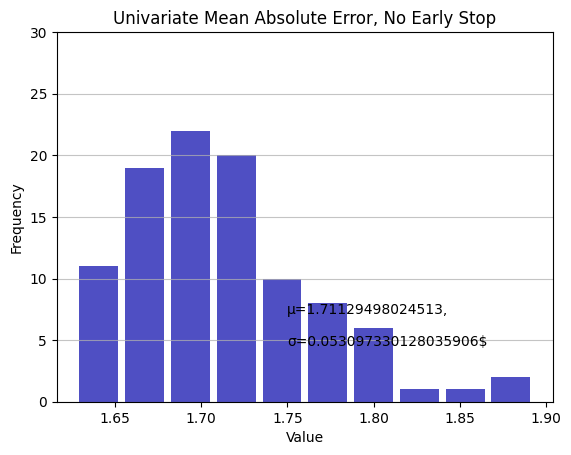

In [9]:
# Mean absolute error, no early stop

mean = sum(uni_absolute1) / len(uni_absolute1)
variance = sum([((x - mean) ** 2) for x in uni_absolute1]) / len(uni_absolute1)
sd = variance ** 0.5

m, bins, patches = plt.hist(x=uni_absolute1, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Univariate Mean Absolute Error, No Early Stop')
maxfreq = m.max()
plt.text(1.75, 4.5, '\u03BC={},\n\n\u03C3={}$'.format(mean,sd))
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

(0.0, 30.0)

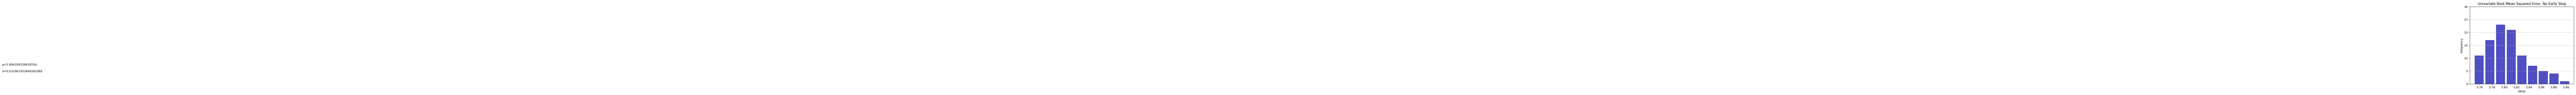

In [13]:
# Root mean squared error, no early stop

mean = sum(uni_root1) / len(uni_root1)
variance = sum([((x - mean) ** 2) for x in uni_root1]) / len(uni_root1)
sd = variance ** 0.5

m, bins, patches = plt.hist(x=uni_root1, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Univariate Root Mean Squared Error, No Early Stop')
plt.text(1.75, 4.5, '\u03BC={},\n\n\u03C3={}$'.format(mean,sd))
maxfreq = m.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [14]:
# Univariate Monte Carlo, early stopping

uni_absolute2 = []
uni_root2 = []

for i in range(n):
    train_dataloader = DataLoader(train_dataset, batch_size=config["training"]["batch_size"], shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=config["training"]["batch_size"], shuffle=True)

    model = LSTMModel(input_size=config["model"]["input_size"], hidden_layer_size=config["model"]["lstm_size"], num_layers=config["model"]["num_lstm_layers"], output_size=1, dropout=config["model"]["dropout"])
    model = model.to(config["training"]["device"])

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=config["training"]["learning_rate"], betas=(0.9, 0.98), eps=1e-9)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config["training"]["scheduler_step_size"], gamma=0.1)

    best_loss = np.inf
    epochs_no_improve = 0
    n_epochs_stop = stop
    
    for epoch in range(config["training"]["num_epoch"]):
        loss_train, lr_train = run_epoch(train_dataloader, is_training=True)
        loss_val, lr_val = run_epoch(val_dataloader)
        scheduler.step()

        print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f} | lr:{:.6f}'
                  .format(epoch+1, config["training"]["num_epoch"], loss_train, loss_val, lr_train))
        
        if loss_val < best_loss:
            best_loss = loss_val
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        if epochs_no_improve == n_epochs_stop:
            print("Early stopping.")
            break
        
    train_dataloader = DataLoader(train_dataset, batch_size=config["training"]["batch_size"], shuffle=False)
    val_dataloader = DataLoader(val_dataset, batch_size=config["training"]["batch_size"], shuffle=False)

    model.eval()
    
    predicted_train = np.array([])

    for idx, (x, y) in enumerate(train_dataloader):
        x = x.to(config["training"]["device"])
        out = model(x)
        out = out.cpu().detach().numpy()
        predicted_train = np.concatenate((predicted_train, out))

    predicted_val = np.array([])

    for idx, (x, y) in enumerate(val_dataloader):
        x = x.to(config["training"]["device"])
        out = model(x)
        out = out.cpu().detach().numpy()
        predicted_val = np.concatenate((predicted_val, out))

    data_y_train_pred = np.zeros(num_data_points)
    data_y_val_pred = np.zeros(num_data_points)

    data_y_train_pred[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(predicted_train)
    data_y_val_pred[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(predicted_val)

    mae = mean_absolute_error(close_price_data, data_y_train_pred + data_y_val_pred)
    print("Mean absolute error: ", mae)

    rmse = np.sqrt(mean_squared_error(close_price_data, data_y_train_pred+data_y_val_pred))
    print("Root mean squared error: ", rmse)
    
    uni_absolute2.append(mae)
    uni_root2.append(rmse)


Epoch[1/100] | loss train:0.059101, test:0.000867 | lr:0.010000
Epoch[2/100] | loss train:0.011438, test:0.000393 | lr:0.010000
Epoch[3/100] | loss train:0.011470, test:0.000549 | lr:0.010000
Epoch[4/100] | loss train:0.012438, test:0.001946 | lr:0.010000
Epoch[5/100] | loss train:0.010105, test:0.000831 | lr:0.010000
Epoch[6/100] | loss train:0.014316, test:0.002139 | lr:0.010000
Epoch[7/100] | loss train:0.008711, test:0.001474 | lr:0.010000
Epoch[8/100] | loss train:0.009950, test:0.002642 | lr:0.010000
Epoch[9/100] | loss train:0.010784, test:0.000523 | lr:0.010000
Epoch[10/100] | loss train:0.007983, test:0.003991 | lr:0.010000
Epoch[11/100] | loss train:0.009023, test:0.001494 | lr:0.010000
Epoch[12/100] | loss train:0.007895, test:0.004613 | lr:0.010000
Early stopping.
Mean absolute error:  5.15121168795208
Root mean squared error:  10.046701389649245
Epoch[1/100] | loss train:0.069372, test:0.001861 | lr:0.010000
Epoch[2/100] | loss train:0.013699, test:0.001561 | lr:0.010000
E

Epoch[5/100] | loss train:0.010872, test:0.002925 | lr:0.010000
Epoch[6/100] | loss train:0.008187, test:0.000301 | lr:0.010000
Epoch[7/100] | loss train:0.010462, test:0.000510 | lr:0.010000
Epoch[8/100] | loss train:0.007753, test:0.000372 | lr:0.010000
Epoch[9/100] | loss train:0.010276, test:0.002770 | lr:0.010000
Epoch[10/100] | loss train:0.008151, test:0.001448 | lr:0.010000
Epoch[11/100] | loss train:0.006962, test:0.001244 | lr:0.010000
Epoch[12/100] | loss train:0.009447, test:0.001604 | lr:0.010000
Epoch[13/100] | loss train:0.007538, test:0.000468 | lr:0.010000
Epoch[14/100] | loss train:0.007805, test:0.000371 | lr:0.010000
Epoch[15/100] | loss train:0.008634, test:0.000365 | lr:0.010000
Epoch[16/100] | loss train:0.007239, test:0.000354 | lr:0.010000
Early stopping.
Mean absolute error:  3.0074090697954183
Root mean squared error:  6.290431727865969
Epoch[1/100] | loss train:0.048171, test:0.000402 | lr:0.010000
Epoch[2/100] | loss train:0.010683, test:0.001067 | lr:0.010

Epoch[1/100] | loss train:0.063507, test:0.007582 | lr:0.010000
Epoch[2/100] | loss train:0.015796, test:0.001527 | lr:0.010000
Epoch[3/100] | loss train:0.010408, test:0.004247 | lr:0.010000
Epoch[4/100] | loss train:0.012790, test:0.003768 | lr:0.010000
Epoch[5/100] | loss train:0.009981, test:0.000660 | lr:0.010000
Epoch[6/100] | loss train:0.009066, test:0.000400 | lr:0.010000
Epoch[7/100] | loss train:0.008976, test:0.000748 | lr:0.010000
Epoch[8/100] | loss train:0.008519, test:0.000336 | lr:0.010000
Epoch[9/100] | loss train:0.007468, test:0.001134 | lr:0.010000
Epoch[10/100] | loss train:0.008318, test:0.004141 | lr:0.010000
Epoch[11/100] | loss train:0.008487, test:0.004088 | lr:0.010000
Epoch[12/100] | loss train:0.008208, test:0.000706 | lr:0.010000
Epoch[13/100] | loss train:0.007880, test:0.004659 | lr:0.010000
Epoch[14/100] | loss train:0.008878, test:0.001040 | lr:0.010000
Epoch[15/100] | loss train:0.008165, test:0.001395 | lr:0.010000
Epoch[16/100] | loss train:0.00919

Epoch[7/100] | loss train:0.009332, test:0.000882 | lr:0.010000
Epoch[8/100] | loss train:0.008318, test:0.000377 | lr:0.010000
Epoch[9/100] | loss train:0.009039, test:0.007277 | lr:0.010000
Epoch[10/100] | loss train:0.008269, test:0.000764 | lr:0.010000
Epoch[11/100] | loss train:0.008926, test:0.000558 | lr:0.010000
Epoch[12/100] | loss train:0.008304, test:0.002184 | lr:0.010000
Epoch[13/100] | loss train:0.007392, test:0.000707 | lr:0.010000
Epoch[14/100] | loss train:0.009348, test:0.000808 | lr:0.010000
Epoch[15/100] | loss train:0.008366, test:0.000499 | lr:0.010000
Epoch[16/100] | loss train:0.008684, test:0.000432 | lr:0.010000
Epoch[17/100] | loss train:0.008594, test:0.001337 | lr:0.010000
Epoch[18/100] | loss train:0.007999, test:0.000294 | lr:0.010000
Epoch[19/100] | loss train:0.007867, test:0.000350 | lr:0.010000
Epoch[20/100] | loss train:0.007538, test:0.000816 | lr:0.010000
Epoch[21/100] | loss train:0.006846, test:0.000858 | lr:0.010000
Epoch[22/100] | loss train:0

Epoch[35/100] | loss train:0.007479, test:0.000518 | lr:0.010000
Epoch[36/100] | loss train:0.007059, test:0.000716 | lr:0.010000
Early stopping.
Mean absolute error:  3.2028520155041305
Root mean squared error:  6.660167347743126
Epoch[1/100] | loss train:0.056468, test:0.000383 | lr:0.010000
Epoch[2/100] | loss train:0.010668, test:0.000608 | lr:0.010000
Epoch[3/100] | loss train:0.010334, test:0.000437 | lr:0.010000
Epoch[4/100] | loss train:0.007939, test:0.000357 | lr:0.010000
Epoch[5/100] | loss train:0.008201, test:0.001915 | lr:0.010000
Epoch[6/100] | loss train:0.008950, test:0.000381 | lr:0.010000
Epoch[7/100] | loss train:0.008552, test:0.003287 | lr:0.010000
Epoch[8/100] | loss train:0.009384, test:0.010486 | lr:0.010000
Epoch[9/100] | loss train:0.009458, test:0.000311 | lr:0.010000
Epoch[10/100] | loss train:0.007121, test:0.004388 | lr:0.010000
Epoch[11/100] | loss train:0.008251, test:0.000641 | lr:0.010000
Epoch[12/100] | loss train:0.007562, test:0.004246 | lr:0.01000

Epoch[9/100] | loss train:0.008102, test:0.000899 | lr:0.010000
Epoch[10/100] | loss train:0.007982, test:0.000340 | lr:0.010000
Epoch[11/100] | loss train:0.008513, test:0.000400 | lr:0.010000
Epoch[12/100] | loss train:0.008538, test:0.000940 | lr:0.010000
Epoch[13/100] | loss train:0.006985, test:0.002248 | lr:0.010000
Epoch[14/100] | loss train:0.008904, test:0.000543 | lr:0.010000
Epoch[15/100] | loss train:0.007811, test:0.002969 | lr:0.010000
Epoch[16/100] | loss train:0.007207, test:0.001647 | lr:0.010000
Epoch[17/100] | loss train:0.007149, test:0.001775 | lr:0.010000
Epoch[18/100] | loss train:0.007820, test:0.000381 | lr:0.010000
Epoch[19/100] | loss train:0.007812, test:0.000986 | lr:0.010000
Epoch[20/100] | loss train:0.007247, test:0.001404 | lr:0.010000
Early stopping.
Mean absolute error:  3.54675181292271
Root mean squared error:  7.125554466399126
Epoch[1/100] | loss train:0.049426, test:0.005013 | lr:0.010000
Epoch[2/100] | loss train:0.011024, test:0.000349 | lr:0.0

Epoch[6/100] | loss train:0.009005, test:0.004960 | lr:0.010000
Epoch[7/100] | loss train:0.008565, test:0.000695 | lr:0.010000
Epoch[8/100] | loss train:0.009307, test:0.000329 | lr:0.010000
Epoch[9/100] | loss train:0.015181, test:0.002075 | lr:0.010000
Epoch[10/100] | loss train:0.008791, test:0.000289 | lr:0.010000
Epoch[11/100] | loss train:0.007759, test:0.000538 | lr:0.010000
Epoch[12/100] | loss train:0.010949, test:0.000614 | lr:0.010000
Epoch[13/100] | loss train:0.007425, test:0.002161 | lr:0.010000
Epoch[14/100] | loss train:0.007372, test:0.000893 | lr:0.010000
Epoch[15/100] | loss train:0.008523, test:0.000330 | lr:0.010000
Epoch[16/100] | loss train:0.007971, test:0.000722 | lr:0.010000
Epoch[17/100] | loss train:0.007705, test:0.001831 | lr:0.010000
Epoch[18/100] | loss train:0.007426, test:0.000407 | lr:0.010000
Epoch[19/100] | loss train:0.008911, test:0.000505 | lr:0.010000
Epoch[20/100] | loss train:0.008418, test:0.001684 | lr:0.010000
Early stopping.
Mean absolute

Epoch[1/100] | loss train:0.048372, test:0.006026 | lr:0.010000
Epoch[2/100] | loss train:0.012297, test:0.000444 | lr:0.010000
Epoch[3/100] | loss train:0.009132, test:0.000318 | lr:0.010000
Epoch[4/100] | loss train:0.009713, test:0.000883 | lr:0.010000
Epoch[5/100] | loss train:0.009435, test:0.000579 | lr:0.010000
Epoch[6/100] | loss train:0.008607, test:0.002797 | lr:0.010000
Epoch[7/100] | loss train:0.008713, test:0.001337 | lr:0.010000
Epoch[8/100] | loss train:0.009525, test:0.003690 | lr:0.010000
Epoch[9/100] | loss train:0.008561, test:0.000359 | lr:0.010000
Epoch[10/100] | loss train:0.009068, test:0.000723 | lr:0.010000
Epoch[11/100] | loss train:0.006838, test:0.002656 | lr:0.010000
Epoch[12/100] | loss train:0.008767, test:0.001936 | lr:0.010000
Epoch[13/100] | loss train:0.009074, test:0.002715 | lr:0.010000
Early stopping.
Mean absolute error:  6.204365324612926
Root mean squared error:  9.017772499779358
Epoch[1/100] | loss train:0.072146, test:0.001602 | lr:0.010000


Epoch[15/100] | loss train:0.008227, test:0.000585 | lr:0.010000
Early stopping.
Mean absolute error:  5.00712350533681
Root mean squared error:  7.826636152706649
Epoch[1/100] | loss train:0.050338, test:0.004590 | lr:0.010000
Epoch[2/100] | loss train:0.012749, test:0.000780 | lr:0.010000
Epoch[3/100] | loss train:0.012256, test:0.006298 | lr:0.010000
Epoch[4/100] | loss train:0.011328, test:0.001244 | lr:0.010000
Epoch[5/100] | loss train:0.008965, test:0.002496 | lr:0.010000
Epoch[6/100] | loss train:0.008638, test:0.000728 | lr:0.010000
Epoch[7/100] | loss train:0.009853, test:0.000876 | lr:0.010000
Epoch[8/100] | loss train:0.009399, test:0.002471 | lr:0.010000
Epoch[9/100] | loss train:0.009073, test:0.001268 | lr:0.010000
Epoch[10/100] | loss train:0.008743, test:0.004855 | lr:0.010000
Epoch[11/100] | loss train:0.009001, test:0.002155 | lr:0.010000
Epoch[12/100] | loss train:0.008473, test:0.000513 | lr:0.010000
Epoch[13/100] | loss train:0.008355, test:0.000971 | lr:0.010000


Epoch[7/100] | loss train:0.010621, test:0.002744 | lr:0.010000
Epoch[8/100] | loss train:0.008034, test:0.000308 | lr:0.010000
Epoch[9/100] | loss train:0.008678, test:0.000907 | lr:0.010000
Epoch[10/100] | loss train:0.007928, test:0.000675 | lr:0.010000
Epoch[11/100] | loss train:0.007372, test:0.001103 | lr:0.010000
Epoch[12/100] | loss train:0.008667, test:0.000867 | lr:0.010000
Epoch[13/100] | loss train:0.008318, test:0.000392 | lr:0.010000
Epoch[14/100] | loss train:0.014989, test:0.008713 | lr:0.010000
Epoch[15/100] | loss train:0.009888, test:0.000339 | lr:0.010000
Epoch[16/100] | loss train:0.007610, test:0.009546 | lr:0.010000
Epoch[17/100] | loss train:0.008523, test:0.000381 | lr:0.010000
Epoch[18/100] | loss train:0.008242, test:0.002290 | lr:0.010000
Early stopping.
Mean absolute error:  5.338335770486318
Root mean squared error:  9.566661718217027
Epoch[1/100] | loss train:0.054318, test:0.004593 | lr:0.010000
Epoch[2/100] | loss train:0.012104, test:0.002436 | lr:0.01

Mean absolute error:  3.376360942686083
Root mean squared error:  7.325483819571186
Epoch[1/100] | loss train:0.063001, test:0.000815 | lr:0.010000
Epoch[2/100] | loss train:0.013595, test:0.001907 | lr:0.010000
Epoch[3/100] | loss train:0.011681, test:0.000330 | lr:0.010000
Epoch[4/100] | loss train:0.009300, test:0.000989 | lr:0.010000
Epoch[5/100] | loss train:0.008817, test:0.002610 | lr:0.010000
Epoch[6/100] | loss train:0.008956, test:0.015670 | lr:0.010000
Epoch[7/100] | loss train:0.010120, test:0.005774 | lr:0.010000
Epoch[8/100] | loss train:0.009088, test:0.000333 | lr:0.010000
Epoch[9/100] | loss train:0.010055, test:0.000836 | lr:0.010000
Epoch[10/100] | loss train:0.006785, test:0.001111 | lr:0.010000
Epoch[11/100] | loss train:0.008888, test:0.002374 | lr:0.010000
Epoch[12/100] | loss train:0.007364, test:0.002031 | lr:0.010000
Epoch[13/100] | loss train:0.009505, test:0.000424 | lr:0.010000
Early stopping.
Mean absolute error:  4.129300225859234
Root mean squared error:

Epoch[18/100] | loss train:0.013040, test:0.000758 | lr:0.010000
Early stopping.
Mean absolute error:  4.961316518465653
Root mean squared error:  7.589934472944089
Epoch[1/100] | loss train:0.048784, test:0.001177 | lr:0.010000
Epoch[2/100] | loss train:0.011124, test:0.000356 | lr:0.010000
Epoch[3/100] | loss train:0.018742, test:0.001426 | lr:0.010000
Epoch[4/100] | loss train:0.011181, test:0.000300 | lr:0.010000
Epoch[5/100] | loss train:0.010200, test:0.005152 | lr:0.010000
Epoch[6/100] | loss train:0.008976, test:0.000937 | lr:0.010000
Epoch[7/100] | loss train:0.009927, test:0.006502 | lr:0.010000
Epoch[8/100] | loss train:0.010280, test:0.000387 | lr:0.010000
Epoch[9/100] | loss train:0.007976, test:0.006123 | lr:0.010000
Epoch[10/100] | loss train:0.007922, test:0.001636 | lr:0.010000
Epoch[11/100] | loss train:0.008883, test:0.000997 | lr:0.010000
Epoch[12/100] | loss train:0.009065, test:0.000879 | lr:0.010000
Epoch[13/100] | loss train:0.007799, test:0.001742 | lr:0.010000

Epoch[7/100] | loss train:0.011193, test:0.002723 | lr:0.010000
Epoch[8/100] | loss train:0.010242, test:0.000585 | lr:0.010000
Epoch[9/100] | loss train:0.008129, test:0.000374 | lr:0.010000
Epoch[10/100] | loss train:0.008099, test:0.001735 | lr:0.010000
Epoch[11/100] | loss train:0.014498, test:0.007593 | lr:0.010000
Epoch[12/100] | loss train:0.010090, test:0.000366 | lr:0.010000
Epoch[13/100] | loss train:0.006862, test:0.007795 | lr:0.010000
Epoch[14/100] | loss train:0.009093, test:0.002172 | lr:0.010000
Epoch[15/100] | loss train:0.008897, test:0.000432 | lr:0.010000
Epoch[16/100] | loss train:0.009873, test:0.000771 | lr:0.010000
Epoch[17/100] | loss train:0.008209, test:0.001488 | lr:0.010000
Epoch[18/100] | loss train:0.009072, test:0.000440 | lr:0.010000
Epoch[19/100] | loss train:0.007480, test:0.002444 | lr:0.010000
Epoch[20/100] | loss train:0.007308, test:0.000524 | lr:0.010000
Epoch[21/100] | loss train:0.007785, test:0.002214 | lr:0.010000
Epoch[22/100] | loss train:0

Epoch[16/100] | loss train:0.011897, test:0.002384 | lr:0.010000
Epoch[17/100] | loss train:0.008310, test:0.001702 | lr:0.010000
Early stopping.
Mean absolute error:  2.7543330190200543
Root mean squared error:  7.140016169065071
Epoch[1/100] | loss train:0.054338, test:0.006403 | lr:0.010000
Epoch[2/100] | loss train:0.011881, test:0.000409 | lr:0.010000
Epoch[3/100] | loss train:0.009606, test:0.000318 | lr:0.010000
Epoch[4/100] | loss train:0.009737, test:0.002235 | lr:0.010000
Epoch[5/100] | loss train:0.009185, test:0.000458 | lr:0.010000
Epoch[6/100] | loss train:0.007237, test:0.003824 | lr:0.010000
Epoch[7/100] | loss train:0.008823, test:0.001516 | lr:0.010000
Epoch[8/100] | loss train:0.008638, test:0.001539 | lr:0.010000
Epoch[9/100] | loss train:0.009782, test:0.001685 | lr:0.010000
Epoch[10/100] | loss train:0.009829, test:0.004714 | lr:0.010000
Epoch[11/100] | loss train:0.007914, test:0.000563 | lr:0.010000
Epoch[12/100] | loss train:0.006784, test:0.000375 | lr:0.01000

Epoch[4/100] | loss train:0.010712, test:0.002338 | lr:0.010000
Epoch[5/100] | loss train:0.015604, test:0.010159 | lr:0.010000
Epoch[6/100] | loss train:0.011832, test:0.002650 | lr:0.010000
Epoch[7/100] | loss train:0.009487, test:0.001155 | lr:0.010000
Epoch[8/100] | loss train:0.008999, test:0.007791 | lr:0.010000
Epoch[9/100] | loss train:0.008659, test:0.008121 | lr:0.010000
Epoch[10/100] | loss train:0.008590, test:0.000641 | lr:0.010000
Epoch[11/100] | loss train:0.008585, test:0.000463 | lr:0.010000
Epoch[12/100] | loss train:0.007517, test:0.000845 | lr:0.010000
Epoch[13/100] | loss train:0.008467, test:0.000490 | lr:0.010000
Early stopping.
Mean absolute error:  4.899202560464855
Root mean squared error:  7.3428082100465195
Epoch[1/100] | loss train:0.051191, test:0.007826 | lr:0.010000
Epoch[2/100] | loss train:0.015031, test:0.002786 | lr:0.010000
Epoch[3/100] | loss train:0.009183, test:0.001421 | lr:0.010000
Epoch[4/100] | loss train:0.009801, test:0.000824 | lr:0.010000

Epoch[8/100] | loss train:0.008371, test:0.000325 | lr:0.010000
Epoch[9/100] | loss train:0.011128, test:0.000382 | lr:0.010000
Epoch[10/100] | loss train:0.008282, test:0.000411 | lr:0.010000
Epoch[11/100] | loss train:0.009044, test:0.002063 | lr:0.010000
Epoch[12/100] | loss train:0.009748, test:0.000835 | lr:0.010000
Epoch[13/100] | loss train:0.008992, test:0.004929 | lr:0.010000
Epoch[14/100] | loss train:0.008030, test:0.000778 | lr:0.010000
Epoch[15/100] | loss train:0.008855, test:0.000974 | lr:0.010000
Epoch[16/100] | loss train:0.007239, test:0.000469 | lr:0.010000
Epoch[17/100] | loss train:0.009177, test:0.006144 | lr:0.010000
Epoch[18/100] | loss train:0.008923, test:0.001534 | lr:0.010000
Early stopping.
Mean absolute error:  4.746889461647017
Root mean squared error:  8.050123274679635
Epoch[1/100] | loss train:0.052535, test:0.000986 | lr:0.010000
Epoch[2/100] | loss train:0.011345, test:0.000400 | lr:0.010000
Epoch[3/100] | loss train:0.010839, test:0.002595 | lr:0.01

(0.0, 30.0)

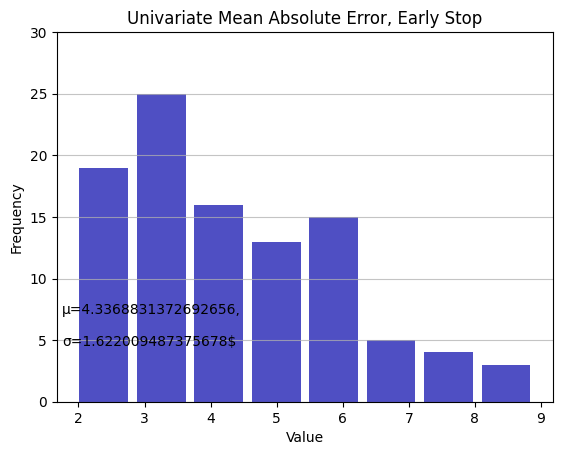

In [15]:
# Mean absolute error, early stop

mean = sum(uni_absolute2) / len(uni_absolute2)
variance = sum([((x - mean) ** 2) for x in uni_absolute2]) / len(uni_absolute2)
sd = variance ** 0.5

m, bins, patches = plt.hist(x=uni_absolute2, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Univariate Mean Absolute Error, Early Stop')
maxfreq = m.max()
plt.text(1.75, 4.5, '\u03BC={},\n\n\u03C3={}$'.format(mean,sd))
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

(0.0, 40.0)

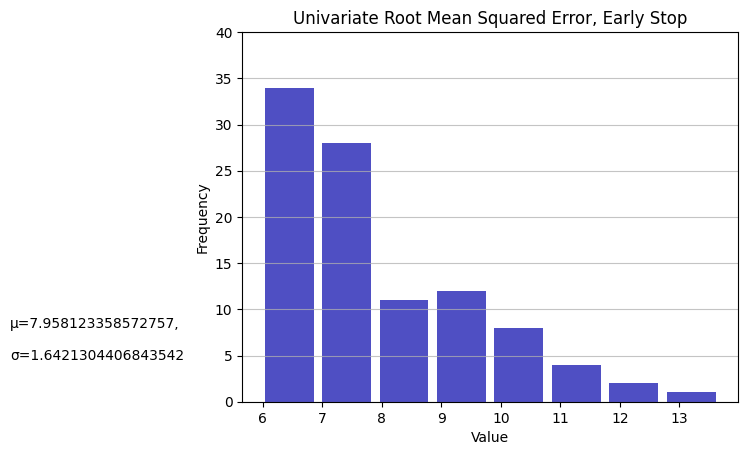

In [16]:
# Root mean squared error, early stop

mean = sum(uni_root2) / len(uni_root2)
variance = sum([((x - mean) ** 2) for x in uni_root2]) / len(uni_root2)
sd = variance ** 0.5

m, bins, patches = plt.hist(x=uni_root2, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Univariate Root Mean Squared Error, Early Stop')
plt.text(1.75, 4.5, '\u03BC={},\n\n\u03C3={}'.format(mean,sd))
maxfreq = m.max()
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

### Multivariate Model

In [17]:
# prep the data

train_df, test_df = preprocess.prep_data(df=data, split_index = split_index, plot_df=True)
train_df.shape, test_df.shape

Starting with data preparation...
Completed.


((5573, 7), (314, 7))

In [18]:
sequence_length = 30
batch_size = config["training"]["batch_size"]
n_epochs = config["training"]["num_epoch"]
n_epochs_stop = stop
label_name = 'Close'

In [ ]:
# Multivariate Monte Carlo, no early stopping

multi_absolute1 = []
multi_root1 = []
for i in range(n):
    
    hist = train.train_model_no_early(train_df, test_df, label_name, sequence_length, batch_size, n_epochs)
    predictions_descaled, labels_descaled = inference.predict(df=test_df,
                                                          label_name='Close',
                                                          sequence_length=sequence_length)
    mae, rmse = inference.return_loss_metrics(labels_descaled, predictions_descaled)
    multi_absolute1.append(mae)
    multi_root1.append(rmse)

Starting with model training...
Epoch 1 train loss: 0.0073 test loss: 0.0052
Epoch 2 train loss: 0.0679 test loss: 0.0019
Epoch 3 train loss: 0.1062 test loss: 0.0108
Epoch 4 train loss: 0.0377 test loss: 0.0021
Epoch 5 train loss: 0.0109 test loss: 0.0017
Epoch 6 train loss: 0.0059 test loss: 0.0001
Epoch 7 train loss: 0.0021 test loss: 0.0004
Epoch 8 train loss: 0.0027 test loss: 0.0004
Epoch 9 train loss: 0.0029 test loss: 0.0004
Epoch 10 train loss: 0.0021 test loss: 0.0004
Epoch 11 train loss: 0.0042 test loss: 0.0001
Epoch 12 train loss: 0.0019 test loss: 0.0002
Epoch 13 train loss: 0.0018 test loss: 0.0002
Epoch 14 train loss: 0.0018 test loss: 0.0002
Epoch 15 train loss: 0.0017 test loss: 0.0003
Epoch 16 train loss: 0.0015 test loss: 0.0002
Epoch 17 train loss: 0.0017 test loss: 0.0001
Epoch 18 train loss: 0.0017 test loss: 0.0001
Epoch 19 train loss: 0.0015 test loss: 0.0001
Epoch 20 train loss: 0.0014 test loss: 0.0001
Epoch 21 train loss: 0.0014 test loss: 0.0002
Epoch 22 tr

Epoch 1 train loss: 0.0044 test loss: 0.0012
Epoch 2 train loss: 0.0823 test loss: 0.0116
Epoch 3 train loss: 0.0586 test loss: 0.0033
Epoch 4 train loss: 0.0222 test loss: 0.0037
Epoch 5 train loss: 0.0094 test loss: 0.0004
Epoch 6 train loss: 0.0045 test loss: 0.0003
Epoch 7 train loss: 0.0094 test loss: 0.0002
Epoch 8 train loss: 0.0044 test loss: 0.0001
Epoch 9 train loss: 0.0047 test loss: 0.0001
Epoch 10 train loss: 0.0035 test loss: 0.0001
Epoch 11 train loss: 0.0037 test loss: 0.0001
Epoch 12 train loss: 0.0031 test loss: 0.0002
Epoch 13 train loss: 0.0038 test loss: 0.0001
Epoch 14 train loss: 0.0039 test loss: 0.0002
Epoch 15 train loss: 0.0036 test loss: 0.0001
Epoch 16 train loss: 0.0037 test loss: 0.0002
Epoch 17 train loss: 0.0033 test loss: 0.0001
Epoch 18 train loss: 0.0035 test loss: 0.0003
Epoch 19 train loss: 0.0034 test loss: 0.0002
Epoch 20 train loss: 0.0039 test loss: 0.0003
Epoch 21 train loss: 0.0034 test loss: 0.0002
Epoch 22 train loss: 0.0039 test loss: 0.00

Epoch 1 train loss: 0.0081 test loss: 0.0062
Epoch 2 train loss: 0.0617 test loss: 0.0005
Epoch 3 train loss: 0.0627 test loss: 0.0002
Epoch 4 train loss: 0.029 test loss: 0.0027
Epoch 5 train loss: 0.0084 test loss: 0.0041
Epoch 6 train loss: 0.0065 test loss: 0.0005
Epoch 7 train loss: 0.0038 test loss: 0.0002
Epoch 8 train loss: 0.0047 test loss: 0.0001
Epoch 9 train loss: 0.0041 test loss: 0.0001
Epoch 10 train loss: 0.0027 test loss: 0.0001
Epoch 11 train loss: 0.0033 test loss: 0.0003
Epoch 12 train loss: 0.0021 test loss: 0.0001
Epoch 13 train loss: 0.0039 test loss: 0.0002
Epoch 14 train loss: 0.0017 test loss: 0.0001
Epoch 15 train loss: 0.0027 test loss: 0.0004
Epoch 16 train loss: 0.0017 test loss: 0.0001
Epoch 17 train loss: 0.003 test loss: 0.0001
Epoch 18 train loss: 0.0014 test loss: 0.0004
Epoch 19 train loss: 0.0016 test loss: 0.0001
Epoch 20 train loss: 0.0024 test loss: 0.0001
Epoch 21 train loss: 0.0016 test loss: 0.0001
Epoch 22 train loss: 0.0015 test loss: 0.0001

Epoch 1 train loss: 0.0069 test loss: 0.0043
Epoch 2 train loss: 0.07 test loss: 0.0044
Epoch 3 train loss: 0.1061 test loss: 0.0148
Epoch 4 train loss: 0.0568 test loss: 0.0032
Epoch 5 train loss: 0.0191 test loss: 0.0002
Epoch 6 train loss: 0.0034 test loss: 0.0003
Epoch 7 train loss: 0.0035 test loss: 0.0007
Epoch 8 train loss: 0.0033 test loss: 0.0024
Epoch 9 train loss: 0.0026 test loss: 0.0002
Epoch 10 train loss: 0.0024 test loss: 0.0002
Epoch 11 train loss: 0.0019 test loss: 0.0002
Epoch 12 train loss: 0.0056 test loss: 0.0002
Epoch 13 train loss: 0.0031 test loss: 0.0003
Epoch 14 train loss: 0.0041 test loss: 0.0002
Epoch 15 train loss: 0.0029 test loss: 0.0003
Epoch 16 train loss: 0.0039 test loss: 0.0002
Epoch 17 train loss: 0.003 test loss: 0.0005
Epoch 18 train loss: 0.0033 test loss: 0.0002
Epoch 19 train loss: 0.0037 test loss: 0.0003
Epoch 20 train loss: 0.003 test loss: 0.0002
Epoch 21 train loss: 0.0032 test loss: 0.0005
Epoch 22 train loss: 0.0029 test loss: 0.0002
E

Epoch 1 train loss: 0.0062 test loss: 0.0036
Epoch 2 train loss: 0.0652 test loss: 0.0063
Epoch 3 train loss: 0.1036 test loss: 0.019
Epoch 4 train loss: 0.0243 test loss: 0.0017
Epoch 5 train loss: 0.0087 test loss: 0.0001
Epoch 6 train loss: 0.0024 test loss: 0.0002
Epoch 7 train loss: 0.0031 test loss: 0.0001
Epoch 8 train loss: 0.002 test loss: 0.0001
Epoch 9 train loss: 0.0022 test loss: 0.0003
Epoch 10 train loss: 0.0018 test loss: 0.0003
Epoch 11 train loss: 0.0024 test loss: 0.0002
Epoch 12 train loss: 0.002 test loss: 0.0001
Epoch 13 train loss: 0.0026 test loss: 0.0004
Epoch 14 train loss: 0.0026 test loss: 0.0018
Epoch 15 train loss: 0.003 test loss: 0.0005
Epoch 16 train loss: 0.0026 test loss: 0.0004
Epoch 17 train loss: 0.0052 test loss: 0.0003
Epoch 18 train loss: 0.0045 test loss: 0.0002
Epoch 19 train loss: 0.0023 test loss: 0.0004
Epoch 20 train loss: 0.0021 test loss: 0.0002
Epoch 21 train loss: 0.0026 test loss: 0.0004
Epoch 22 train loss: 0.0021 test loss: 0.0001
E

Epoch 1 train loss: 0.0068 test loss: 0.0044
Epoch 2 train loss: 0.0617 test loss: 0.001
Epoch 3 train loss: 0.0919 test loss: 0.0103
Epoch 4 train loss: 0.0258 test loss: 0.0023
Epoch 5 train loss: 0.0126 test loss: 0.0011
Epoch 6 train loss: 0.0073 test loss: 0.0002
Epoch 7 train loss: 0.0036 test loss: 0.0001
Epoch 8 train loss: 0.0116 test loss: 0.0001
Epoch 9 train loss: 0.0027 test loss: 0.0001
Epoch 10 train loss: 0.0033 test loss: 0.0001
Epoch 11 train loss: 0.0023 test loss: 0.0001
Epoch 12 train loss: 0.0033 test loss: 0.0001
Epoch 13 train loss: 0.0028 test loss: 0.0001
Epoch 14 train loss: 0.0035 test loss: 0.0001
Epoch 15 train loss: 0.0026 test loss: 0.0003
Epoch 16 train loss: 0.0041 test loss: 0.0001
Epoch 17 train loss: 0.0042 test loss: 0.0002
Epoch 18 train loss: 0.0036 test loss: 0.0001
Epoch 19 train loss: 0.003 test loss: 0.0002
Epoch 20 train loss: 0.0032 test loss: 0.0002
Epoch 21 train loss: 0.0029 test loss: 0.0003
Epoch 22 train loss: 0.0032 test loss: 0.0002

Epoch 1 train loss: 0.0058 test loss: 0.0035
Epoch 2 train loss: 0.0767 test loss: 0.0004
Epoch 3 train loss: 0.0938 test loss: 0.0142
Epoch 4 train loss: 0.0225 test loss: 0.0019
Epoch 5 train loss: 0.0085 test loss: 0.0001
Epoch 6 train loss: 0.003 test loss: 0.0002
Epoch 7 train loss: 0.0035 test loss: 0.0007
Epoch 8 train loss: 0.0089 test loss: 0.0003
Epoch 9 train loss: 0.0035 test loss: 0.0001
Epoch 10 train loss: 0.0032 test loss: 0.0002
Epoch 11 train loss: 0.0022 test loss: 0.0004
Epoch 12 train loss: 0.0039 test loss: 0.0002
Epoch 13 train loss: 0.003 test loss: 0.0002
Epoch 14 train loss: 0.003 test loss: 0.0002
Epoch 15 train loss: 0.0027 test loss: 0.0004
Epoch 16 train loss: 0.0032 test loss: 0.0002
Epoch 17 train loss: 0.0032 test loss: 0.0004
Epoch 18 train loss: 0.0032 test loss: 0.0002
Epoch 19 train loss: 0.0034 test loss: 0.0002
Epoch 20 train loss: 0.0025 test loss: 0.0003
Epoch 21 train loss: 0.0029 test loss: 0.0004
Epoch 22 train loss: 0.0029 test loss: 0.0002


Epoch 1 train loss: 0.0077 test loss: 0.0058
Epoch 2 train loss: 0.0714 test loss: 0.0018
Epoch 3 train loss: 0.0869 test loss: 0.0079
Epoch 4 train loss: 0.0431 test loss: 0.0037
Epoch 5 train loss: 0.0148 test loss: 0.0036
Epoch 6 train loss: 0.006 test loss: 0.0008
Epoch 7 train loss: 0.0044 test loss: 0.0002
Epoch 8 train loss: 0.0033 test loss: 0.0002
Epoch 9 train loss: 0.0137 test loss: 0.0003
Epoch 10 train loss: 0.0037 test loss: 0.0001
Epoch 11 train loss: 0.0039 test loss: 0.0001
Epoch 12 train loss: 0.0027 test loss: 0.0001
Epoch 13 train loss: 0.0024 test loss: 0.0002
Epoch 14 train loss: 0.0022 test loss: 0.0001
Epoch 15 train loss: 0.0021 test loss: 0.0003
Epoch 16 train loss: 0.0019 test loss: 0.0001
Epoch 17 train loss: 0.0023 test loss: 0.0005
Epoch 18 train loss: 0.0019 test loss: 0.0001
Epoch 19 train loss: 0.0032 test loss: 0.0004
Epoch 20 train loss: 0.0022 test loss: 0.0002
Epoch 21 train loss: 0.0025 test loss: 0.0003
Epoch 22 train loss: 0.002 test loss: 0.0001

Epoch 1 train loss: 0.0054 test loss: 0.0057
Epoch 2 train loss: 0.1083 test loss: 0.0128
Epoch 3 train loss: 0.0751 test loss: 0.0144
Epoch 4 train loss: 0.0195 test loss: 0.0011
Epoch 5 train loss: 0.0039 test loss: 0.0023
Epoch 6 train loss: 0.0054 test loss: 0.0003
Epoch 7 train loss: 0.0048 test loss: 0.0035
Epoch 8 train loss: 0.0029 test loss: 0.0003
Epoch 9 train loss: 0.0024 test loss: 0.0002
Epoch 10 train loss: 0.0023 test loss: 0.0001
Epoch 11 train loss: 0.0029 test loss: 0.0002
Epoch 12 train loss: 0.0019 test loss: 0.0002
Epoch 13 train loss: 0.004 test loss: 0.0003
Epoch 14 train loss: 0.0036 test loss: 0.0003
Epoch 15 train loss: 0.0039 test loss: 0.0002
Epoch 16 train loss: 0.0034 test loss: 0.0002
Epoch 17 train loss: 0.003 test loss: 0.0003
Epoch 18 train loss: 0.0032 test loss: 0.0004
Epoch 19 train loss: 0.0036 test loss: 0.0002
Epoch 20 train loss: 0.004 test loss: 0.0004
Epoch 21 train loss: 0.0028 test loss: 0.0002
Epoch 22 train loss: 0.003 test loss: 0.0002
E

Epoch 1 train loss: 0.0088 test loss: 0.0055
Epoch 2 train loss: 0.062 test loss: 0.0006
Epoch 3 train loss: 0.0804 test loss: 0.0025
Epoch 4 train loss: 0.0447 test loss: 0.005
Epoch 5 train loss: 0.0131 test loss: 0.0004
Epoch 6 train loss: 0.0029 test loss: 0.0007
Epoch 7 train loss: 0.0033 test loss: 0.0002
Epoch 8 train loss: 0.0026 test loss: 0.0004
Epoch 9 train loss: 0.0019 test loss: 0.0004
Epoch 10 train loss: 0.0029 test loss: 0.0003
Epoch 11 train loss: 0.0022 test loss: 0.0002
Epoch 12 train loss: 0.002 test loss: 0.0001
Epoch 13 train loss: 0.0019 test loss: 0.0001
Epoch 14 train loss: 0.0015 test loss: 0.0001
Epoch 15 train loss: 0.0017 test loss: 0.0001
Epoch 16 train loss: 0.0015 test loss: 0.0001
Epoch 17 train loss: 0.0015 test loss: 0.0001
Epoch 18 train loss: 0.0015 test loss: 0.0001
Epoch 19 train loss: 0.0017 test loss: 0.0001
Epoch 20 train loss: 0.0013 test loss: 0.0002
Epoch 21 train loss: 0.0016 test loss: 0.0001
Epoch 22 train loss: 0.0015 test loss: 0.0005


Epoch 1 train loss: 0.0094 test loss: 0.0059
Epoch 2 train loss: 0.0567 test loss: 0.0006
Epoch 3 train loss: 0.0726 test loss: 0.0004
Epoch 4 train loss: 0.0386 test loss: 0.0007
Epoch 5 train loss: 0.008 test loss: 0.0002
Epoch 6 train loss: 0.0035 test loss: 0.0009
Epoch 7 train loss: 0.0034 test loss: 0.0001
Epoch 8 train loss: 0.0041 test loss: 0.0003
Epoch 9 train loss: 0.0044 test loss: 0.0019
Epoch 10 train loss: 0.0034 test loss: 0.0015
Epoch 11 train loss: 0.0024 test loss: 0.0001
Epoch 12 train loss: 0.0025 test loss: 0.0002
Epoch 13 train loss: 0.0018 test loss: 0.0002
Epoch 14 train loss: 0.0038 test loss: 0.0002
Epoch 15 train loss: 0.0026 test loss: 0.0003
Epoch 16 train loss: 0.0063 test loss: 0.0002
Epoch 17 train loss: 0.0033 test loss: 0.0003
Epoch 18 train loss: 0.0033 test loss: 0.0002
Epoch 19 train loss: 0.0029 test loss: 0.0004
Epoch 20 train loss: 0.0036 test loss: 0.0003
Epoch 21 train loss: 0.0026 test loss: 0.0003
Epoch 22 train loss: 0.0028 test loss: 0.000

Epoch 1 train loss: 0.0066 test loss: 0.002
Epoch 2 train loss: 0.0556 test loss: 0.0046
Epoch 3 train loss: 0.1069 test loss: 0.0192
Epoch 4 train loss: 0.0323 test loss: 0.005
Epoch 5 train loss: 0.056 test loss: 0.0114
Epoch 6 train loss: 0.0109 test loss: 0.0002
Epoch 7 train loss: 0.003 test loss: 0.0002
Epoch 8 train loss: 0.0101 test loss: 0.0001
Epoch 9 train loss: 0.0052 test loss: 0.0006
Epoch 10 train loss: 0.0141 test loss: 0.0004
Epoch 11 train loss: 0.0083 test loss: 0.0001
Epoch 12 train loss: 0.007 test loss: 0.0001
Epoch 13 train loss: 0.0052 test loss: 0.0001
Epoch 14 train loss: 0.004 test loss: 0.0001
Epoch 15 train loss: 0.0028 test loss: 0.0001
Epoch 16 train loss: 0.0024 test loss: 0.0001
Epoch 17 train loss: 0.002 test loss: 0.0001
Epoch 18 train loss: 0.002 test loss: 0.0001
Epoch 19 train loss: 0.0019 test loss: 0.0001
Epoch 20 train loss: 0.002 test loss: 0.0001
Epoch 21 train loss: 0.002 test loss: 0.0001
Epoch 22 train loss: 0.0024 test loss: 0.0001
Epoch 2

Epoch 1 train loss: 0.0075 test loss: 0.0057
Epoch 2 train loss: 0.058 test loss: 0.0003
Epoch 3 train loss: 0.082 test loss: 0.0006
Epoch 4 train loss: 0.0573 test loss: 0.0001
Epoch 5 train loss: 0.0172 test loss: 0.0023
Epoch 6 train loss: 0.0048 test loss: 0.0003
Epoch 7 train loss: 0.0035 test loss: 0.0002
Epoch 8 train loss: 0.0046 test loss: 0.0002
Epoch 9 train loss: 0.003 test loss: 0.0001
Epoch 10 train loss: 0.0034 test loss: 0.0003
Epoch 11 train loss: 0.0024 test loss: 0.0006
Epoch 12 train loss: 0.0055 test loss: 0.0002
Epoch 13 train loss: 0.0025 test loss: 0.0002
Epoch 14 train loss: 0.003 test loss: 0.0002
Epoch 15 train loss: 0.0021 test loss: 0.0005
Epoch 16 train loss: 0.0041 test loss: 0.0002
Epoch 17 train loss: 0.0029 test loss: 0.0004
Epoch 18 train loss: 0.0029 test loss: 0.0003
Epoch 19 train loss: 0.0023 test loss: 0.0003
Epoch 20 train loss: 0.0025 test loss: 0.0003
Epoch 21 train loss: 0.0023 test loss: 0.0002
Epoch 22 train loss: 0.0025 test loss: 0.0004
E

Epoch 1 train loss: 0.0048 test loss: 0.0008
Epoch 2 train loss: 0.0695 test loss: 0.0011
Epoch 3 train loss: 0.1021 test loss: 0.0213
Epoch 4 train loss: 0.0221 test loss: 0.0022
Epoch 5 train loss: 0.0086 test loss: 0.0024
Epoch 6 train loss: 0.0024 test loss: 0.0002
Epoch 7 train loss: 0.0028 test loss: 0.0002
Epoch 8 train loss: 0.0027 test loss: 0.0007
Epoch 9 train loss: 0.0026 test loss: 0.0003
Epoch 10 train loss: 0.0043 test loss: 0.0002
Epoch 11 train loss: 0.0032 test loss: 0.0001
Epoch 12 train loss: 0.0025 test loss: 0.0005
Epoch 13 train loss: 0.0028 test loss: 0.0006
Epoch 14 train loss: 0.0041 test loss: 0.0003
Epoch 15 train loss: 0.0038 test loss: 0.0002
Epoch 16 train loss: 0.0025 test loss: 0.0003
Epoch 17 train loss: 0.003 test loss: 0.0004
Epoch 18 train loss: 0.0034 test loss: 0.0003
Epoch 19 train loss: 0.004 test loss: 0.0003
Epoch 20 train loss: 0.0028 test loss: 0.0002
Epoch 21 train loss: 0.0036 test loss: 0.0003
Epoch 22 train loss: 0.0023 test loss: 0.0003

Epoch 1 train loss: 0.006 test loss: 0.0014
Epoch 2 train loss: 0.0717 test loss: 0.0004
Epoch 3 train loss: 0.0998 test loss: 0.0172
Epoch 4 train loss: 0.0279 test loss: 0.0009
Epoch 5 train loss: 0.0091 test loss: 0.0001
Epoch 6 train loss: 0.0024 test loss: 0.0001
Epoch 7 train loss: 0.0028 test loss: 0.0001
Epoch 8 train loss: 0.002 test loss: 0.0001
Epoch 9 train loss: 0.0019 test loss: 0.0001
Epoch 10 train loss: 0.0022 test loss: 0.0001
Epoch 11 train loss: 0.0026 test loss: 0.0008
Epoch 12 train loss: 0.0019 test loss: 0.0003
Epoch 13 train loss: 0.002 test loss: 0.0004
Epoch 14 train loss: 0.0018 test loss: 0.0001
Epoch 15 train loss: 0.003 test loss: 0.0002
Epoch 16 train loss: 0.0015 test loss: 0.0008
Epoch 17 train loss: 0.0018 test loss: 0.0002
Epoch 18 train loss: 0.003 test loss: 0.0002
Epoch 19 train loss: 0.0019 test loss: 0.0011
Epoch 20 train loss: 0.0019 test loss: 0.0003
Epoch 21 train loss: 0.0032 test loss: 0.0005
Epoch 22 train loss: 0.0022 test loss: 0.0003
Ep

Epoch 1 train loss: 0.0043 test loss: 0.0007
Epoch 2 train loss: 0.0845 test loss: 0.0131
Epoch 3 train loss: 0.0601 test loss: 0.0082
Epoch 4 train loss: 0.0186 test loss: 0.0016
Epoch 5 train loss: 0.0039 test loss: 0.0002
Epoch 6 train loss: 0.0024 test loss: 0.0006
Epoch 7 train loss: 0.0025 test loss: 0.0002
Epoch 8 train loss: 0.0039 test loss: 0.0001
Epoch 9 train loss: 0.0027 test loss: 0.0007
Epoch 10 train loss: 0.0032 test loss: 0.0001
Epoch 11 train loss: 0.0038 test loss: 0.0003
Epoch 12 train loss: 0.0029 test loss: 0.0006
Epoch 13 train loss: 0.004 test loss: 0.0003
Epoch 14 train loss: 0.0041 test loss: 0.0003
Epoch 15 train loss: 0.0029 test loss: 0.0002
Epoch 16 train loss: 0.0033 test loss: 0.0002
Epoch 17 train loss: 0.0026 test loss: 0.0002
Epoch 18 train loss: 0.0029 test loss: 0.0002
Epoch 19 train loss: 0.0024 test loss: 0.0003
Epoch 20 train loss: 0.0028 test loss: 0.0002
Epoch 21 train loss: 0.0027 test loss: 0.0004
Epoch 22 train loss: 0.003 test loss: 0.0001

Epoch 1 train loss: 0.0078 test loss: 0.0049
Epoch 2 train loss: 0.056 test loss: 0.0006
Epoch 3 train loss: 0.071 test loss: 0.0022
Epoch 4 train loss: 0.0687 test loss: 0.0008
Epoch 5 train loss: 0.02 test loss: 0.0028
Epoch 6 train loss: 0.0043 test loss: 0.0003
Epoch 7 train loss: 0.0028 test loss: 0.0002
Epoch 8 train loss: 0.0033 test loss: 0.0001
Epoch 9 train loss: 0.0036 test loss: 0.0003
Epoch 10 train loss: 0.0021 test loss: 0.0003
Epoch 11 train loss: 0.0053 test loss: 0.0003
Epoch 12 train loss: 0.0023 test loss: 0.0005
Epoch 13 train loss: 0.0037 test loss: 0.0002
Epoch 14 train loss: 0.0018 test loss: 0.0001
Epoch 15 train loss: 0.0025 test loss: 0.0004
Epoch 16 train loss: 0.0018 test loss: 0.0003
Epoch 17 train loss: 0.0038 test loss: 0.0004
Epoch 18 train loss: 0.0021 test loss: 0.0002
Epoch 19 train loss: 0.0024 test loss: 0.0002
Epoch 20 train loss: 0.0016 test loss: 0.0001
Epoch 21 train loss: 0.0014 test loss: 0.0001
Epoch 22 train loss: 0.0016 test loss: 0.0001
E

Epoch 1 train loss: 0.0065 test loss: 0.0011
Epoch 2 train loss: 0.0847 test loss: 0.0075
Epoch 3 train loss: 0.0683 test loss: 0.0098
Epoch 4 train loss: 0.0197 test loss: 0.0002
Epoch 5 train loss: 0.0033 test loss: 0.0005
Epoch 6 train loss: 0.0022 test loss: 0.0002
Epoch 7 train loss: 0.0028 test loss: 0.0002
Epoch 8 train loss: 0.0027 test loss: 0.0008
Epoch 9 train loss: 0.0023 test loss: 0.0002
Epoch 10 train loss: 0.0017 test loss: 0.0008
Epoch 11 train loss: 0.0022 test loss: 0.0001
Epoch 12 train loss: 0.0034 test loss: 0.0001
Epoch 13 train loss: 0.0016 test loss: 0.0007
Epoch 14 train loss: 0.0017 test loss: 0.0001
Epoch 15 train loss: 0.0025 test loss: 0.0002
Epoch 16 train loss: 0.0017 test loss: 0.0001
Epoch 17 train loss: 0.0016 test loss: 0.0001
Epoch 18 train loss: 0.0015 test loss: 0.0006
Epoch 19 train loss: 0.0015 test loss: 0.0001
Epoch 20 train loss: 0.0022 test loss: 0.0002
Epoch 21 train loss: 0.0016 test loss: 0.0001
Epoch 22 train loss: 0.0015 test loss: 0.00

Epoch 1 train loss: 0.0062 test loss: 0.004
Epoch 2 train loss: 0.0692 test loss: 0.0056
Epoch 3 train loss: 0.1107 test loss: 0.0181
Epoch 4 train loss: 0.0306 test loss: 0.0019
Epoch 5 train loss: 0.0145 test loss: 0.0033
Epoch 6 train loss: 0.0031 test loss: 0.0002
Epoch 7 train loss: 0.0028 test loss: 0.0001
Epoch 8 train loss: 0.0039 test loss: 0.0001
Epoch 9 train loss: 0.0019 test loss: 0.0001
Epoch 10 train loss: 0.0028 test loss: 0.0001
Epoch 11 train loss: 0.0018 test loss: 0.0001
Epoch 12 train loss: 0.0028 test loss: 0.0001
Epoch 13 train loss: 0.002 test loss: 0.0001
Epoch 14 train loss: 0.0034 test loss: 0.0001
Epoch 15 train loss: 0.0024 test loss: 0.0001
Epoch 16 train loss: 0.0036 test loss: 0.0001
Epoch 17 train loss: 0.003 test loss: 0.0001
Epoch 18 train loss: 0.0035 test loss: 0.0001
Epoch 19 train loss: 0.0026 test loss: 0.0002
Epoch 20 train loss: 0.0037 test loss: 0.0001
Epoch 21 train loss: 0.0033 test loss: 0.0001
Epoch 22 train loss: 0.0031 test loss: 0.0001


Epoch 1 train loss: 0.0114 test loss: 0.0046
Epoch 2 train loss: 0.0648 test loss: 0.0004
Epoch 3 train loss: 0.0791 test loss: 0.002
Epoch 4 train loss: 0.0421 test loss: 0.0005
Epoch 5 train loss: 0.0098 test loss: 0.0012
Epoch 6 train loss: 0.0036 test loss: 0.0003
Epoch 7 train loss: 0.0031 test loss: 0.0002
Epoch 8 train loss: 0.0045 test loss: 0.003
Epoch 9 train loss: 0.003 test loss: 0.0003
Epoch 10 train loss: 0.0022 test loss: 0.0003
Epoch 11 train loss: 0.0019 test loss: 0.0004
Epoch 12 train loss: 0.0074 test loss: 0.0002
Epoch 13 train loss: 0.0031 test loss: 0.0002
Epoch 14 train loss: 0.0027 test loss: 0.0003
Epoch 15 train loss: 0.002 test loss: 0.0004
Epoch 16 train loss: 0.0043 test loss: 0.0002
Epoch 17 train loss: 0.0021 test loss: 0.0001
Epoch 18 train loss: 0.002 test loss: 0.0004
Epoch 19 train loss: 0.0017 test loss: 0.0001
Epoch 20 train loss: 0.0035 test loss: 0.0003
Epoch 21 train loss: 0.0017 test loss: 0.0001
Epoch 22 train loss: 0.0015 test loss: 0.0002
Ep

Epoch 1 train loss: 0.0079 test loss: 0.005
Epoch 2 train loss: 0.0656 test loss: 0.0003
Epoch 3 train loss: 0.0791 test loss: 0.0008
Epoch 4 train loss: 0.0547 test loss: 0.0036
Epoch 5 train loss: 0.0236 test loss: 0.0002
Epoch 6 train loss: 0.0077 test loss: 0.0069
Epoch 7 train loss: 0.0148 test loss: 0.0003
Epoch 8 train loss: 0.0084 test loss: 0.0002
Epoch 9 train loss: 0.0055 test loss: 0.0001
Epoch 10 train loss: 0.0025 test loss: 0.0001
Epoch 11 train loss: 0.0041 test loss: 0.0001
Epoch 12 train loss: 0.0022 test loss: 0.0001
Epoch 13 train loss: 0.0025 test loss: 0.0001
Epoch 14 train loss: 0.0022 test loss: 0.0001
Epoch 15 train loss: 0.002 test loss: 0.0001
Epoch 16 train loss: 0.0021 test loss: 0.0001
Epoch 17 train loss: 0.0018 test loss: 0.0001
Epoch 18 train loss: 0.002 test loss: 0.0002
Epoch 19 train loss: 0.0018 test loss: 0.0001
Epoch 20 train loss: 0.0029 test loss: 0.0002
Epoch 21 train loss: 0.0026 test loss: 0.0003
Epoch 22 train loss: 0.0037 test loss: 0.0001


Epoch 1 train loss: 0.0079 test loss: 0.0053
Epoch 2 train loss: 0.0601 test loss: 0.0006
Epoch 3 train loss: 0.0746 test loss: 0.0006
Epoch 4 train loss: 0.0398 test loss: 0.0004
Epoch 5 train loss: 0.0083 test loss: 0.0003
Epoch 6 train loss: 0.0047 test loss: 0.0007
Epoch 7 train loss: 0.0034 test loss: 0.0006
Epoch 8 train loss: 0.0025 test loss: 0.0003
Epoch 9 train loss: 0.005 test loss: 0.0005
Epoch 10 train loss: 0.0018 test loss: 0.0001
Epoch 11 train loss: 0.0032 test loss: 0.0001
Epoch 12 train loss: 0.0016 test loss: 0.0004
Epoch 13 train loss: 0.0019 test loss: 0.0003
Epoch 14 train loss: 0.0024 test loss: 0.0002
Epoch 15 train loss: 0.002 test loss: 0.0002
Epoch 16 train loss: 0.0017 test loss: 0.0001
Epoch 17 train loss: 0.0016 test loss: 0.0001
Epoch 18 train loss: 0.0014 test loss: 0.0002
Epoch 19 train loss: 0.0014 test loss: 0.0009
Epoch 20 train loss: 0.002 test loss: 0.0001
Epoch 21 train loss: 0.0025 test loss: 0.0003
Epoch 22 train loss: 0.0014 test loss: 0.001
E

Epoch 1 train loss: 0.0063 test loss: 0.0022
Epoch 2 train loss: 0.0595 test loss: 0.0057
Epoch 3 train loss: 0.0998 test loss: 0.015
Epoch 4 train loss: 0.0276 test loss: 0.0019
Epoch 5 train loss: 0.0071 test loss: 0.0005
Epoch 6 train loss: 0.0029 test loss: 0.0005
Epoch 7 train loss: 0.0029 test loss: 0.0002
Epoch 8 train loss: 0.0019 test loss: 0.0003
Epoch 9 train loss: 0.0021 test loss: 0.0003
Epoch 10 train loss: 0.0022 test loss: 0.0001
Epoch 11 train loss: 0.0021 test loss: 0.0001
Epoch 12 train loss: 0.0016 test loss: 0.0002
Epoch 13 train loss: 0.0018 test loss: 0.0001
Epoch 14 train loss: 0.0017 test loss: 0.0002
Epoch 15 train loss: 0.0019 test loss: 0.0001
Epoch 16 train loss: 0.0017 test loss: 0.0003
Epoch 17 train loss: 0.0017 test loss: 0.0001
Epoch 18 train loss: 0.0016 test loss: 0.0014
Epoch 19 train loss: 0.0031 test loss: 0.0002
Epoch 20 train loss: 0.0035 test loss: 0.0007
Epoch 21 train loss: 0.0035 test loss: 0.001
Epoch 22 train loss: 0.0051 test loss: 0.0003

Epoch 1 train loss: 0.0064 test loss: 0.0014
Epoch 2 train loss: 0.0881 test loss: 0.0146
Epoch 3 train loss: 0.063 test loss: 0.0077
Epoch 4 train loss: 0.0202 test loss: 0.0031
Epoch 5 train loss: 0.0067 test loss: 0.0006
Epoch 6 train loss: 0.0045 test loss: 0.0003
Epoch 7 train loss: 0.0064 test loss: 0.0002
Epoch 8 train loss: 0.0034 test loss: 0.0001
Epoch 9 train loss: 0.0034 test loss: 0.0004
Epoch 10 train loss: 0.002 test loss: 0.0002
Epoch 11 train loss: 0.004 test loss: 0.0003
Epoch 12 train loss: 0.0027 test loss: 0.0003
Epoch 13 train loss: 0.0034 test loss: 0.0004
Epoch 14 train loss: 0.003 test loss: 0.0002
Epoch 15 train loss: 0.0028 test loss: 0.0002
Epoch 16 train loss: 0.0023 test loss: 0.0003
Epoch 17 train loss: 0.0017 test loss: 0.0001
Epoch 18 train loss: 0.0018 test loss: 0.0002
Epoch 19 train loss: 0.0016 test loss: 0.0002
Epoch 20 train loss: 0.0016 test loss: 0.0001
Epoch 21 train loss: 0.0017 test loss: 0.0001
Epoch 22 train loss: 0.0017 test loss: 0.0001
E

Epoch 1 train loss: 0.0065 test loss: 0.0032
Epoch 2 train loss: 0.0596 test loss: 0.0016
Epoch 3 train loss: 0.0894 test loss: 0.0178
Epoch 4 train loss: 0.0214 test loss: 0.0021
Epoch 5 train loss: 0.0071 test loss: 0.0005
Epoch 6 train loss: 0.0043 test loss: 0.0005
Epoch 7 train loss: 0.0029 test loss: 0.0007
Epoch 8 train loss: 0.0059 test loss: 0.0002
Epoch 9 train loss: 0.0029 test loss: 0.0005
Epoch 10 train loss: 0.0035 test loss: 0.0002
Epoch 11 train loss: 0.0021 test loss: 0.0002
Epoch 12 train loss: 0.003 test loss: 0.0004
Epoch 13 train loss: 0.002 test loss: 0.0001
Epoch 14 train loss: 0.0036 test loss: 0.0001
Epoch 15 train loss: 0.0018 test loss: 0.0004
Epoch 16 train loss: 0.0017 test loss: 0.0001
Epoch 17 train loss: 0.0027 test loss: 0.0001
Epoch 18 train loss: 0.0016 test loss: 0.0001
Epoch 19 train loss: 0.0015 test loss: 0.0001
Epoch 20 train loss: 0.0015 test loss: 0.0006
Epoch 21 train loss: 0.0014 test loss: 0.0001
Epoch 22 train loss: 0.0026 test loss: 0.0001

Epoch 1 train loss: 0.0064 test loss: 0.0033
Epoch 2 train loss: 0.0611 test loss: 0.0044
Epoch 3 train loss: 0.1085 test loss: 0.0161
Epoch 4 train loss: 0.0404 test loss: 0.0007
Epoch 5 train loss: 0.0158 test loss: 0.0055
Epoch 6 train loss: 0.0069 test loss: 0.0004
Epoch 7 train loss: 0.0055 test loss: 0.0001
Epoch 8 train loss: 0.0084 test loss: 0.0001
Epoch 9 train loss: 0.0022 test loss: 0.0001
Epoch 10 train loss: 0.0039 test loss: 0.0001
Epoch 11 train loss: 0.0022 test loss: 0.0001
Epoch 12 train loss: 0.0027 test loss: 0.0001
Epoch 13 train loss: 0.002 test loss: 0.0001
Epoch 14 train loss: 0.0038 test loss: 0.0001
Epoch 15 train loss: 0.0028 test loss: 0.0001
Epoch 16 train loss: 0.0034 test loss: 0.0001
Epoch 17 train loss: 0.0025 test loss: 0.0002
Epoch 18 train loss: 0.0038 test loss: 0.0001
Epoch 19 train loss: 0.0032 test loss: 0.0001
Epoch 20 train loss: 0.0033 test loss: 0.0001
Epoch 21 train loss: 0.0026 test loss: 0.0002
Epoch 22 train loss: 0.0034 test loss: 0.000

Epoch 1 train loss: 0.0056 test loss: 0.0019
Epoch 2 train loss: 0.064 test loss: 0.0066
Epoch 3 train loss: 0.1037 test loss: 0.0166
Epoch 4 train loss: 0.0253 test loss: 0.0024
Epoch 5 train loss: 0.0078 test loss: 0.0002
Epoch 6 train loss: 0.0026 test loss: 0.0006
Epoch 7 train loss: 0.0026 test loss: 0.0003
Epoch 8 train loss: 0.003 test loss: 0.0003
Epoch 9 train loss: 0.0018 test loss: 0.0011
Epoch 10 train loss: 0.0037 test loss: 0.0002
Epoch 11 train loss: 0.0039 test loss: 0.0006
Epoch 12 train loss: 0.0027 test loss: 0.0003
Epoch 13 train loss: 0.0045 test loss: 0.0003
Epoch 14 train loss: 0.0031 test loss: 0.0002
Epoch 15 train loss: 0.0024 test loss: 0.0003
Epoch 16 train loss: 0.0022 test loss: 0.0001
Epoch 17 train loss: 0.0022 test loss: 0.0005
Epoch 18 train loss: 0.0021 test loss: 0.0002
Epoch 19 train loss: 0.0029 test loss: 0.0002
Epoch 20 train loss: 0.0025 test loss: 0.0002
Epoch 21 train loss: 0.0014 test loss: 0.0003
Epoch 22 train loss: 0.0016 test loss: 0.0001

Epoch 1 train loss: 0.0059 test loss: 0.0013
Epoch 2 train loss: 0.0698 test loss: 0.0006
Epoch 3 train loss: 0.0654 test loss: 0.0027
Epoch 4 train loss: 0.0187 test loss: 0.0008
Epoch 5 train loss: 0.0028 test loss: 0.0001
Epoch 6 train loss: 0.0024 test loss: 0.0001
Epoch 7 train loss: 0.0022 test loss: 0.0003
Epoch 8 train loss: 0.0021 test loss: 0.0001
Epoch 9 train loss: 0.0044 test loss: 0.0003
Epoch 10 train loss: 0.0017 test loss: 0.0001
Epoch 11 train loss: 0.0025 test loss: 0.0003
Epoch 12 train loss: 0.0019 test loss: 0.0001
Epoch 13 train loss: 0.0021 test loss: 0.0001
Epoch 14 train loss: 0.0017 test loss: 0.0001
Epoch 15 train loss: 0.0019 test loss: 0.0001
Epoch 16 train loss: 0.0018 test loss: 0.0002
Epoch 17 train loss: 0.0017 test loss: 0.0002
Epoch 18 train loss: 0.0018 test loss: 0.0001
Epoch 19 train loss: 0.002 test loss: 0.0002
Epoch 20 train loss: 0.0021 test loss: 0.0002
Epoch 21 train loss: 0.0036 test loss: 0.0023
Epoch 22 train loss: 0.002 test loss: 0.0002

Epoch 1 train loss: 0.0052 test loss: 0.0019
Epoch 2 train loss: 0.075 test loss: 0.0013
Epoch 3 train loss: 0.0841 test loss: 0.0144
Epoch 4 train loss: 0.0181 test loss: 0.0023
Epoch 5 train loss: 0.0036 test loss: 0.0001
Epoch 6 train loss: 0.0023 test loss: 0.0007
Epoch 7 train loss: 0.0022 test loss: 0.0001
Epoch 8 train loss: 0.0028 test loss: 0.0004
Epoch 9 train loss: 0.002 test loss: 0.0001
Epoch 10 train loss: 0.0022 test loss: 0.0009
Epoch 11 train loss: 0.0019 test loss: 0.0001
Epoch 12 train loss: 0.0026 test loss: 0.0004
Epoch 13 train loss: 0.0017 test loss: 0.001
Epoch 14 train loss: 0.003 test loss: 0.001
Epoch 15 train loss: 0.0021 test loss: 0.0005
Epoch 16 train loss: 0.0015 test loss: 0.0002
Epoch 17 train loss: 0.0024 test loss: 0.0001
Epoch 18 train loss: 0.0016 test loss: 0.0001
Epoch 19 train loss: 0.0015 test loss: 0.0001
Epoch 20 train loss: 0.0016 test loss: 0.0001
Epoch 21 train loss: 0.0015 test loss: 0.0004
Epoch 22 train loss: 0.0015 test loss: 0.0002
Ep

Epoch 1 train loss: 0.0044 test loss: 0.0018
Epoch 2 train loss: 0.0931 test loss: 0.0167
Epoch 3 train loss: 0.0467 test loss: 0.0013
Epoch 4 train loss: 0.0396 test loss: 0.0132
Epoch 5 train loss: 0.0118 test loss: 0.0003
Epoch 6 train loss: 0.0061 test loss: 0.0002
Epoch 7 train loss: 0.0069 test loss: 0.0002
Epoch 8 train loss: 0.0026 test loss: 0.0002
Epoch 9 train loss: 0.0033 test loss: 0.0001
Epoch 10 train loss: 0.0021 test loss: 0.0001
Epoch 11 train loss: 0.0022 test loss: 0.0001
Epoch 12 train loss: 0.002 test loss: 0.0001
Epoch 13 train loss: 0.0021 test loss: 0.0001
Epoch 14 train loss: 0.0019 test loss: 0.0001
Epoch 15 train loss: 0.0021 test loss: 0.0002
Epoch 16 train loss: 0.002 test loss: 0.0001
Epoch 17 train loss: 0.0023 test loss: 0.0002
Epoch 18 train loss: 0.0024 test loss: 0.0002
Epoch 19 train loss: 0.0035 test loss: 0.0002
Epoch 20 train loss: 0.003 test loss: 0.0001
Epoch 21 train loss: 0.0037 test loss: 0.0003
Epoch 22 train loss: 0.0032 test loss: 0.0001


Epoch 1 train loss: 0.0089 test loss: 0.0054
Epoch 2 train loss: 0.0683 test loss: 0.0005
Epoch 3 train loss: 0.0901 test loss: 0.0088
Epoch 4 train loss: 0.0476 test loss: 0.0018
Epoch 5 train loss: 0.0193 test loss: 0.0013
Epoch 6 train loss: 0.0036 test loss: 0.0001
Epoch 7 train loss: 0.0031 test loss: 0.0001
Epoch 8 train loss: 0.0025 test loss: 0.0001
Epoch 9 train loss: 0.0025 test loss: 0.0001
Epoch 10 train loss: 0.0039 test loss: 0.0003
Epoch 11 train loss: 0.0021 test loss: 0.0003
Epoch 12 train loss: 0.0064 test loss: 0.0002
Epoch 13 train loss: 0.0025 test loss: 0.0002
Epoch 14 train loss: 0.0042 test loss: 0.0003
Epoch 15 train loss: 0.0025 test loss: 0.0006
Epoch 16 train loss: 0.0059 test loss: 0.0002
Epoch 17 train loss: 0.0028 test loss: 0.0002
Epoch 18 train loss: 0.0027 test loss: 0.0003
Epoch 19 train loss: 0.0024 test loss: 0.0004
Epoch 20 train loss: 0.0041 test loss: 0.0002
Epoch 21 train loss: 0.0024 test loss: 0.0002
Epoch 22 train loss: 0.0023 test loss: 0.00

Epoch 1 train loss: 0.0086 test loss: 0.0057
Epoch 2 train loss: 0.0595 test loss: 0.0013
Epoch 3 train loss: 0.0915 test loss: 0.0034
Epoch 4 train loss: 0.0599 test loss: 0.0001
Epoch 5 train loss: 0.0206 test loss: 0.0026
Epoch 6 train loss: 0.0045 test loss: 0.0003
Epoch 7 train loss: 0.0031 test loss: 0.0001
Epoch 8 train loss: 0.0061 test loss: 0.0001
Epoch 9 train loss: 0.0021 test loss: 0.0001
Epoch 10 train loss: 0.0041 test loss: 0.0002
Epoch 11 train loss: 0.002 test loss: 0.0002
Epoch 12 train loss: 0.0043 test loss: 0.0003
Epoch 13 train loss: 0.0022 test loss: 0.0003
Epoch 14 train loss: 0.0042 test loss: 0.0003
Epoch 15 train loss: 0.0024 test loss: 0.0002
Epoch 16 train loss: 0.003 test loss: 0.0004
Epoch 17 train loss: 0.0022 test loss: 0.0003
Epoch 18 train loss: 0.003 test loss: 0.0004
Epoch 19 train loss: 0.0022 test loss: 0.0002
Epoch 20 train loss: 0.0024 test loss: 0.0003
Epoch 21 train loss: 0.0019 test loss: 0.0001
Epoch 22 train loss: 0.0019 test loss: 0.0002


Epoch 1 train loss: 0.0092 test loss: 0.0047
Epoch 2 train loss: 0.0625 test loss: 0.0005
Epoch 3 train loss: 0.0875 test loss: 0.0043
Epoch 4 train loss: 0.0637 test loss: 0.0006
Epoch 5 train loss: 0.0212 test loss: 0.0016
Epoch 6 train loss: 0.0044 test loss: 0.0004
Epoch 7 train loss: 0.003 test loss: 0.0002
Epoch 8 train loss: 0.0045 test loss: 0.0002
Epoch 9 train loss: 0.002 test loss: 0.0006
Epoch 10 train loss: 0.0027 test loss: 0.0002
Epoch 11 train loss: 0.0038 test loss: 0.0005
Epoch 12 train loss: 0.0018 test loss: 0.0002
Epoch 13 train loss: 0.0015 test loss: 0.0004
Epoch 14 train loss: 0.0022 test loss: 0.0001
Epoch 15 train loss: 0.0025 test loss: 0.0001
Epoch 16 train loss: 0.0015 test loss: 0.0001
Epoch 17 train loss: 0.0014 test loss: 0.0001
Epoch 18 train loss: 0.0014 test loss: 0.0001
Epoch 19 train loss: 0.0014 test loss: 0.0001
Epoch 20 train loss: 0.0013 test loss: 0.0005
Epoch 21 train loss: 0.0015 test loss: 0.0004
Epoch 22 train loss: 0.0022 test loss: 0.0001

Epoch 1 train loss: 0.0082 test loss: 0.0052
Epoch 2 train loss: 0.0655 test loss: 0.0006
Epoch 3 train loss: 0.0804 test loss: 0.0026
Epoch 4 train loss: 0.0425 test loss: 0.0001
Epoch 5 train loss: 0.0126 test loss: 0.0013
Epoch 6 train loss: 0.0038 test loss: 0.0001
Epoch 7 train loss: 0.0035 test loss: 0.0002
Epoch 8 train loss: 0.0026 test loss: 0.0001
Epoch 9 train loss: 0.0027 test loss: 0.0002
Epoch 10 train loss: 0.0018 test loss: 0.0005
Epoch 11 train loss: 0.0023 test loss: 0.0004
Epoch 12 train loss: 0.0023 test loss: 0.0005
Epoch 13 train loss: 0.0021 test loss: 0.0001
Epoch 14 train loss: 0.0017 test loss: 0.0005
Epoch 15 train loss: 0.0017 test loss: 0.0003
Epoch 16 train loss: 0.0017 test loss: 0.0001
Epoch 17 train loss: 0.0015 test loss: 0.0005
Epoch 18 train loss: 0.0015 test loss: 0.0005
Epoch 19 train loss: 0.0016 test loss: 0.0001
Epoch 20 train loss: 0.0016 test loss: 0.0001
Epoch 21 train loss: 0.0014 test loss: 0.0015
Epoch 22 train loss: 0.0016 test loss: 0.00

Epoch 1 train loss: 0.0062 test loss: 0.0033
Epoch 2 train loss: 0.0792 test loss: 0.0018
Epoch 3 train loss: 0.0842 test loss: 0.0115
Epoch 4 train loss: 0.0206 test loss: 0.002
Epoch 5 train loss: 0.0032 test loss: 0.0005
Epoch 6 train loss: 0.0028 test loss: 0.0001
Epoch 7 train loss: 0.0028 test loss: 0.0008
Epoch 8 train loss: 0.0025 test loss: 0.0007
Epoch 9 train loss: 0.003 test loss: 0.0005
Epoch 10 train loss: 0.0055 test loss: 0.0004
Epoch 11 train loss: 0.0037 test loss: 0.0005
Epoch 12 train loss: 0.0047 test loss: 0.0002
Epoch 13 train loss: 0.0033 test loss: 0.0003
Epoch 14 train loss: 0.0026 test loss: 0.0002
Epoch 15 train loss: 0.003 test loss: 0.0005
Epoch 16 train loss: 0.0029 test loss: 0.0002
Epoch 17 train loss: 0.0032 test loss: 0.0003
Epoch 18 train loss: 0.0026 test loss: 0.0002
Epoch 19 train loss: 0.0031 test loss: 0.0003
Epoch 20 train loss: 0.0027 test loss: 0.0002
Epoch 21 train loss: 0.0032 test loss: 0.0003
Epoch 22 train loss: 0.0024 test loss: 0.0003


Epoch 1 train loss: 0.0046 test loss: 0.0045
Epoch 2 train loss: 0.0997 test loss: 0.0132
Epoch 3 train loss: 0.0411 test loss: 0.0008
Epoch 4 train loss: 0.0427 test loss: 0.0035
Epoch 5 train loss: 0.0099 test loss: 0.0005
Epoch 6 train loss: 0.0086 test loss: 0.0009
Epoch 7 train loss: 0.0038 test loss: 0.0001
Epoch 8 train loss: 0.0064 test loss: 0.0001
Epoch 9 train loss: 0.0026 test loss: 0.0001
Epoch 10 train loss: 0.0024 test loss: 0.0001
Epoch 11 train loss: 0.002 test loss: 0.0001
Epoch 12 train loss: 0.002 test loss: 0.0001
Epoch 13 train loss: 0.002 test loss: 0.0001
Epoch 14 train loss: 0.002 test loss: 0.0001
Epoch 15 train loss: 0.002 test loss: 0.0001
Epoch 16 train loss: 0.0018 test loss: 0.0001
Epoch 17 train loss: 0.0019 test loss: 0.0001
Epoch 18 train loss: 0.002 test loss: 0.0001
Epoch 19 train loss: 0.0018 test loss: 0.0001
Epoch 20 train loss: 0.002 test loss: 0.0001
Epoch 21 train loss: 0.0018 test loss: 0.0001
Epoch 22 train loss: 0.0019 test loss: 0.0001
Epoc

Epoch 1 train loss: 0.0063 test loss: 0.0011
Epoch 2 train loss: 0.0524 test loss: 0.0036
Epoch 3 train loss: 0.1033 test loss: 0.019
Epoch 4 train loss: 0.0495 test loss: 0.0013
Epoch 5 train loss: 0.0159 test loss: 0.0024
Epoch 6 train loss: 0.0038 test loss: 0.0002
Epoch 7 train loss: 0.0022 test loss: 0.0002
Epoch 8 train loss: 0.0021 test loss: 0.0001
Epoch 9 train loss: 0.0038 test loss: 0.0002
Epoch 10 train loss: 0.002 test loss: 0.0002
Epoch 11 train loss: 0.0038 test loss: 0.0002
Epoch 12 train loss: 0.0022 test loss: 0.0003
Epoch 13 train loss: 0.0038 test loss: 0.0002
Epoch 14 train loss: 0.0023 test loss: 0.0002
Epoch 15 train loss: 0.0026 test loss: 0.0003
Epoch 16 train loss: 0.002 test loss: 0.0002
Epoch 17 train loss: 0.0025 test loss: 0.0001
Epoch 18 train loss: 0.0018 test loss: 0.0004
Epoch 19 train loss: 0.002 test loss: 0.0003
Epoch 20 train loss: 0.0037 test loss: 0.0003
Epoch 21 train loss: 0.0024 test loss: 0.0001
Epoch 22 train loss: 0.0016 test loss: 0.0001
E

Epoch 1 train loss: 0.0085 test loss: 0.006
Epoch 2 train loss: 0.0724 test loss: 0.0003
Epoch 3 train loss: 0.0899 test loss: 0.01
Epoch 4 train loss: 0.0401 test loss: 0.0048
Epoch 5 train loss: 0.0141 test loss: 0.0004
Epoch 6 train loss: 0.0034 test loss: 0.0009
Epoch 7 train loss: 0.0032 test loss: 0.0005
Epoch 8 train loss: 0.0037 test loss: 0.0006
Epoch 9 train loss: 0.0021 test loss: 0.0001
Epoch 10 train loss: 0.0035 test loss: 0.0002
Epoch 11 train loss: 0.002 test loss: 0.0004
Epoch 12 train loss: 0.0018 test loss: 0.0001
Epoch 13 train loss: 0.0016 test loss: 0.0007
Epoch 14 train loss: 0.0019 test loss: 0.0002
Epoch 15 train loss: 0.0049 test loss: 0.0002
Epoch 16 train loss: 0.0017 test loss: 0.0008
Epoch 17 train loss: 0.0015 test loss: 0.0001
Epoch 18 train loss: 0.0033 test loss: 0.0001
Epoch 19 train loss: 0.0014 test loss: 0.0004
Epoch 20 train loss: 0.0012 test loss: 0.0001
Epoch 21 train loss: 0.0018 test loss: 0.0003
Epoch 22 train loss: 0.0013 test loss: 0.0001
E

Epoch 1 train loss: 0.0068 test loss: 0.005
Epoch 2 train loss: 0.0526 test loss: 0.001
Epoch 3 train loss: 0.0783 test loss: 0.0002
Epoch 4 train loss: 0.0399 test loss: 0.0002
Epoch 5 train loss: 0.0083 test loss: 0.0015
Epoch 6 train loss: 0.005 test loss: 0.0002
Epoch 7 train loss: 0.0027 test loss: 0.0003
Epoch 8 train loss: 0.0048 test loss: 0.0003
Epoch 9 train loss: 0.0022 test loss: 0.0005
Epoch 10 train loss: 0.0044 test loss: 0.0002
Epoch 11 train loss: 0.0017 test loss: 0.0001
Epoch 12 train loss: 0.0024 test loss: 0.0002
Epoch 13 train loss: 0.0017 test loss: 0.0002
Epoch 14 train loss: 0.0022 test loss: 0.0001
Epoch 15 train loss: 0.0022 test loss: 0.0001
Epoch 16 train loss: 0.0019 test loss: 0.0001
Epoch 17 train loss: 0.0016 test loss: 0.0001
Epoch 18 train loss: 0.0016 test loss: 0.0004
Epoch 19 train loss: 0.0015 test loss: 0.0003
Epoch 20 train loss: 0.0014 test loss: 0.0002
Epoch 21 train loss: 0.0012 test loss: 0.0004
Epoch 22 train loss: 0.002 test loss: 0.0001
E

Epoch 1 train loss: 0.0089 test loss: 0.0059
Epoch 2 train loss: 0.0619 test loss: 0.0003
Epoch 3 train loss: 0.0898 test loss: 0.0054
Epoch 4 train loss: 0.05 test loss: 0.0044
Epoch 5 train loss: 0.0158 test loss: 0.0005
Epoch 6 train loss: 0.0035 test loss: 0.0001
Epoch 7 train loss: 0.003 test loss: 0.0007
Epoch 8 train loss: 0.0022 test loss: 0.0001
Epoch 9 train loss: 0.0037 test loss: 0.0003
Epoch 10 train loss: 0.0017 test loss: 0.0003
Epoch 11 train loss: 0.0024 test loss: 0.0001
Epoch 12 train loss: 0.0022 test loss: 0.0001
Epoch 13 train loss: 0.002 test loss: 0.0002
Epoch 14 train loss: 0.0026 test loss: 0.0015
Epoch 15 train loss: 0.0019 test loss: 0.0003
Epoch 16 train loss: 0.0018 test loss: 0.0005
Epoch 17 train loss: 0.0015 test loss: 0.0004
Epoch 18 train loss: 0.0043 test loss: 0.0003
Epoch 19 train loss: 0.0021 test loss: 0.0001
Epoch 20 train loss: 0.0016 test loss: 0.0004
Epoch 21 train loss: 0.0013 test loss: 0.0001
Epoch 22 train loss: 0.0021 test loss: 0.0001
E

Epoch 1 train loss: 0.0079 test loss: 0.0052
Epoch 2 train loss: 0.0585 test loss: 0.0005
Epoch 3 train loss: 0.0821 test loss: 0.0021
Epoch 4 train loss: 0.0384 test loss: 0.0008
Epoch 5 train loss: 0.0087 test loss: 0.0001
Epoch 6 train loss: 0.0045 test loss: 0.0006
Epoch 7 train loss: 0.0037 test loss: 0.0004
Epoch 8 train loss: 0.0025 test loss: 0.0004
Epoch 9 train loss: 0.0072 test loss: 0.0002
Epoch 10 train loss: 0.0023 test loss: 0.0001
Epoch 11 train loss: 0.0023 test loss: 0.0005
Epoch 12 train loss: 0.0018 test loss: 0.0001
Epoch 13 train loss: 0.0033 test loss: 0.0001
Epoch 14 train loss: 0.0017 test loss: 0.0001
Epoch 15 train loss: 0.0017 test loss: 0.0001
Epoch 16 train loss: 0.0016 test loss: 0.0001
Epoch 17 train loss: 0.0016 test loss: 0.0001
Epoch 18 train loss: 0.0015 test loss: 0.0002
Epoch 19 train loss: 0.0014 test loss: 0.0006
Epoch 20 train loss: 0.0018 test loss: 0.0004
Epoch 21 train loss: 0.0025 test loss: 0.0002
Epoch 22 train loss: 0.0014 test loss: 0.00

Epoch 1 train loss: 0.0075 test loss: 0.0052
Epoch 2 train loss: 0.0596 test loss: 0.0003
Epoch 3 train loss: 0.075 test loss: 0.0006
Epoch 4 train loss: 0.0532 test loss: 0.0059
Epoch 5 train loss: 0.0297 test loss: 0.0051
Epoch 6 train loss: 0.007 test loss: 0.0002
Epoch 7 train loss: 0.0057 test loss: 0.0001
Epoch 8 train loss: 0.0024 test loss: 0.0001
Epoch 9 train loss: 0.0059 test loss: 0.0001
Epoch 10 train loss: 0.0021 test loss: 0.0001
Epoch 11 train loss: 0.0029 test loss: 0.0001
Epoch 12 train loss: 0.0021 test loss: 0.0001
Epoch 13 train loss: 0.0022 test loss: 0.0001
Epoch 14 train loss: 0.0019 test loss: 0.0001
Epoch 15 train loss: 0.0026 test loss: 0.0001
Epoch 16 train loss: 0.002 test loss: 0.0001
Epoch 17 train loss: 0.004 test loss: 0.0001
Epoch 18 train loss: 0.003 test loss: 0.0001
Epoch 19 train loss: 0.0037 test loss: 0.0001
Epoch 20 train loss: 0.0026 test loss: 0.0002
Epoch 21 train loss: 0.0037 test loss: 0.0001
Epoch 22 train loss: 0.0031 test loss: 0.0001
Ep

Epoch 1 train loss: 0.0061 test loss: 0.002
Epoch 2 train loss: 0.0667 test loss: 0.0037
Epoch 3 train loss: 0.1039 test loss: 0.015
Epoch 4 train loss: 0.0254 test loss: 0.0016
Epoch 5 train loss: 0.01 test loss: 0.0021
Epoch 6 train loss: 0.0093 test loss: 0.0006
Epoch 7 train loss: 0.0042 test loss: 0.0001
Epoch 8 train loss: 0.017 test loss: 0.0003
Epoch 9 train loss: 0.0034 test loss: 0.0001
Epoch 10 train loss: 0.0043 test loss: 0.0001
Epoch 11 train loss: 0.0024 test loss: 0.0002
Epoch 12 train loss: 0.0038 test loss: 0.0001
Epoch 13 train loss: 0.0029 test loss: 0.0002
Epoch 14 train loss: 0.0035 test loss: 0.0002
Epoch 15 train loss: 0.0031 test loss: 0.0004
Epoch 16 train loss: 0.0036 test loss: 0.0002
Epoch 17 train loss: 0.0036 test loss: 0.0004
Epoch 18 train loss: 0.0034 test loss: 0.0002
Epoch 19 train loss: 0.0036 test loss: 0.0002
Epoch 20 train loss: 0.003 test loss: 0.0002
Epoch 21 train loss: 0.0031 test loss: 0.0003
Epoch 22 train loss: 0.003 test loss: 0.0002
Epoc

Epoch 1 train loss: 0.0061 test loss: 0.0026
Epoch 2 train loss: 0.0832 test loss: 0.0079
Epoch 3 train loss: 0.0523 test loss: 0.0009
Epoch 4 train loss: 0.0162 test loss: 0.0012
Epoch 5 train loss: 0.0034 test loss: 0.0002
Epoch 6 train loss: 0.0027 test loss: 0.0002
Epoch 7 train loss: 0.0059 test loss: 0.0002
Epoch 8 train loss: 0.0026 test loss: 0.0001
Epoch 9 train loss: 0.0035 test loss: 0.0002
Epoch 10 train loss: 0.0023 test loss: 0.0004
Epoch 11 train loss: 0.0039 test loss: 0.0002
Epoch 12 train loss: 0.0033 test loss: 0.0002
Epoch 13 train loss: 0.0029 test loss: 0.0002
Epoch 14 train loss: 0.0026 test loss: 0.0003
Epoch 15 train loss: 0.0031 test loss: 0.0002
Epoch 16 train loss: 0.003 test loss: 0.0004
Epoch 17 train loss: 0.0027 test loss: 0.0002
Epoch 18 train loss: 0.0027 test loss: 0.0002
Epoch 19 train loss: 0.0024 test loss: 0.0003
Epoch 20 train loss: 0.0025 test loss: 0.0001
Epoch 21 train loss: 0.0021 test loss: 0.0003
Epoch 22 train loss: 0.0019 test loss: 0.000

Epoch 1 train loss: 0.0044 test loss: 0.0007
Epoch 2 train loss: 0.0911 test loss: 0.0142
Epoch 3 train loss: 0.0642 test loss: 0.0088
Epoch 4 train loss: 0.0209 test loss: 0.0002
Epoch 5 train loss: 0.0043 test loss: 0.0001
Epoch 6 train loss: 0.0029 test loss: 0.0002
Epoch 7 train loss: 0.004 test loss: 0.0034
Epoch 8 train loss: 0.003 test loss: 0.0004
Epoch 9 train loss: 0.002 test loss: 0.0001
Epoch 10 train loss: 0.0038 test loss: 0.0002
Epoch 11 train loss: 0.0017 test loss: 0.0002
Epoch 12 train loss: 0.0041 test loss: 0.0003
Epoch 13 train loss: 0.0023 test loss: 0.0005
Epoch 14 train loss: 0.0041 test loss: 0.0002
Epoch 15 train loss: 0.0036 test loss: 0.0003
Epoch 16 train loss: 0.0027 test loss: 0.0002
Epoch 17 train loss: 0.0022 test loss: 0.0001
Epoch 18 train loss: 0.0022 test loss: 0.0004
Epoch 19 train loss: 0.0019 test loss: 0.0001
Epoch 20 train loss: 0.0026 test loss: 0.0002
Epoch 21 train loss: 0.0018 test loss: 0.0003
Epoch 22 train loss: 0.0016 test loss: 0.0001


Epoch 1 train loss: 0.0064 test loss: 0.003
Epoch 2 train loss: 0.0585 test loss: 0.0019
Epoch 3 train loss: 0.1003 test loss: 0.0169
Epoch 4 train loss: 0.057 test loss: 0.0026
Epoch 5 train loss: 0.0178 test loss: 0.0002
Epoch 6 train loss: 0.003 test loss: 0.0004
Epoch 7 train loss: 0.0021 test loss: 0.0001
Epoch 8 train loss: 0.0027 test loss: 0.0001
Epoch 9 train loss: 0.0019 test loss: 0.0002
Epoch 10 train loss: 0.002 test loss: 0.0002
Epoch 11 train loss: 0.0022 test loss: 0.0001
Epoch 12 train loss: 0.0022 test loss: 0.0001
Epoch 13 train loss: 0.0016 test loss: 0.0001
Epoch 14 train loss: 0.0019 test loss: 0.0001
Epoch 15 train loss: 0.0016 test loss: 0.0001
Epoch 16 train loss: 0.0016 test loss: 0.0002
Epoch 17 train loss: 0.0016 test loss: 0.0002
Epoch 18 train loss: 0.0017 test loss: 0.0005
Epoch 19 train loss: 0.0016 test loss: 0.0006
Epoch 20 train loss: 0.002 test loss: 0.0001
Epoch 21 train loss: 0.002 test loss: 0.0001
Epoch 22 train loss: 0.0018 test loss: 0.0001
Epo

Epoch 1 train loss: 0.0059 test loss: 0.0011
Epoch 2 train loss: 0.0588 test loss: 0.0049
Epoch 3 train loss: 0.1104 test loss: 0.0226
Epoch 4 train loss: 0.0464 test loss: 0.0014
Epoch 5 train loss: 0.0169 test loss: 0.0019
Epoch 6 train loss: 0.003 test loss: 0.0002
Epoch 7 train loss: 0.0023 test loss: 0.0001
Epoch 8 train loss: 0.004 test loss: 0.0002
Epoch 9 train loss: 0.002 test loss: 0.0002
Epoch 10 train loss: 0.0041 test loss: 0.0002
Epoch 11 train loss: 0.0029 test loss: 0.0002
Epoch 12 train loss: 0.0049 test loss: 0.0002
Epoch 13 train loss: 0.0031 test loss: 0.0002
Epoch 14 train loss: 0.0036 test loss: 0.0002
Epoch 15 train loss: 0.0032 test loss: 0.0002
Epoch 16 train loss: 0.0036 test loss: 0.0002
Epoch 17 train loss: 0.0036 test loss: 0.0004
Epoch 18 train loss: 0.0033 test loss: 0.0002
Epoch 19 train loss: 0.0038 test loss: 0.0002
Epoch 20 train loss: 0.0026 test loss: 0.0002
Epoch 21 train loss: 0.0029 test loss: 0.0002
Epoch 22 train loss: 0.0025 test loss: 0.0002


Epoch 1 train loss: 0.0063 test loss: 0.0027
Epoch 2 train loss: 0.0675 test loss: 0.0061
Epoch 3 train loss: 0.0956 test loss: 0.0139
Epoch 4 train loss: 0.0232 test loss: 0.0023
Epoch 5 train loss: 0.0051 test loss: 0.0002
Epoch 6 train loss: 0.0059 test loss: 0.0058
Epoch 7 train loss: 0.0047 test loss: 0.0007
Epoch 8 train loss: 0.0028 test loss: 0.0002
Epoch 9 train loss: 0.0067 test loss: 0.0002
Epoch 10 train loss: 0.002 test loss: 0.0001
Epoch 11 train loss: 0.0034 test loss: 0.0002
Epoch 12 train loss: 0.0019 test loss: 0.0002
Epoch 13 train loss: 0.0052 test loss: 0.0002
Epoch 14 train loss: 0.0029 test loss: 0.0002
Epoch 15 train loss: 0.0037 test loss: 0.0002
Epoch 16 train loss: 0.0028 test loss: 0.0003
Epoch 17 train loss: 0.004 test loss: 0.0002
Epoch 18 train loss: 0.0033 test loss: 0.0003
Epoch 19 train loss: 0.0032 test loss: 0.0002
Epoch 20 train loss: 0.0033 test loss: 0.0003
Epoch 21 train loss: 0.0031 test loss: 0.0002
Epoch 22 train loss: 0.0031 test loss: 0.0003

Epoch 1 train loss: 0.0062 test loss: 0.0017
Epoch 2 train loss: 0.0956 test loss: 0.0186
Epoch 3 train loss: 0.062 test loss: 0.0083
Epoch 4 train loss: 0.0175 test loss: 0.0008
Epoch 5 train loss: 0.0036 test loss: 0.0003
Epoch 6 train loss: 0.0021 test loss: 0.0006
Epoch 7 train loss: 0.0024 test loss: 0.0002
Epoch 8 train loss: 0.0025 test loss: 0.0002
Epoch 9 train loss: 0.0019 test loss: 0.0002
Epoch 10 train loss: 0.0018 test loss: 0.0002
Epoch 11 train loss: 0.002 test loss: 0.0001
Epoch 12 train loss: 0.0018 test loss: 0.0001
Epoch 13 train loss: 0.002 test loss: 0.0001
Epoch 14 train loss: 0.0021 test loss: 0.0003
Epoch 15 train loss: 0.0019 test loss: 0.0002
Epoch 16 train loss: 0.0019 test loss: 0.0006
Epoch 17 train loss: 0.0022 test loss: 0.0001
Epoch 18 train loss: 0.0022 test loss: 0.0011
Epoch 19 train loss: 0.0031 test loss: 0.0006
Epoch 20 train loss: 0.0061 test loss: 0.0005
Epoch 21 train loss: 0.0044 test loss: 0.0001
Epoch 22 train loss: 0.0026 test loss: 0.0004


Epoch 1 train loss: 0.0063 test loss: 0.0028
Epoch 2 train loss: 0.0667 test loss: 0.0071
Epoch 3 train loss: 0.0967 test loss: 0.0169
Epoch 4 train loss: 0.0262 test loss: 0.0021
Epoch 5 train loss: 0.0076 test loss: 0.0001
Epoch 6 train loss: 0.0025 test loss: 0.0006
Epoch 7 train loss: 0.0026 test loss: 0.0005
Epoch 8 train loss: 0.0026 test loss: 0.0005
Epoch 9 train loss: 0.0016 test loss: 0.0005
Epoch 10 train loss: 0.0028 test loss: 0.0001
Epoch 11 train loss: 0.002 test loss: 0.0001
Epoch 12 train loss: 0.0016 test loss: 0.0011
Epoch 13 train loss: 0.0018 test loss: 0.0001
Epoch 14 train loss: 0.0031 test loss: 0.0002
Epoch 15 train loss: 0.0017 test loss: 0.0011
Epoch 16 train loss: 0.0021 test loss: 0.0004
Epoch 17 train loss: 0.0028 test loss: 0.0007
Epoch 18 train loss: 0.002 test loss: 0.0002
Epoch 19 train loss: 0.0019 test loss: 0.0001
Epoch 20 train loss: 0.0016 test loss: 0.0001
Epoch 21 train loss: 0.0016 test loss: 0.0001
Epoch 22 train loss: 0.0015 test loss: 0.0001

Epoch 1 train loss: 0.0062 test loss: 0.0014
Epoch 2 train loss: 0.0696 test loss: 0.0019
Epoch 3 train loss: 0.0959 test loss: 0.016
Epoch 4 train loss: 0.0201 test loss: 0.0018
Epoch 5 train loss: 0.0073 test loss: 0.0011
Epoch 6 train loss: 0.0026 test loss: 0.0002
Epoch 7 train loss: 0.0026 test loss: 0.0002
Epoch 8 train loss: 0.006 test loss: 0.0003
Epoch 9 train loss: 0.0027 test loss: 0.0002
Epoch 10 train loss: 0.006 test loss: 0.0002
Epoch 11 train loss: 0.0029 test loss: 0.0002
Epoch 12 train loss: 0.0038 test loss: 0.0002
Epoch 13 train loss: 0.0028 test loss: 0.0004
Epoch 14 train loss: 0.0041 test loss: 0.0002
Epoch 15 train loss: 0.004 test loss: 0.0004
Epoch 16 train loss: 0.0041 test loss: 0.0002
Epoch 17 train loss: 0.0047 test loss: 0.0003
Epoch 18 train loss: 0.0036 test loss: 0.0002
Epoch 19 train loss: 0.0042 test loss: 0.0004
Epoch 20 train loss: 0.0037 test loss: 0.0002
Epoch 21 train loss: 0.0045 test loss: 0.0003
Epoch 22 train loss: 0.0034 test loss: 0.0001
E

Epoch 1 train loss: 0.0061 test loss: 0.0018
Epoch 2 train loss: 0.0508 test loss: 0.0025
Epoch 3 train loss: 0.0935 test loss: 0.016
Epoch 4 train loss: 0.0258 test loss: 0.002
Epoch 5 train loss: 0.0082 test loss: 0.0006
Epoch 6 train loss: 0.0053 test loss: 0.0004
Epoch 7 train loss: 0.0038 test loss: 0.0003
Epoch 8 train loss: 0.0028 test loss: 0.0004
Epoch 9 train loss: 0.0109 test loss: 0.0003
Epoch 10 train loss: 0.0037 test loss: 0.0002
Epoch 11 train loss: 0.0028 test loss: 0.0002
Epoch 12 train loss: 0.002 test loss: 0.0003
Epoch 13 train loss: 0.0018 test loss: 0.0001
Epoch 14 train loss: 0.002 test loss: 0.0006
Epoch 15 train loss: 0.0017 test loss: 0.0001
Epoch 16 train loss: 0.003 test loss: 0.0005
Epoch 17 train loss: 0.0023 test loss: 0.0002
Epoch 18 train loss: 0.0022 test loss: 0.0003
Epoch 19 train loss: 0.0018 test loss: 0.0001
Epoch 20 train loss: 0.0016 test loss: 0.0003
Epoch 21 train loss: 0.0014 test loss: 0.0002
Epoch 22 train loss: 0.0016 test loss: 0.0001
Ep

Epoch 1 train loss: 0.0056 test loss: 0.0021
Epoch 2 train loss: 0.0954 test loss: 0.0156
Epoch 3 train loss: 0.059 test loss: 0.0039
Epoch 4 train loss: 0.0196 test loss: 0.0014
Epoch 5 train loss: 0.0041 test loss: 0.0002
Epoch 6 train loss: 0.0032 test loss: 0.0003
Epoch 7 train loss: 0.0026 test loss: 0.0002
Epoch 8 train loss: 0.0061 test loss: 0.0001
Epoch 9 train loss: 0.0025 test loss: 0.0001
Epoch 10 train loss: 0.0023 test loss: 0.0004
Epoch 11 train loss: 0.0017 test loss: 0.0002
Epoch 12 train loss: 0.0032 test loss: 0.0004
Epoch 13 train loss: 0.0025 test loss: 0.0003
Epoch 14 train loss: 0.0027 test loss: 0.0002
Epoch 15 train loss: 0.0021 test loss: 0.0001
Epoch 16 train loss: 0.0017 test loss: 0.0003
Epoch 17 train loss: 0.0015 test loss: 0.0001
Epoch 18 train loss: 0.0019 test loss: 0.0001
Epoch 19 train loss: 0.0015 test loss: 0.0002
Epoch 20 train loss: 0.0015 test loss: 0.0001
Epoch 21 train loss: 0.0018 test loss: 0.0001
Epoch 22 train loss: 0.0016 test loss: 0.000

Epoch 1 train loss: 0.0085 test loss: 0.006
Epoch 2 train loss: 0.0583 test loss: 0.0004
Epoch 3 train loss: 0.0655 test loss: 0.0004
Epoch 4 train loss: 0.0486 test loss: 0.0002
Epoch 5 train loss: 0.0134 test loss: 0.0014
Epoch 6 train loss: 0.0057 test loss: 0.0001
Epoch 7 train loss: 0.0034 test loss: 0.0007
Epoch 8 train loss: 0.0047 test loss: 0.0001
Epoch 9 train loss: 0.0026 test loss: 0.0001
Epoch 10 train loss: 0.0041 test loss: 0.0006
Epoch 11 train loss: 0.0029 test loss: 0.0005
Epoch 12 train loss: 0.0067 test loss: 0.0002
Epoch 13 train loss: 0.0019 test loss: 0.0001
Epoch 14 train loss: 0.0025 test loss: 0.0008
Epoch 15 train loss: 0.0019 test loss: 0.0001
Epoch 16 train loss: 0.004 test loss: 0.0001
Epoch 17 train loss: 0.0015 test loss: 0.0005
Epoch 18 train loss: 0.0016 test loss: 0.0002
Epoch 19 train loss: 0.0027 test loss: 0.0001
Epoch 20 train loss: 0.0017 test loss: 0.0001
Epoch 21 train loss: 0.0022 test loss: 0.0007
Epoch 22 train loss: 0.0019 test loss: 0.0004

Epoch 1 train loss: 0.0065 test loss: 0.0052
Epoch 2 train loss: 0.0779 test loss: 0.0057
Epoch 3 train loss: 0.1087 test loss: 0.0125
Epoch 4 train loss: 0.044 test loss: 0.0002
Epoch 5 train loss: 0.018 test loss: 0.0006
Epoch 6 train loss: 0.0055 test loss: 0.0003
Epoch 7 train loss: 0.0027 test loss: 0.0002
Epoch 8 train loss: 0.0059 test loss: 0.0001
Epoch 9 train loss: 0.0022 test loss: 0.0002
Epoch 10 train loss: 0.0023 test loss: 0.0002
Epoch 11 train loss: 0.0031 test loss: 0.0002
Epoch 12 train loss: 0.0018 test loss: 0.0001
Epoch 13 train loss: 0.0025 test loss: 0.0003
Epoch 14 train loss: 0.0018 test loss: 0.0001
Epoch 15 train loss: 0.0027 test loss: 0.0003
Epoch 16 train loss: 0.0023 test loss: 0.0004
Epoch 17 train loss: 0.0043 test loss: 0.0002
Epoch 18 train loss: 0.0028 test loss: 0.0001
Epoch 19 train loss: 0.0031 test loss: 0.0002
Epoch 20 train loss: 0.0031 test loss: 0.0004
Epoch 21 train loss: 0.0043 test loss: 0.0002
Epoch 22 train loss: 0.0037 test loss: 0.0001

In [ ]:
# Mean absolute error, no early stop

mean = sum(multi_absolute1) / len(multi_absolute1)
variance = sum([((x - mean) ** 2) for x in multi_absolute1]) / len(multi_absolute1)
sd = variance ** 0.5

m, bins, patches = plt.hist(x=multi_absolute1, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Multivariate Mean Absolute Error, No Early Stop')
maxfreq = m.max()
plt.text(1.75, 4.5, '\u03BC={},\n\n\u03C3={}$'.format(mean,sd))
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [ ]:
# Root mean squared error, no early stop

mean = sum(multi_root1) / len(multi_root1)
variance = sum([((x - mean) ** 2) for x in multi_root1]) / len(multi_root1)
sd = variance ** 0.5

m, bins, patches = plt.hist(x=multi_root1, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Univariate Root Mean Squared Error, No Early Stop')
# plt.text(1.75, 4.5, '\u03BC={},\n\n\u03C3={}'.format(mean,sd))
maxfreq = m.max()
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [ ]:
# Multivariate Monte Carlo, early stopping

multi_absolute2 = []
multi_root2 = []
for i in range(n):
    
    hist = train.train_model(train_df, test_df, label_name, sequence_length, batch_size, n_epochs, n_epochs_stop)
    predictions_descaled, labels_descaled = inference.predict(df=test_df,
                                                          label_name='Close',
                                                          sequence_length=sequence_length)
    mae, rmse = inference.return_loss_metrics(labels_descaled, predictions_descaled)
    multi_absolute2.append(mae)
    multi_root2.append(rmse)

In [ ]:
# Mean absolute error, early stop

mean = sum(multi_absolute2) / len(multi_absolute2)
variance = sum([((x - mean) ** 2) for x in multi_absolute2]) / len(multi_absolute2)
sd = variance ** 0.5

m, bins, patches = plt.hist(x=multi_absolute2, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Multivariate Mean Absolute Error, Early Stop')
maxfreq = m.max()
plt.text(1.75, 4.5, '\u03BC={},\n\n\u03C3={}$'.format(mean,sd))
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [ ]:
# Root mean squared error, early stop

mean = sum(multi_root2) / len(multi_root2)
variance = sum([((x - mean) ** 2) for x in multi_root2]) / len(multi_root2)
sd = variance ** 0.5

m, bins, patches = plt.hist(x=multi_root2, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Univariate Root Mean Squared Error, Early Stop')
plt.text(1.75, 4.5, '\u03BC={},\n\n\u03C3={}'.format(mean,sd))
maxfreq = m.max()
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)